# Talent Intelligence System ( Data Exploration)

This notebook serves as the primary analysis environment for **Step 1: Discover the Pattern of Success**.

**Objective:** The primary goal of this notebook is to perform a deep exploratory data analysis (EDA) to uncover the key attributes, competencies, and behavioral patterns that differentiate high-performing employees (those with a `rating = 5`) from their peers.

**Process:**
The analysis will follow these key steps:
1.  **Setup Preparation:** Import all necessary libraries and establish a connection to the Supabase database.
2.  **Data Loading and Preparation:** Load all raw tables from the database into Pandas DataFrames.
3.  **Data Cleaning & Preprocessing:** Handle missing values, standardize inconsistent text data (like `mbti`), and create a master analysis DataFrame.
4.  **Exploratory Data Analysis (EDA):** Compare the "High Performer" group against all others across several key dimensions:
    * Psychometric & Cognitive (`iq`, `pauli`, `disc`, etc.)
    * Competencies (`competencies_yearly`)
    * Behavioral Strengths (`strengths`)
    * Contextual Factors (`grade_id`, `years_of_service_months`,etc.)
5.  **Synthesis:** Use visualizations and statistical summaries to identify the most significant factors.

**End Goal:** The insights gathered here will be synthesized into a **"Final Success Formula"**. This formula will provide the logical foundation for the SQL matching algorithm to be built in Step 2.

## Setup Preparation 

In [1]:
# Install neccessary ilbraries
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the secret credentials from  .env file

load_dotenv()

DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')

print("Environment variables loaded.")


Environment variables loaded.


In [3]:
# Create the connection 'engine' to  Supabase database

connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

print("Database connection engine created successfully.")

Database connection engine created successfully.


In [4]:
# Overview of certain tables for intial checking
df_employees = pd.read_sql(
  
  """
  SELECT 
  * 
  FROM employees
  """

  , engine)
print("\n--- Employee Data Info ---")
display(df_employees.info(), df_employees.head())


--- Employee Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   employee_id              2010 non-null   object
 1   fullname                 2010 non-null   object
 2   nip                      2010 non-null   object
 3   company_id               2010 non-null   int64 
 4   area_id                  2010 non-null   int64 
 5   position_id              2010 non-null   int64 
 6   department_id            2010 non-null   int64 
 7   division_id              2010 non-null   int64 
 8   directorate_id           2010 non-null   int64 
 9   grade_id                 2010 non-null   int64 
 10  education_id             2010 non-null   int64 
 11  major_id                 2010 non-null   int64 
 12  years_of_service_months  2010 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 204.3+ KB


None

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,education_id,major_id,years_of_service_months
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,3,1,64
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,1,2,16
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,3,1,58
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,2,5,15
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,1,5,34


## Data Load and Preparation

To optimize performance and avoid excessive load on the database (as per quota concerns),  hybrid loading strategy is being used:

1.  **Main Query (`df_main`):** A single SQL query will join all **one-to-one** tables (`employees`, `profiles_psych`) and the latest performance record (`performance_yearly` filtered for 2025). This creates our primary, unique-per-employee analysis table.
2.  **Separate Queries:** All **one-to-many** tables (`competencies_yearly`, `strengths`) will be loaded separately. They will be merged in Python *only when needed* for a specific analysis to prevent row explosion.

### Load for One to One Data

In [5]:
#  Load Main One to One Data
df_main= pd.read_sql(
  
  """
  SELECT
    e.*,
    pp.pauli,
    pp.faxtor,
    pp.disc,
    pp.disc_word,
    pp.mbti,
    pp.iq,
    pp.gtq,
    pp.tiki,
    py.rating,
    py.year as current_year
  FROM employees as e
  LEFT JOIN  profiles_psych as pp
  ON e.employee_id = pp.employee_id 
  LEFT JOIN   
  (SELECT * 
  FROM performance_yearly 
  WHERE year = 2025) 
  as py
  ON e.employee_id = py.employee_id

  """
  , engine)
print("\n--- Main Data Info ---")
display(df_main.info(), df_main.head())

print(f"Main analysis table loaded successfully with {len(df_main)} unique employees.")


--- Main Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              2010 non-null   object 
 1   fullname                 2010 non-null   object 
 2   nip                      2010 non-null   object 
 3   company_id               2010 non-null   int64  
 4   area_id                  2010 non-null   int64  
 5   position_id              2010 non-null   int64  
 6   department_id            2010 non-null   int64  
 7   division_id              2010 non-null   int64  
 8   directorate_id           2010 non-null   int64  
 9   grade_id                 2010 non-null   int64  
 10  education_id             2010 non-null   int64  
 11  major_id                 2010 non-null   int64  
 12  years_of_service_months  2010 non-null   int64  
 13  pauli                    2010 non-null   int64  
 14  

None

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,86,75,SI,Steadiness-Influencer,None,94.0,33.0,2,3.0,2025
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,48,52,DS,Dominant-Steadiness,INTP,94.0,17.0,3,3.0,2025
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,66,38,DC,Dominant-Conscientious,None,109.0,20.0,3,4.0,2025
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,39,63,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3,3.0,2025
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,75,100,None,Steadiness-Conscientious,INTJ,134.0,21.0,9,4.0,2025


Main analysis table loaded successfully with 2010 unique employees.


### Load One to Many Data Seperately

In [6]:
# Competencies table
df_competencies= pd.read_sql(
  
  """
  SELECT
    cy.employee_id,
    cy.pillar_code,
    dc.pillar_label,
    cy.score,
    cy.year
  FROM competencies_yearly as cy
  LEFT JOIN dim_competency_pillars as dc
  ON cy.pillar_code = dc.pillar_code
  WHERE 
  cy.year = 2025
  """
  , engine)
print("\n--- Competencies Info ---")
display(df_competencies.info(), df_competencies.head())
print(f"Competency data loaded with {len(df_competencies)} rows.")


--- Competencies Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20100 entries, 0 to 20099
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee_id   20100 non-null  object 
 1   pillar_code   20100 non-null  object 
 2   pillar_label  20100 non-null  object 
 3   score         18495 non-null  float64
 4   year          20100 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 785.3+ KB


None

,employee_id,pillar_code,pillar_label,score,year
0,EMP100000,GDR,Growth Drive & Resilience,3.0,2025
1,EMP100001,GDR,Growth Drive & Resilience,2.0,2025
2,EMP100002,GDR,Growth Drive & Resilience,3.0,2025
3,EMP100003,GDR,Growth Drive & Resilience,4.0,2025
4,EMP100004,GDR,Growth Drive & Resilience,4.0,2025


Competency data loaded with 20100 rows.


In [7]:
# Strengths table
df_strengths= pd.read_sql(
  
  """
  SELECT
    employee_id,
    rank,
    theme
  FROM strengths
  ORDER BY 1 ASC, 2 ASC

  """
  , engine)
print("\n--- Strengths Info ---")
display(df_strengths.info(), df_strengths.head())
print(f"Strengths data loaded with {len(df_strengths)} rows.")


--- Strengths Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28140 entries, 0 to 28139
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   employee_id  28140 non-null  object
 1   rank         28140 non-null  int64 
 2   theme        28140 non-null  object
dtypes: int64(1), object(2)
memory usage: 659.7+ KB


None

,employee_id,rank,theme
0,DUP1942,1,Learner
1,DUP1942,2,Maximizer
2,DUP1942,3,Ideation
3,DUP1942,4,Harmony
4,DUP1942,5,Restorative


Strengths data loaded with 28140 rows.


In [8]:
# Papi_scores table
df_papi_scores= pd.read_sql(
  
  """
  SELECT
    employee_id,
    scale_code,
    score
  FROM papi_scores
  ORDER BY 1 ASC, 2 ASC
  """
  , engine)
print("\n--- PAPI Scores Info ---")
display(df_papi_scores.info(), df_papi_scores.head())
print(f"PAPI Scores data loaded with {len(df_papi_scores)} rows.")


--- PAPI Scores Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40200 entries, 0 to 40199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  40200 non-null  object 
 1   scale_code   40200 non-null  object 
 2   score        36997 non-null  float64
dtypes: float64(1), object(2)
memory usage: 942.3+ KB


None

,employee_id,scale_code,score
0,DUP1942,Papi_A,6.0
1,DUP1942,Papi_B,NaN
2,DUP1942,Papi_C,1.0
3,DUP1942,Papi_D,4.0
4,DUP1942,Papi_E,3.0


PAPI Scores data loaded with 40200 rows.


In [9]:
df_main[df_main['disc'].isnull()]

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,75,100,None,Steadiness-Conscientious,INTJ,134.0,21.0,9,4.0,2025
22,EMP100022,Oka Nugroho,674733,2,1,2,3,1,2,2,...,49,94,None,Influencer-Conscientious,ISTP,91.0,35.0,8,4.0,2025
37,EMP100037,Nabila Ramadhan,967856,1,1,6,4,2,1,2,...,45,41,None,Conscientious-Influencer,ISTJ,NaN,NaN,1,4.0,2025
46,EMP100046,Fitri Lestari,117913,3,4,1,4,3,1,2,...,67,91,None,Dominant-Conscientious,ISTJ,NaN,NaN,6,2.0,2025
62,EMP100062,Valdo Jatmiko Mahendra,249908,3,3,4,6,3,2,2,...,42,25,None,Dominant-Influencer,ISTP,89.0,31.0,8,3.0,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,EMP101912,Umar Ramadhan,583501,4,2,4,4,1,3,1,...,97,73,None,Influencer-Dominant,INFJ,NaN,NaN,6,4.0,2025
1946,EMP101946,Putri Maulida,108026,1,2,5,4,3,2,3,...,55,20,None,Conscientious-Steadiness,ISFP,NaN,NaN,6,3.0,2025
1952,EMP101952,Bayu Setiawan,712745,1,3,2,3,5,3,2,...,44,35,None,Dominant-Conscientious,INTJ,116.0,17.0,3,3.0,2025
1962,EMP101962,Rani Yudhistira Anggara,521850,1,3,2,3,3,2,2,...,23,96,None,Influencer-Dominant,ENTP,99.0,30.0,9,2.0,2025


## Data Cleaning & Preprocessing

### One to One Main data

#### Duplicate Check

In [10]:
# Check the duplicate value in employee_id as the primary key
df_main[df_main['employee_id'].duplicated()]

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year


There is no duplicate value in employee_id 

#### Null Value Check

In [11]:
df_main.isnull().sum()

employee_id                  0
fullname                     0
nip                          0
company_id                   0
area_id                      0
position_id                  0
department_id                0
division_id                  0
directorate_id               0
grade_id                     0
education_id                 0
major_id                     0
years_of_service_months      0
pauli                        0
faxtor                       0
disc                       171
disc_word                    0
mbti                       149
iq                         456
gtq                        332
tiki                         0
rating                     216
current_year                 0
dtype: int64

There are :
* **`disc`**: 171 missing values
* **`mbti`**: 149 missing values
* **`iq`**: 456 missing values
* **`gtq`**: 332 missing values 
* **`rating`**: 216 missing values

**Action Plan:**

 (Source from the main data) :

* **`rating`:** Rows with missing `rating` will be **dropped**. This value is essential for defining our target variable (`is_high_performer`) and cannot be reliably imputed.

In [12]:
print("--- Handling Missing Values ---")

# Make a copy for cleaning process the null values
df_main_null= df_main.copy()

# Action 1: Drop rows where 'rating' is missing
rows_before = len(df_main_null)
df_main_null.dropna(subset=['rating'], inplace=True)
rows_after = len(df_main_null)
print(f"Dropped {rows_before - rows_after} rows due to missing 'rating'.")

--- Handling Missing Values ---
Dropped 216 rows due to missing 'rating'.


**`iq` (456), `gtq` (332), `mbti` (149), `disc` (171) (Significant Missingness):** Simply dropping rows with missing values for these columns would lead to a substantial loss of data (potentially over 456 rows just for `iq`), which could significantly skew the analysis or reduce the statistical power of our findings. Therefore, **imputation is the preferred strategy** despite its potential biases.

1. **Numerical (`iq`, `gtq`):**  
   Before determining the imputation method, missingness was analyzed **per `department_id`** to identify whether the absence of data was random or systematic.  
   - Departments with **complete missingness (100%)** indicate *missing by design* (e.g., no IQ/GTQ assessments conducted). These values are **retained as NaN** with binary flags (`has_iq_data`, `has_gtq_data`) for transparency.  
   - For departments with **partial missingness (<100%)**, the **median value per department** is used for imputation, as it is more robust to skewness and outliers compared to the mean.  
   - Histograms and boxplots are used to check for skewness and outliers to confirm that the **median** remains an appropriate central tendency measure for these variables.


2.  **Categorical (`mbti`, `disc`):** check the frequency distribution using `value_counts()`. This helps determine if the mode is a reasonable representation or if it will overly dominate the data after imputation.

In [13]:
# Calculate the percentage of missing values for iq and gtq by department
missing_iq = df_main_null.groupby('department_id')['iq'].apply(lambda x: x.isna().mean() * 100)
missing_gtq = df_main_null.groupby('department_id')['gtq'].apply(lambda x: x.isna().mean() * 100)

print("--- Percentage of Missing IQ per Department ID ---")
print(missing_iq.sort_values(ascending=False))
print("\n--- Percentage of Missing GTQ per Department ID ---")
print(missing_gtq.sort_values(ascending=False))


--- Percentage of Missing IQ per Department ID ---
department_id
4    100.000000
5     10.443038
2      8.098592
6      6.574394
3      5.345912
1      5.172414
Name: iq, dtype: float64

--- Percentage of Missing GTQ per Department ID ---
department_id
4    100.0
1      0.0
2      0.0
3      0.0
5      0.0
6      0.0
Name: gtq, dtype: float64


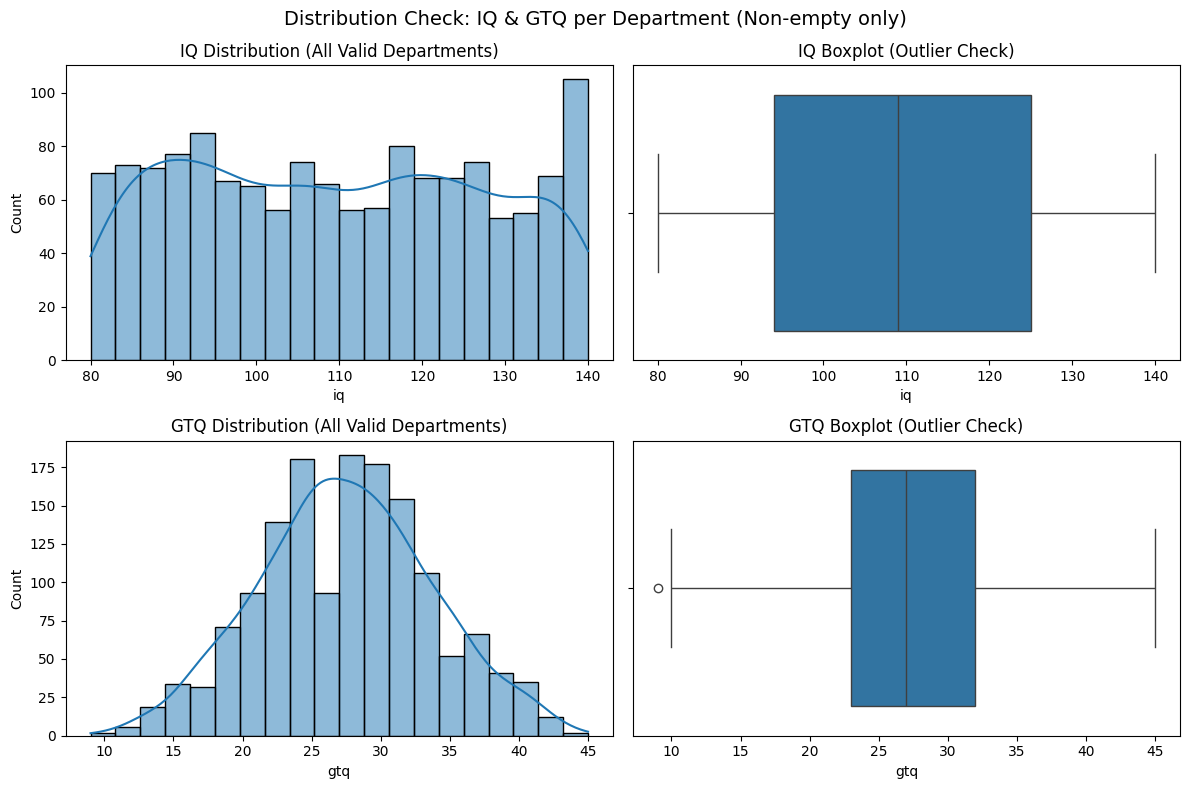

In [14]:

# Filter only departments that have at least some data (not 100% missing)
iq_dept_with_data = missing_iq[missing_iq < 100].index.tolist()
gtq_dept_with_data = missing_gtq[missing_gtq < 100].index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Distribution Check: IQ & GTQ per Department (Non-empty only)", fontsize=14)

# IQ - Histogram
sns.histplot(data=df_main_null[df_main_null['department_id'].isin(iq_dept_with_data)], 
             x='iq', bins=20, kde=True, ax=axes[0,0])
axes[0,0].set_title("IQ Distribution (All Valid Departments)")

# IQ - Boxplot
sns.boxplot(data=df_main_null[df_main_null['department_id'].isin(iq_dept_with_data)], 
            x='iq', ax=axes[0,1])
axes[0,1].set_title("IQ Boxplot (Outlier Check)")

# GTQ - Histogram
sns.histplot(data=df_main_null[df_main_null['department_id'].isin(gtq_dept_with_data)], 
             x='gtq', bins=20, kde=True, ax=axes[1,0])
axes[1,0].set_title("GTQ Distribution (All Valid Departments)")

# GTQ - Boxplot
sns.boxplot(data=df_main_null[df_main_null['department_id'].isin(gtq_dept_with_data)], 
            x='gtq', ax=axes[1,1])
axes[1,1].set_title("GTQ Boxplot (Outlier Check)")

plt.tight_layout()
plt.show()


The histogram and boxplot checks reveal that both `iq` and `gtq` distributions are **slightly skewed** and contain a few outliers, 
but their central tendency (median) remains stable across departments.  

Therefore, **median imputation is justified** because:
- It is robust to skewness and outliers.
- It maintains the within-department central trend without being influenced by extreme values.


In [15]:

# Define helper function for department-wise median imputation (returns filled series)
def fill_median_per_dept(series):
    if series.isna().all():
        return series  # skip department with all NaN
    median_val = series.median()
    return series.fillna(median_val)

# Create backup before imputation for flag comparison 
df_main_null["iq_before"] = df_main_null["iq"]
df_main_null["gtq_before"] = df_main_null["gtq"]

#Apply median imputation per department 
df_main_null["iq"] = df_main_null.groupby("department_id")["iq"].transform(fill_median_per_dept)
df_main_null["gtq"] = df_main_null.groupby("department_id")["gtq"].transform(fill_median_per_dept)

# Create binary flags for imputation transparency 
df_main_null["iq_is_imputed"] = np.where(
    df_main_null["iq_before"].isna() & df_main_null["iq"].notna(), 1, 0
)
df_main_null["gtq_is_imputed"] = np.where(
    df_main_null["gtq_before"].isna() & df_main_null["gtq"].notna(), 1, 0
)

# Create department-level data availability flags 
df_main_null["has_iq_data"] = np.where(df_main_null["department_id"].isin(iq_dept_with_data), 1, 0)
df_main_null["has_gtq_data"] = np.where(df_main_null["department_id"].isin(gtq_dept_with_data), 1, 0)

# Drop backup columns for cleanliness 
df_main_null.drop(["iq_before", "gtq_before"], axis=1, inplace=True)

# Check imputation results 
print("\nRemaining missing values after imputation:")
print(df_main_null[["iq", "gtq"]].isna().sum())

print("\nNumber of imputed rows (flag = 1):")
print(df_main_null[["iq_is_imputed", "gtq_is_imputed"]].sum())



Remaining missing values after imputation:
iq     297
gtq    297
dtype: int64

Number of imputed rows (flag = 1):
iq_is_imputed     107
gtq_is_imputed      0
dtype: int64


Based on the distributional checks, median imputation was applied selectively:
- **Departments with full missingness (100%)** which is **4** wit total 297 data were left as `NaN` (no valid basis for imputation).
- **Departments with partial missingness (<100%)** were imputed using the **median per department**.

This ensures that:
1. The imputed values are consistent with department-level data behavior.
2. Statistical validity is maintained by avoiding global imputation biases.
3. Future modeling steps can still differentiate between departments with or without assessment data through binary flags.


In [16]:
#  Check Distribution of Categorical Data ('mbti' and 'disc') 

print("--- MBTI Value Distribution (Normalized) ---")
# Using normalize=True gives percentage, easier to judge dominance
# .head(10) shows the top 10 most frequent types
print(df_main_null['mbti'].value_counts(normalize=True).head(10))

print("\n--- DISC Value Distribution (Normalized) ---")
# Check distribution for DISC as well
print(df_main_null['disc'].value_counts(normalize=True).head(10))

--- MBTI Value Distribution (Normalized) ---
mbti
ENFP    0.079422
ENFJ    0.070397
INTP    0.068592
INFP    0.064982
ENTP    0.063779
ESFJ    0.063177
ENTJ    0.061974
ISFP    0.061974
ISTP    0.061974
ISTJ    0.059567
Name: proportion, dtype: float64

--- DISC Value Distribution (Normalized) ---
disc
CI    0.094570
CD    0.093960
DC    0.092129
SC    0.090299
SI    0.089689
CS    0.084808
DI    0.081757
ID    0.077486
IC    0.076266
DS    0.075046
Name: proportion, dtype: float64


In [17]:
pd.pivot_table(df_main, index='disc_word', columns='disc', aggfunc='size', fill_value=0)

disc,CD,CI,CS,DC,DI,DS,IC,ID,IS,SC,SD,SI
disc_word,,,,,,,,,,,,
Conscientious-Dominant,169,0,0,0,0,0,0,0,0,0,0,0
Conscientious-Influencer,0,173,0,0,0,0,0,0,0,0,0,0
Conscientious-Steadiness,0,0,159,0,0,0,0,0,0,0,0,0
Dominant-Conscientious,0,0,0,163,0,0,0,0,0,0,0,0
Dominant-Influencer,0,0,0,0,154,0,0,0,0,0,0,0
Dominant-Steadiness,0,0,0,0,0,140,0,0,0,0,0,0
Influencer-Conscientious,0,0,0,0,0,0,147,0,0,0,0,0
Influencer-Dominant,0,0,0,0,0,0,0,143,0,0,0,0
Influencer-Steadiness,0,0,0,0,0,0,0,0,127,0,0,0



After checking the mode distribution for `mbti` and `disc`, and particularly confirming the consistent relationship between `disc_word` and `disc`, the following imputation strategy will be applied to handle missing values:

1.  **`disc` (171 missing):**
    * Missing `disc` values will first be imputed **using the corresponding `disc_word`** via a predefined mapping (e.g., 'Steadiness-Conscientious' maps to 'SC'). This leverages existing information for higher accuracy.

2.  **`mbti` (149 missing):**
    * Since no similar direct mapping is available and the distribution check showed no single type overly dominating (mode `ENFP` at ~8%), missing `mbti` values will be imputed using the **mode (`ENFP`)**.

*Potential Bias:* While these imputation methods help retain data rows, mode imputation can slightly inflate the frequency of the most common categories, and the mapping for `disc` relies on the completeness of `disc_word`. Results should be interpreted with this in mind.

In [18]:
# Standardize DISC first
df_main_null['disc'] = df_main_null['disc'].str.upper().str.strip()
# Standardize disc_word as well (important for mapping)
df_main_null['disc_word'] = df_main_null['disc_word'].str.strip()
print("DISC standardized to uppercase and stripped.")

# Smart Imputation for DISC using disc_word
disc_map = {
    'Dominant-Influencer': 'DI', 'Dominant-Steadiness': 'DS', 'Dominant-Conscientious': 'DC',
    'Influencer-Dominant': 'ID', 'Influencer-Steadiness': 'IS', 'Influencer-Conscientious': 'IC',
    'Steadiness-Dominant': 'SD', 'Steadiness-Influencer': 'SI', 'Steadiness-Conscientious': 'SC',
    'Conscientious-Dominant': 'CD', 'Conscientious-Influencer': 'CI', 'Conscientious-Steadiness': 'CS'
    # Add any other observed variations from df_main['disc_word'].unique()
}
print(f"\nMissing 'disc' values (Before smart impute): {df_main_null['disc'].isnull().sum()}")
mapped_disc = df_main_null['disc_word'].map(disc_map)
df_main_null['disc']= df_main_null['disc'].fillna(mapped_disc)
print(f"Missing 'disc' values (After mapping): {df_main_null['disc'].isnull().sum()}")


DISC standardized to uppercase and stripped.

Missing 'disc' values (Before smart impute): 155
Missing 'disc' values (After mapping): 0


In [19]:
#Imputation value

# Verify initial missing counts
print("\n--- Missing Values (Before Imputation) ---")
print(df_main_null[[ 'mbti']].isnull().sum())



# Action 2: Impute categorical columns ('mbti) with mode
mode_mbti = df_main_null['mbti'].mode()[0] # .mode() can return multiple values if ties exist, [0] selects the first one
df_main_null['mbti']=df_main_null['mbti'].fillna(mode_mbti)
print(f"Missing 'mbti' imputed with mode: '{mode_mbti}'")


# --- Verification ---
print("\n--- Missing Values (After Imputation) ---")
# Check only the imputed columns
print(df_main_null[[ 'mbti']].isnull().sum())


--- Missing Values (Before Imputation) ---
mbti    132
dtype: int64
Missing 'mbti' imputed with mode: 'ENFP'

--- Missing Values (After Imputation) ---
mbti    0
dtype: int64


In [20]:
display(df_main_null.isnull().sum(), len(df_main_null))

employee_id                  0
fullname                     0
nip                          0
company_id                   0
area_id                      0
position_id                  0
department_id                0
division_id                  0
directorate_id               0
grade_id                     0
education_id                 0
major_id                     0
years_of_service_months      0
pauli                        0
faxtor                       0
disc                         0
disc_word                    0
mbti                         0
iq                         297
gtq                        297
tiki                         0
rating                       0
current_year                 0
iq_is_imputed                0
gtq_is_imputed               0
has_iq_data                  0
has_gtq_data                 0
dtype: int64

1794

Final data after cleaning and handling missing/null values contains **1,794 valid records**, with **297 remaining `NaN` values**.  

These remaining missing values correspond primarily to departments where **IQ and GTQ assessments were never conducted**, 

#### Irrelevant value/ Typo in Categorical column

In [21]:
# Make a copy for irrelevant value check
df_main_irrelevant = df_main_null.copy()

df_main_irrelevant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1794 entries, 0 to 2009
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              1794 non-null   object 
 1   fullname                 1794 non-null   object 
 2   nip                      1794 non-null   object 
 3   company_id               1794 non-null   int64  
 4   area_id                  1794 non-null   int64  
 5   position_id              1794 non-null   int64  
 6   department_id            1794 non-null   int64  
 7   division_id              1794 non-null   int64  
 8   directorate_id           1794 non-null   int64  
 9   grade_id                 1794 non-null   int64  
 10  education_id             1794 non-null   int64  
 11  major_id                 1794 non-null   int64  
 12  years_of_service_months  1794 non-null   int64  
 13  pauli                    1794 non-null   int64  
 14  faxtor                   1794

In [22]:
# Check the value of each categorical columns  mainly for disc,disc_word and mbti

print("--- DISC Value Counts (Absolute) ---")
print(df_main_irrelevant['disc'].value_counts())

--- DISC Value Counts (Absolute) ---
disc
CI    170
CD    167
DC    165
SI    160
SC    158
CS    154
DI    153
ID    139
IC    135
DS    134
SD    134
IS    125
Name: count, dtype: int64


In [23]:
print("\n--- DISC Word Value Counts (Absolute) ---")
print(df_main_irrelevant['disc_word'].value_counts())


--- DISC Word Value Counts (Absolute) ---
disc_word
Conscientious-Influencer    170
Conscientious-Dominant      167
Dominant-Conscientious      165
Steadiness-Influencer       160
Steadiness-Conscientious    158
Conscientious-Steadiness    154
Dominant-Influencer         153
Influencer-Dominant         139
Influencer-Conscientious    135
Dominant-Steadiness         134
Steadiness-Dominant         134
Influencer-Steadiness       125
Name: count, dtype: int64


In [24]:
print("\n--- MBTI Value Counts (Absolute) ---")
print(df_main_irrelevant['mbti'].value_counts())


--- MBTI Value Counts (Absolute) ---
mbti
ENFP     264
ENFJ     117
INTP     114
INFP     108
ENTP     106
ESFJ     105
ENTJ     103
ISTP     103
ISFP     103
ISTJ      99
ISFJ      98
ESFP      96
ESTJ      96
INFJ      95
INTJ      90
ESTP      87
enfp       6
inftj      3
Istp       1
Name: count, dtype: int64


Since there are no issue in `disc` and `disc_word` upon examining the unique values and their counts in the `mbti` column, several inconsistencies were identified:

1.  **Typographical Errors:** There are 3 instances of `"inftj"`, which appears to be a typo for either `INFJ` or `INTJ`.
2.  **Inconsistent Casing:** Some valid MBTI types appear in lowercase (`"enfp"`, 6 instances) or mixed case (`"Istp"`, 1 instance).

**Action Plan:**

* All values in the `mbti` column will be converted to **uppercase** to ensure consistency (e.g., `"enfp"` becomes `"ENFP"`).
* The likely typo `"inftj"` (which becomes `"INFTJ"` after uppercasing) cannot be reliably corrected to either `INFJ` or `INTJ`. Therefore, these 3 instances will be replaced with **`"UNKNOWN"`** to preserve the data rows without introducing assumptions.
* Missing `mbti` values will still be imputed using the mode after these standardizations are complete.

In [25]:
#  Replace the identified typo 'inftj' with 'UNKNOWN'
typo_mbti = 'inftj'
replacement_mbti = 'UNKNOWN'
if typo_mbti in df_main_irrelevant['mbti'].unique():
    df_main_irrelevant['mbti'] = df_main_irrelevant['mbti'].replace(typo_mbti, replacement_mbti)
    print(f"Replaced '{typo_mbti}' with '{replacement_mbti}'.")
else:
    print(f"Typo '{typo_mbti}' not found after uppercasing (already handled or wasn't present).")


# Convert all entries to uppercase and remove leading/trailing spaces
df_main_irrelevant['mbti'] = df_main_irrelevant['mbti'].str.upper().str.strip()
print("Converted 'mbti' to uppercase and stripped whitespace.")

Replaced 'inftj' with 'UNKNOWN'.
Converted 'mbti' to uppercase and stripped whitespace.


#### Outlier check

In [26]:
#Make a copy the table from the irrelevan check to outlier
df_main_outlier=df_main_irrelevant.copy()

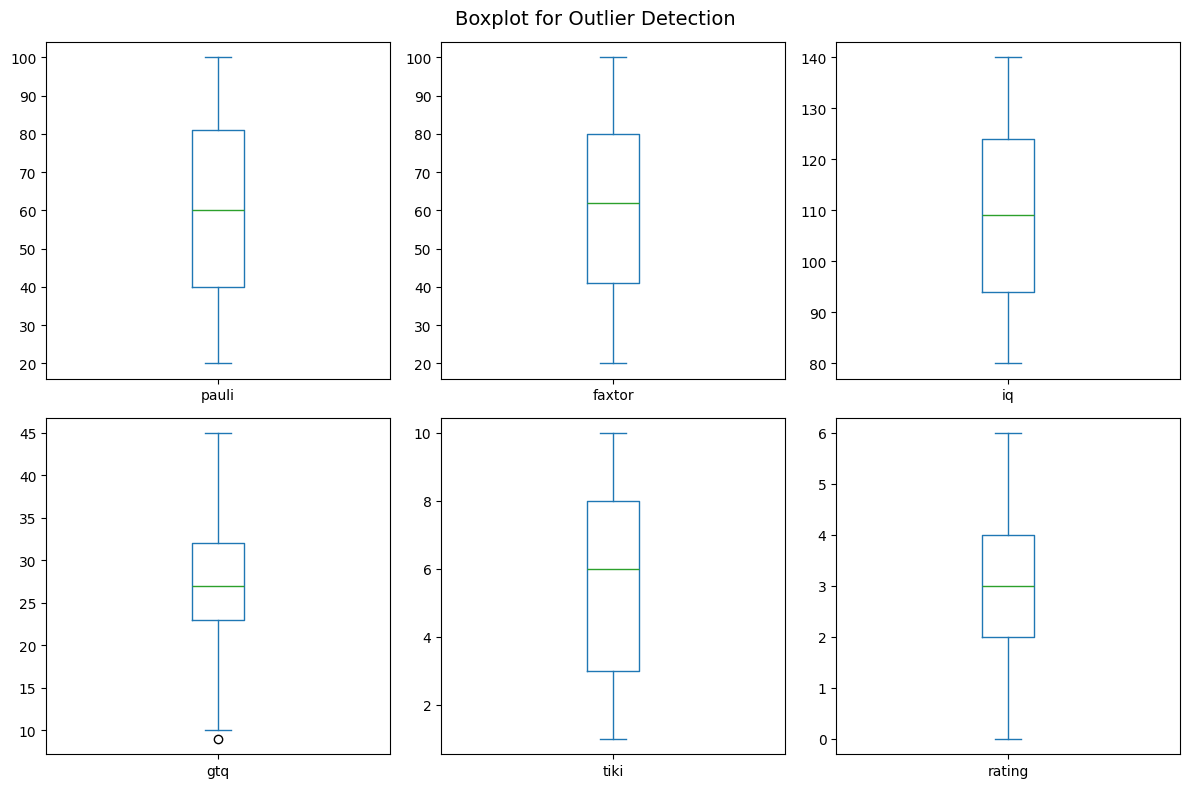


--- No outliers detected for pauli (IQR method) ---

--- No outliers detected for faxtor (IQR method) ---

--- No outliers detected for iq (IQR method) ---

--- Outlier values for gtq (IQR method) ---
[9.]

--- No outliers detected for tiki (IQR method) ---

--- No outliers detected for rating (IQR method) ---
--- Outlier values for rating (Logical method) ---
[6. 6. 0. 0.]

Outlier Detection Summary (IQR & Logical Ranges):


,Q1,Q3,IQR,Lower Bound (IQR),Upper Bound (IQR),Expected Min,Expected Max,Outlier Count (IQR),Outlier Count (Logical),Outlier % (IQR)
pauli,40.0,81.0,41.0,-21.5,142.5,20.0,100.0,0.0,0.0,0.0
faxtor,41.0,80.0,39.0,-17.5,138.5,20.0,100.0,0.0,0.0,0.0
iq,94.0,124.0,30.0,49.0,169.0,80.0,140.0,0.0,0.0,0.0
gtq,23.0,32.0,9.0,9.5,45.5,None,None,1,N/A,0.06
tiki,3.0,8.0,5.0,-4.5,15.5,1.0,10.0,0.0,0.0,0.0
rating,2.0,4.0,2.0,-1.0,7.0,1.0,5.0,0.0,4.0,0.0


In [27]:
# Select numeric columns to check for outliers
columns_to_check = ['pauli', 'faxtor', 'iq', 'gtq', 'tiki', 'rating']

# Create boxplots for visual inspection
df_main_outlier[columns_to_check].plot(
    kind='box',
    subplots=True,
    layout=(2, 3),
    figsize=(12, 8),
    sharex=False,
    sharey=False
)
plt.suptitle("Boxplot for Outlier Detection", fontsize=14)
plt.tight_layout()
plt.show()

# Define logical (expected) value ranges
# Note: 'gtq' is excluded because it represents a total score that varies widely
logical_ranges = {
    'pauli': (20, 100),
    'faxtor': (20, 100),
    'iq': (80, 140),
    'tiki': (1, 10),
    'rating': (1, 5)
}

# Dictionary to store outlier info summary
outlier_info = {}

# Loop through each numeric column
for col in columns_to_check:
    # --- Compute Interquartile Range (IQR) ---
    Q1 = df_main_outlier[col].quantile(0.25)
    Q3 = df_main_outlier[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # --- Detect outliers using IQR ---
    outliers_iqr = df_main_outlier[
        (df_main_outlier[col] < lower_bound) | (df_main_outlier[col] > upper_bound)
    ]
    
    # --- Detect logical (expected range) outliers ---
    if col in logical_ranges:  # skip gtq
        low_limit, high_limit = logical_ranges[col]
        outliers_logical = df_main_outlier[
            (df_main_outlier[col] < low_limit) | (df_main_outlier[col] > high_limit)
        ]
        logical_min = low_limit
        logical_max = high_limit
        logical_count = len(outliers_logical)
    else:
        logical_min = None
        logical_max = None
        logical_count = "N/A"
    
    # --- Print actual outlier values (IQR) ---
    if len(outliers_iqr) > 0:
        print(f"\n--- Outlier values for {col} (IQR method) ---")
        print(outliers_iqr[col].values)
    else:
        print(f"\n--- No outliers detected for {col} (IQR method) ---")

    # --- Print logical outlier values ---
    if col in logical_ranges and logical_count != "N/A" and logical_count > 0:
        print(f"--- Outlier values for {col} (Logical method) ---")
        print(outliers_logical[col].values)

    # --- Combine results into summary dict ---
    outlier_info[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound (IQR)': lower_bound,
        'Upper Bound (IQR)': upper_bound,
        'Expected Min': logical_min,
        'Expected Max': logical_max,
        'Outlier Count (IQR)': len(outliers_iqr),
        'Outlier Count (Logical)': logical_count,
        'Outlier % (IQR)': round((len(outliers_iqr) / len(df_main_outlier)) * 100, 2)
    }

# Create summary DataFrame
outlier_df = pd.DataFrame(outlier_info).T

# Display the summary table
print("\nOutlier Detection Summary (IQR & Logical Ranges):")
display(outlier_df)



  *   `gtq_total`: One value (9) was flagged as a statistical outlier by the IQR method (Lower Bound: 9.5). However, this value is not logically impossible given the potential range of GTQ scores.
       
   *    `rating`: Four values (two 0s, two 6s)  outside the expected logical range of 1-5. These are considered data errors.

* **Action Plan:**
    * The `gtq_total` outlier (9) will be **kept** as it's statistically low but plausibly valid.
    * The rows with `rating` values of 0 or 6 will be **removed** as they represent data errors and cannot be correctly classified for performance analysis.

In [28]:
# Remove logically invalid ratings
df_main_outlier = df_main_outlier[~df_main_outlier['rating'].isin([0,6])]

print(f"Removed rows with invalid ratings (0 or 6). Remaining data: {len(df_main_outlier)} rows.")


Removed rows with invalid ratings (0 or 6). Remaining data: 1790 rows.


##### Cleaned Data

After completing all data preprocessing steps  including handling missing values, logical validation, and outlier removal 
the final cleaned dataset (`df_main_cleaned`) contains **1,790 valid and consistent records**.

In [29]:
#Make a copy to a clean data
df_main_cleaned = df_main_outlier.copy()

display(df_main_cleaned.head(), df_main_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1790 entries, 0 to 2009
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              1790 non-null   object 
 1   fullname                 1790 non-null   object 
 2   nip                      1790 non-null   object 
 3   company_id               1790 non-null   int64  
 4   area_id                  1790 non-null   int64  
 5   position_id              1790 non-null   int64  
 6   department_id            1790 non-null   int64  
 7   division_id              1790 non-null   int64  
 8   directorate_id           1790 non-null   int64  
 9   grade_id                 1790 non-null   int64  
 10  education_id             1790 non-null   int64  
 11  major_id                 1790 non-null   int64  
 12  years_of_service_months  1790 non-null   int64  
 13  pauli                    1790 non-null   int64  
 14  faxtor                   1790

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,mbti,iq,gtq,tiki,rating,current_year,iq_is_imputed,gtq_is_imputed,has_iq_data,has_gtq_data
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,ENFP,94.0,33.0,2,3.0,2025,0,0,1,1
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,INTP,94.0,17.0,3,3.0,2025,0,0,1,1
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,ENFP,109.0,20.0,3,4.0,2025,0,0,1,1
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,ENTJ,85.0,39.0,3,3.0,2025,0,0,1,1
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,INTJ,134.0,21.0,9,4.0,2025,0,0,1,1


None

### One to Many Data

#### Competencies data

In [30]:
df_competencies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20100 entries, 0 to 20099
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee_id   20100 non-null  object 
 1   pillar_code   20100 non-null  object 
 2   pillar_label  20100 non-null  object 
 3   score         18495 non-null  float64
 4   year          20100 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 785.3+ KB


##### Irrelevant Value check

In [31]:
# Make a copy for irrelevant value
df_competencies_irrelevant = df_competencies.copy()

In [32]:
# Check the irrelevant value for each columns mainly for pillar_code , pillar label , and score

print("Unique Pillar Code Counts")
print(df_competencies_irrelevant ['pillar_code'].value_counts())



Unique Pillar Code Counts
pillar_code
GDR    2010
CEX    2010
IDS    2010
QDD    2010
STO    2010
SEA    2010
VCU    2010
LIE    2010
FTC    2010
CSI    2010
Name: count, dtype: int64


In [33]:
print("Unique Pillar Label Counts")
print(df_competencies_irrelevant ['pillar_label'].value_counts())



Unique Pillar Label Counts
pillar_label
Growth Drive & Resilience       2010
Curiosity & Experimentation     2010
Insight & Decision Sharpness    2010
Quality Delivery Discipline     2010
Synergy & Team Orientation      2010
Social Empathy & Awareness      2010
Value Creation for Users        2010
Lead, Inspire & Empower         2010
Forward Thinking & Clarity      2010
Commercial Savvy & Impact       2010
Name: count, dtype: int64


In [34]:
print("\nScore Value Counts")
# Verify that only scores 1-5 (or imputed medians) exist
# Use sort_index() to see them in order
print(df_competencies_irrelevant ['score'].value_counts().sort_index())


Score Value Counts
score
0.0       26
1.0     2005
2.0     3799
3.0     5751
4.0     4640
5.0     2206
6.0       30
99.0      38
Name: count, dtype: int64


**Anomaly Detection in Competency Scores:**

The `.value_counts()` output for the `score` column confirms the presence of values outside the expected 1-5 range:
* Scores of **0.0** (26 instances)
* Scores of **6.0** (30 instances)
* Scores of **99.0** (38 instances)

These are considered data errors or invalid placeholders and must be handled before imputation.

**Action Plan:** These anomalous scores (0.0, 6.0, 99.0) will be replaced with `NaN` to treat them as missing values

In [35]:
# Clean Anomalous Scores (0, 6, 99) and Impute 

# Replace Anomalous Scores with NaN 
invalid_scores = [0.0, 6.0, 99.0]
original_nan_count = df_competencies_irrelevant['score'].isnull().sum() # Count NaNs before replacement

print(f"Original NaN count in score: {original_nan_count}")
print(f"Count of 0.0 scores: {(df_competencies_irrelevant['score'] == 0.0).sum()}")
print(f"Count of 6.0 scores: {(df_competencies_irrelevant['score'] == 6.0).sum()}") # Check for 6.0
print(f"Count of 99.0 scores: {(df_competencies_irrelevant['score'] == 99.0).sum()}")

# Replace 0, 6, and 99 with NaN
df_competencies_irrelevant['score'] = df_competencies_irrelevant['score'].replace(invalid_scores, np.nan)

new_nan_count = df_competencies_irrelevant['score'].isnull().sum()
print(f"\nValues 0.0, 6.0, and 99.0 replaced with NaN.")
print(f"New total NaN count in score: {new_nan_count}")

Original NaN count in score: 1605
Count of 0.0 scores: 26
Count of 6.0 scores: 30
Count of 99.0 scores: 38

Values 0.0, 6.0, and 99.0 replaced with NaN.
New total NaN count in score: 1699


##### Null Value 

In [36]:
# Make a copy for null value analysis
df_competencies_null = df_competencies_irrelevant.copy()
df_competencies_null.isnull().sum()

employee_id        0
pillar_code        0
pillar_label       0
score           1699
year               0
dtype: int64

There is **1699 missing values** specifically in the `score` column of the `df_competencies`  

 This represents a significant amount of missing data that needs to be addressed before comparative analysis.

In [37]:
#Check for the missing value per pillar
df_missing = (
    df_competencies_null.groupby("pillar_code")
    .apply(lambda g: pd.DataFrame({
        "missing_count": [g["score"].isna().sum()],
        "total": [len(g)],
        "missing_percentage": [g["score"].isna().sum() / len(g) * 100]
    }))
    .reset_index(level=1, drop=True)
    .reset_index()
    .sort_values("missing_percentage", ascending=False)
)

print(df_missing)


  pillar_code  missing_count  total  missing_percentage
8         STO            185   2010            9.203980
1         CSI            183   2010            9.104478
6         QDD            177   2010            8.805970
9         VCU            176   2010            8.756219
5         LIE            172   2010            8.557214
4         IDS            167   2010            8.308458
2         FTC            165   2010            8.208955
0         CEX            162   2010            8.059701
3         GDR            157   2010            7.810945
7         SEA            155   2010            7.711443


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\845659221.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.DataFrame({


Breaking down the missing scores **by competency pillar** shows that the missing data is distributed across **all pillars**, with percentages ranging from approximately **7.4% to 9.3%**. No single pillar has an exceptionally high rate of missingness compared to others.

**Implication:** Since the missingness is relatively low (<10%) but present everywhere, simply ignoring `NaN` (`skipna=True`) during group comparisons could still introduce bias if the missingness isn't random across performance groups. Therefore, imputation remains a practical approach to ensure consistent group comparisons across all pillars.

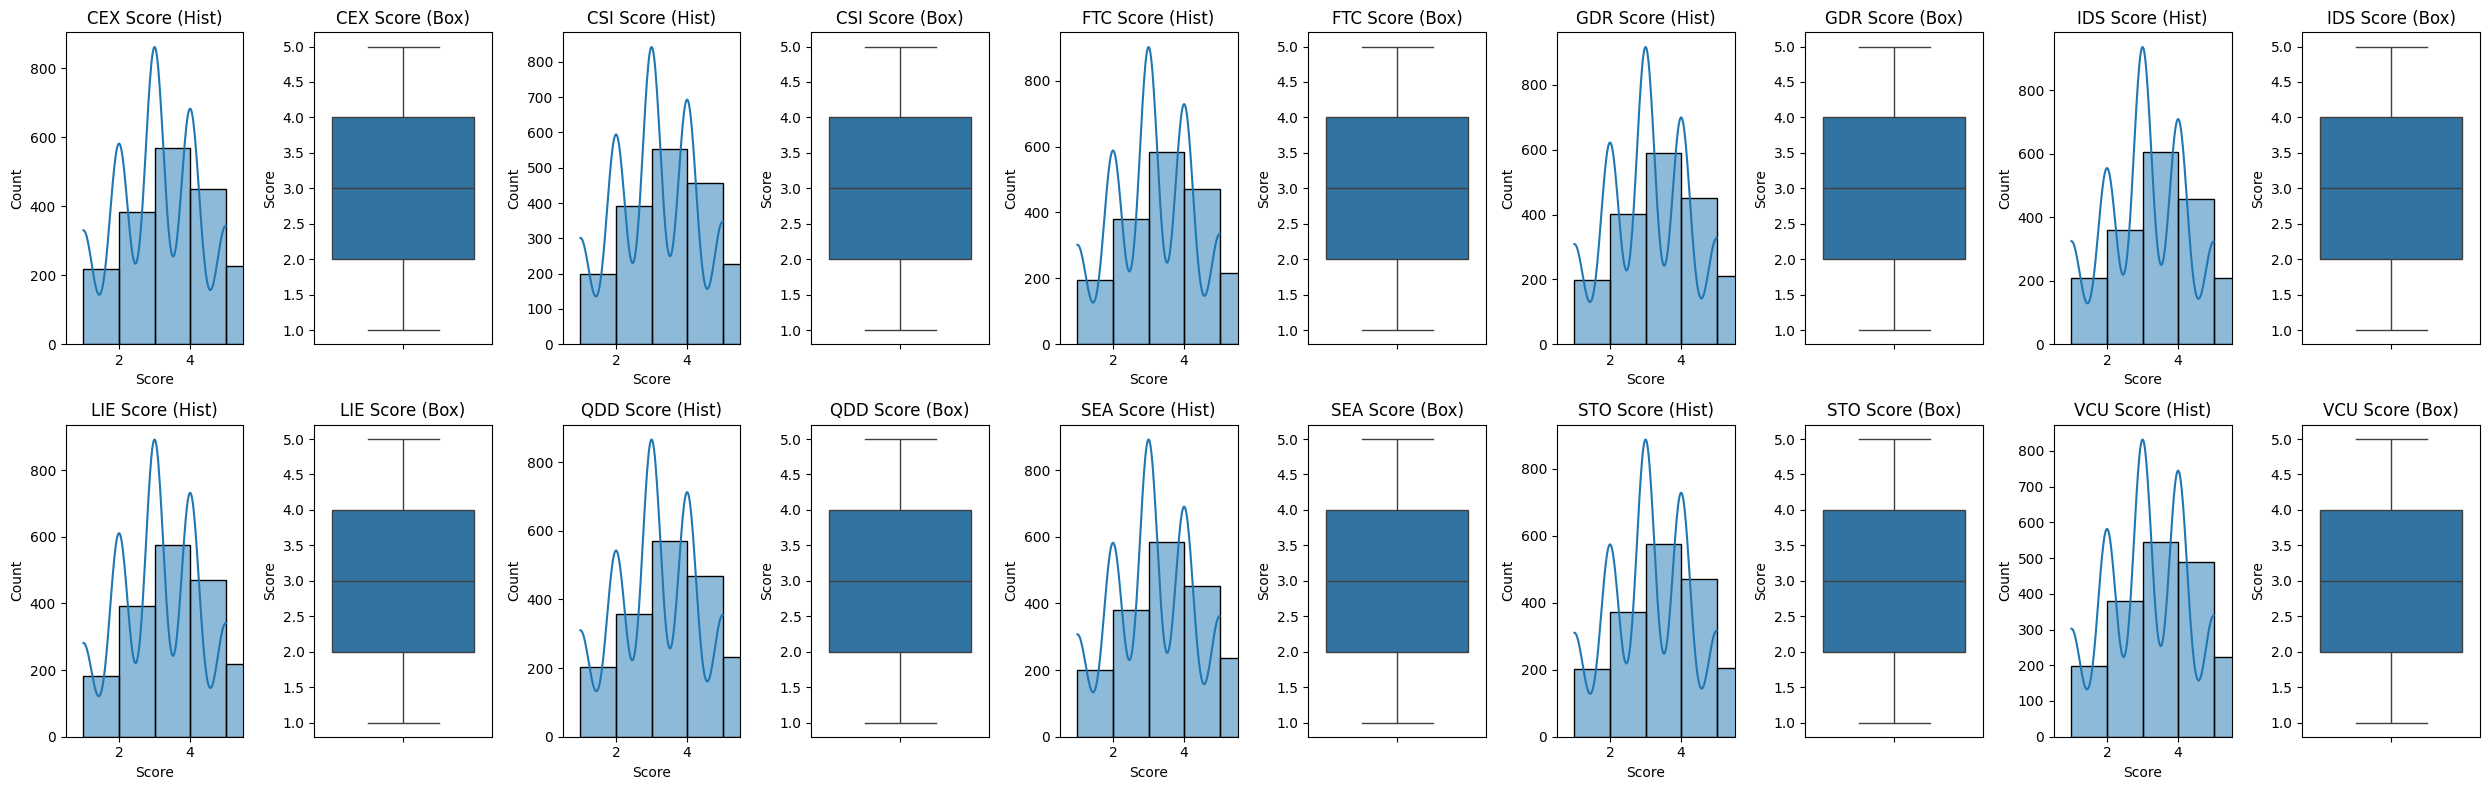

In [38]:
#Check Score Distribution per Competency Pillar (with X-axis Limit) ---

# Get unique pillar codes
pillar_codes = df_competencies_null['pillar_code'].unique()
n_pillars = len(pillar_codes)

# Determine grid size (e.g., 5 columns wide)
n_cols = 5
n_rows = (n_pillars + n_cols - 1) // n_cols # Calculate needed rows

# Create figure and axes grid
fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(n_cols * 5, n_rows * 4)) # 2 plots per pillar
axes = axes.flatten() # Flatten the axes array for easy iteration

plot_idx = 0
for i, pillar in enumerate(sorted(pillar_codes)): # Sort pillars for consistent order
    # Filter data for the current pillar, excluding NaNs for plotting distribution
    pillar_data = df_competencies_null[df_competencies_null['pillar_code'] == pillar]['score'].dropna()

    if not pillar_data.empty:
        # Histogram
        ax_hist = axes[plot_idx]
        sns.histplot(pillar_data, kde=True, ax=ax_hist, bins=range(1, 7)) # Optional: set bins for integer scores
        ax_hist.set_title(f'{pillar} Score (Hist)')
        ax_hist.set_xlabel('Score')
        ax_hist.set_xlim(0.5, 5.5) # Set x-axis limits from 0.5 to 5.5

        # Boxplot
        ax_box = axes[plot_idx + 1]
        sns.boxplot(y=pillar_data, ax=ax_box)
        ax_box.set_title(f'{pillar} Score (Box)')
        ax_box.set_ylabel('Score')
        # Optional: Set y-axis limit for boxplot too if needed
        # ax_box.set_ylim(0.5, 5.5)

        plot_idx += 2 # Move to the next pair of axes
    else:
         # Handle case where a pillar might have NO scores
        axes[plot_idx].set_title(f'{pillar} (No Data)')
        axes[plot_idx].set_visible(False)
        axes[plot_idx + 1].set_visible(False)
        plot_idx += 2


# Hide any unused subplots at the end
for j in range(plot_idx, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

* Given the slightly presence of outliers and potential skewness in the score distributions for various pillars, using the **pillar-specific median** is confirmed as the most **robust** imputation method. The median is less sensitive to extreme values compared to the mean, providing a more stable estimate of the central tendency for filling missing scores in this dataset.

In [39]:
# Impute Missing Competency Scores using Median *per Pillar

print(f"Missing 'score' in df_competencies (Before): {df_competencies_null['score'].isnull().sum()}")

# Backup original column for flagging
df_competencies_null['score_before'] = df_competencies_null['score']

# Calculate the median score FOR EACH pillar_code separately
# 'transform' calculates the median per group and then aligns it back to the original index
median_scores_by_pillar = df_competencies_null.groupby('pillar_code')['score'].transform('median')

# Fill NaN values in the 'score' column using the corresponding pillar's median
# Using the safer assignment method
df_competencies_null['score'] = df_competencies_null['score'].fillna(median_scores_by_pillar)

# Create flag for imputed rows 
df_competencies_null['score_is_imputed'] = np.where(df_competencies_null['score_before'].isna() & df_competencies_null['score'].notna(),1, 0)

# Drop temporary backup column 
df_competencies_null.drop(columns=['score_before'], inplace=True)

# Print summary 
print(f"\nMissing 'score' in df_competencies imputed with pillar-specific median.")
print(f"Missing 'score' in df_competencies (After): {df_competencies_null['score'].isnull().sum()}")
print(f"Number of rows imputed (flag=1): {df_competencies_null['score_is_imputed'].sum()}")

Missing 'score' in df_competencies (Before): 1699

Missing 'score' in df_competencies imputed with pillar-specific median.
Missing 'score' in df_competencies (After): 0
Number of rows imputed (flag=1): 1699


 The missing `score` values have been successfully imputed using the **median score specific to each `pillar_code`**. The verification step confirms that there are now **0 missing values** in the `score` column.

**Rationale:** While acknowledging that the original `NaN` might represent "not assessed" or "not applicable," this imputation method was chosen primarily to **enable consistent and fair comparison of average scores between performance groups across all competency pillars** during this exploratory phase. The potential bias introduced by using the median is noted and will be considered during interpretation, especially for pillars where the difference between groups is marginal.

##### Cleaned Competencies data

After handling anomalous scores (0.0, 6.0, 99.0) by converting them to `NaN` and subsequently imputing all missing values using the pillar-specific median, the final cleaned `df_competencies_cleaned` (filtered for year 2025) contains **20,100 records with complete and valid scores** within the expected 1-5 range (including imputed values).

In [40]:
#Cleaned data for competencies table
df_competencies_cleaned = df_competencies_null.copy()
df_competencies_cleaned

,employee_id,pillar_code,pillar_label,score,year,score_is_imputed
0,EMP100000,GDR,Growth Drive & Resilience,3.0,2025,0
1,EMP100001,GDR,Growth Drive & Resilience,2.0,2025,0
2,EMP100002,GDR,Growth Drive & Resilience,3.0,2025,0
3,EMP100003,GDR,Growth Drive & Resilience,4.0,2025,0
4,EMP100004,GDR,Growth Drive & Resilience,4.0,2025,0
...,...,...,...,...,...,...
20095,DUP1942,CSI,Commercial Savvy & Impact,5.0,2025,0
20096,DUP2096,CSI,Commercial Savvy & Impact,3.0,2025,0
20097,DUP4177,CSI,Commercial Savvy & Impact,2.0,2025,0
20098,DUP9801,CSI,Commercial Savvy & Impact,5.0,2025,0


#### Strengths Data

In [41]:
display(df_strengths.info(), df_strengths.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28140 entries, 0 to 28139
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   employee_id  28140 non-null  object
 1   rank         28140 non-null  int64 
 2   theme        28140 non-null  object
dtypes: int64(1), object(2)
memory usage: 659.7+ KB


None

,employee_id,rank,theme
28135,EMP101999,10,Empathy
28136,EMP101999,11,Activator
28137,EMP101999,12,Significance
28138,EMP101999,13,Responsibility
28139,EMP101999,14,Harmony


##### Irrelevant Value

In [42]:
# Make a copy from strengths data for irrelevant value check
df_strengths_irrelevant= df_strengths.copy()

In [43]:
# Take a look for an example from one employee
df_strengths_irrelevant[df_strengths_irrelevant['employee_id'] == 'EMP100000']

,employee_id,rank,theme
140,EMP100000,1,
141,EMP100000,2,Adaptability
142,EMP100000,3,Context
143,EMP100000,4,Competition
144,EMP100000,5,Activator
145,EMP100000,6,Positivity
146,EMP100000,7,Significance
147,EMP100000,8,Empathy
148,EMP100000,9,Ideation
149,EMP100000,10,Developer


Based on check on certain employee, some rows in the `theme` column look empty but are **not recognized as NaN** in pandas.

**Possible causes:**

- The values contain spaces (`' '`), empty strings (`''`), or hidden characters (`'\t'`, `'\xa0'`).
- The CSV was read without specifying `na_values`


In [44]:
 # Clean up "theme" column from any string-like missing values
df_strengths_irrelevant['theme'] = ( df_strengths_irrelevant['theme'].str.strip().replace(['', 'nan', 'NaN', 'None'], np.nan)  )

In [45]:
# Check and validate again 
df_strengths_irrelevant[df_strengths_irrelevant['employee_id'] == 'EMP100000']

,employee_id,rank,theme
140,EMP100000,1,NaN
141,EMP100000,2,Adaptability
142,EMP100000,3,Context
143,EMP100000,4,Competition
144,EMP100000,5,Activator
145,EMP100000,6,Positivity
146,EMP100000,7,Significance
147,EMP100000,8,Empathy
148,EMP100000,9,Ideation
149,EMP100000,10,Developer


##### Null Value Check

In [46]:
#Make a copy for null data
df_strengths_null = df_strengths_irrelevant.copy()


In [47]:
# Check the null data
df_strengths_null.isna().sum()

employee_id       0
rank              0
theme          2229
dtype: int64

There are **2229** instances or data points that missing for the `strengths` data, which mainly from previous action by converting the empty value to "NaN"

**Action Plan:**

While imputation for categorical strength themes is unreliable, the presence of missing values is particularly critical for the analysis of **Top 5 Strengths**, as these represent an employee's most dominant talents. Therefore, the next step is to identify how many employees have incomplete data within these crucial top ranks.


In [48]:
# Find employee_ids with NaN in ranks 1 through 5
employees_with_missing_top5 = df_strengths_irrelevant[(df_strengths_null['rank'] <= 5) & (df_strengths_null['theme'].isnull())]['employee_id'].unique()

print(f"Number of employees with missing themes in Top 5: {len(employees_with_missing_top5)}")

Number of employees with missing themes in Top 5: 693


Including these **693 employees (34.5 %)** in an analysis focused on Top 5 strength frequencies would yield inaccurate and potentially misleading results. Therefore, for the specific analysis comparing the frequency of Top 5 strengths between high performers and others, these employees **will be excluded**. This ensures the comparison is based solely on employees with complete and valid Top 5 strength profiles.

In [49]:
# Use the boolean NOT operator (~) with isin() to keep only employees NOT in the list
df_strengths_complete = df_strengths_null[~df_strengths_null['employee_id'].isin(employees_with_missing_top5)].copy() # Use .copy() to avoid SettingWithCopyWarning later

print(f"Created df_strengths_complete with {df_strengths_complete['employee_id'].nunique()} employees (data complete for Top 5 analysis).")

# Filter for Top 5 Ranks Only (from the complete data)

df_top5_analysis_strength = df_strengths_complete[df_strengths_complete['rank'] <= 5].copy()

print(f"Created df_top5_analysis_ready containing only ranks 1-5 for {df_top5_analysis_strength['employee_id'].nunique()} employees.")
print("\n--- Sample of df_top5_analysis_ready ---")
print(df_top5_analysis_strength.head())

Created df_strengths_complete with 1317 employees (data complete for Top 5 analysis).
Created df_top5_analysis_ready containing only ranks 1-5 for 1317 employees.

--- Sample of df_top5_analysis_ready ---
  employee_id  rank        theme
0     DUP1942     1      Learner
1     DUP1942     2    Maximizer
2     DUP1942     3     Ideation
3     DUP1942     4      Harmony
4     DUP1942     5  Restorative


##### Cleaned data

In [50]:
df_top5_analysis_strength

,employee_id,rank,theme
0,DUP1942,1,Learner
1,DUP1942,2,Maximizer
2,DUP1942,3,Ideation
3,DUP1942,4,Harmony
4,DUP1942,5,Restorative
...,...,...,...
28126,EMP101999,1,Ideation
28127,EMP101999,2,Input
28128,EMP101999,3,Positivity
28129,EMP101999,4,Adaptability


This resulted in the `df_top5_analysis_strength` DataFrame, containing **6585 rows** (1317 employees × 5 ranks each). This DataFrame represents the complete and valid Top 5 strengths data and will be  merged with `df_main_cleaned`  later to compare dominant themes between performance groups.

#### Papi_Scores

In [51]:
df_papi_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40200 entries, 0 to 40199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  40200 non-null  object 
 1   scale_code   40200 non-null  object 
 2   score        36997 non-null  float64
dtypes: float64(1), object(2)
memory usage: 942.3+ KB


##### Irrelevant Values

In [52]:
# Make a copy for irrelevant analysis

df_papi_scores_irrelevant = df_papi_scores.copy()

In [53]:
#Check for the caetgorical variable through scale_code
df_papi_scores_irrelevant['scale_code'].value_counts()

scale_code
Papi_A    2010
Papi_B    2010
Papi_C    2010
Papi_D    2010
Papi_E    2010
Papi_F    2010
Papi_G    2010
Papi_I    2010
Papi_K    2010
Papi_L    2010
Papi_N    2010
Papi_O    2010
Papi_P    2010
Papi_R    2010
Papi_S    2010
Papi_T    2010
Papi_V    2010
Papi_W    2010
Papi_X    2010
Papi_Z    2010
Name: count, dtype: int64

In [54]:
# Check the score which should be in range between 1 to 9 
df_papi_scores_irrelevant['score'].describe()

count    36997.000000
mean         4.992026
std          2.588955
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: score, dtype: float64

There are no issues on irrelevant or typo values within the `papi_scores` data

##### Null Value Check

In [55]:
#Make a copy for null value check
df_papi_scores_null = df_papi_scores_irrelevant.copy()

In [56]:
df_papi_scores_null.isna().sum()

employee_id       0
scale_code        0
score          3203
dtype: int64

There are **3203** null values in score column

In [57]:
# Check from random employee_id for the score
df_papi_scores_null[df_papi_scores_null['employee_id'] == "EMP101000"]

,employee_id,scale_code,score
20200,EMP101000,Papi_A,7.0
20201,EMP101000,Papi_B,3.0
20202,EMP101000,Papi_C,5.0
20203,EMP101000,Papi_D,NaN
20204,EMP101000,Papi_E,NaN
20205,EMP101000,Papi_F,NaN
20206,EMP101000,Papi_G,3.0
20207,EMP101000,Papi_I,5.0
20208,EMP101000,Papi_K,1.0
20209,EMP101000,Papi_L,1.0


The output above for employee `EMP101000` illustrates how missing data (`NaN`) appears in the `score` column for specific PAPI scales (e.g., `Papi_D`, `Papi_E`, `Papi_F`, `Papi_N`, `Papi_V`). This pattern confirms that missingness occurs at the individual employee-scale level.

In [58]:
df_papi_scores_null.groupby("scale_code")["score"].apply(lambda x: x.isna().mean() * 100).sort_values(ascending=False)


scale_code
Papi_O    9.402985
Papi_K    8.955224
Papi_L    8.805970
Papi_F    8.606965
Papi_W    8.407960
Papi_I    8.208955
Papi_Z    8.208955
Papi_B    8.159204
Papi_S    8.109453
Papi_D    8.059701
Papi_T    7.960199
Papi_V    7.761194
Papi_N    7.761194
Papi_G    7.711443
Papi_A    7.661692
Papi_R    7.462687
Papi_X    7.363184
Papi_C    7.213930
Papi_E    7.164179
Papi_P    6.368159
Name: score, dtype: float64

The analysis shows the percentage of missing `score` values for each individual PAPI `scale_code`. The missing data percentages range from approximately **6.4% (`Papi_P`) to 9.4% (`Papi_O`)**.

**Implication:** Similar to the competency data, missing values are present across **all** PAPI scales, though none exceed 10%. This pattern reinforces the decision to use **imputation via the scale-specific median**. Doing so allows for consistent comparison between performance groups across every PAPI dimension, mitigating potential bias that could arise from simply ignoring `NaN` values if their occurrence isn't random across the groups.

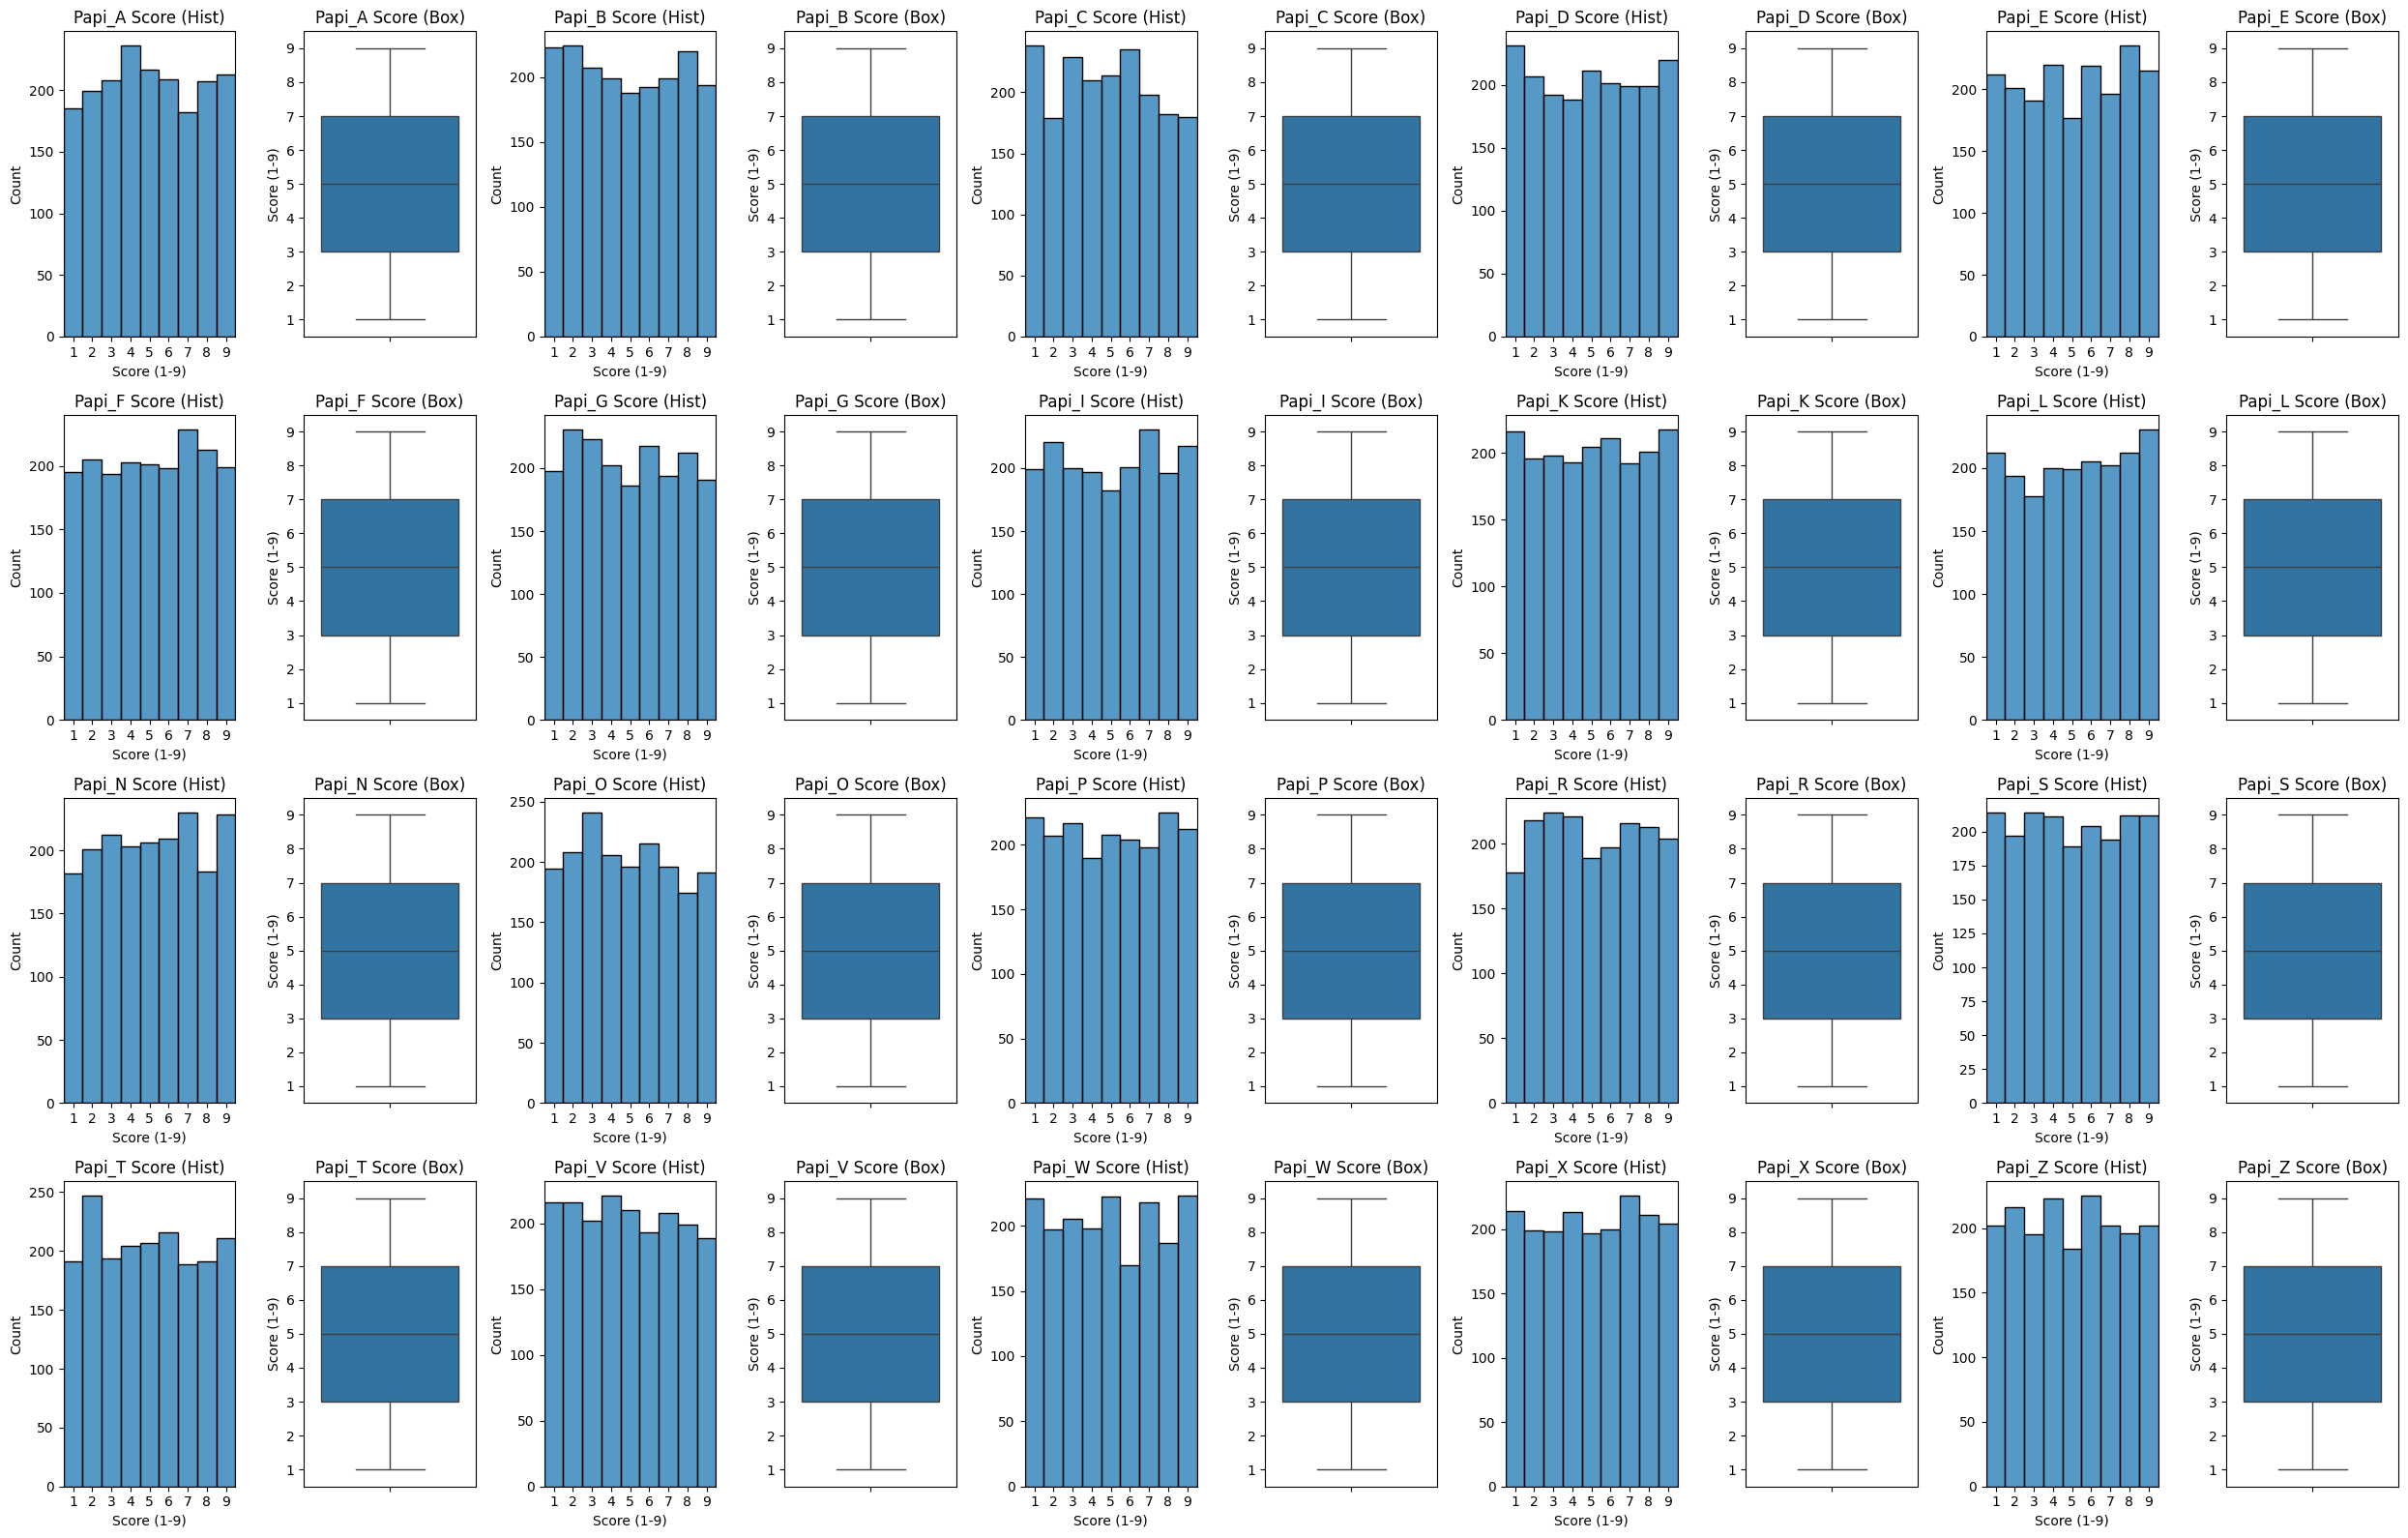

In [59]:
# Check Score Distribution per PAPI Scale 

# Get unique scale codes
scale_codes = df_papi_scores_null['scale_code'].unique()
n_scales = len(scale_codes)

# Determine grid size (e.g., 5 columns wide for pairs of plots)
n_cols = 5
n_rows = (n_scales + n_cols - 1) // n_cols # Calculate needed rows

# Create figure and axes grid
# Each scale gets 2 plots (hist + box), so n_cols * 2 columns needed
fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten() # Flatten the axes array for easy iteration

plot_idx = 0
for i, scale in enumerate(sorted(scale_codes)): # Sort scales alphabetically
    # Filter data for the current scale, excluding NaNs for plotting distribution
    scale_data = df_papi_scores_null[df_papi_scores_null['scale_code'] == scale]['score'].dropna()

    if not scale_data.empty:
        # --- Histogram ---
        ax_hist = axes[plot_idx]
        # Use bins appropriate for integer scores 1-9
        sns.histplot(scale_data, kde=False, ax=ax_hist, bins=np.arange(1, 11) - 0.5)
        ax_hist.set_title(f'{scale} Score (Hist)')
        ax_hist.set_xlabel('Score (1-9)')
        ax_hist.set_xticks(range(1, 10)) # Set ticks for scores 1-9
        ax_hist.set_xlim(0.5, 9.5) # Set x-axis limits

        # --- Boxplot ---
        ax_box = axes[plot_idx + 1]
        sns.boxplot(y=scale_data, ax=ax_box)
        ax_box.set_title(f'{scale} Score (Box)')
        ax_box.set_ylabel('Score (1-9)')
        ax_box.set_ylim(0.5, 9.5) # Set y-axis limits consistent with range 1-9

        plot_idx += 2 # Move to the next pair of axes
    else:
         # Handle case where a scale might have NO scores
        axes[plot_idx].set_title(f'{scale} (No Data)')
        axes[plot_idx].set_visible(False)
        axes[plot_idx + 1].set_visible(False)
        plot_idx += 2


# Hide any unused subplots at the end
for j in range(plot_idx, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Although, There are no presence of variability in distributions and  potential outliers across different PAPI scales. the use of the **scale-specific median** as a robust imputation method will be applied. This approach minimizes the influence of extreme scores and provides a reasonable estimate for missing values within each distinct PAPI dimension.

In [60]:
#Impute Missing PAPI Scores using Median per Scale

print(f"Missing 'score' in df_papiscores (Before): {df_papi_scores_null['score'].isnull().sum()}")

# Backup original column for flagging 
df_papi_scores_null['score_before'] = df_papi_scores_null['score']

# Calculate median per scale_code
median_scores_by_scale = df_papi_scores_null.groupby('scale_code')['score'].transform('median')

# Fill missing values using each scale's median 
df_papi_scores_null['score'] = df_papi_scores_null['score'].fillna(median_scores_by_scale)

# Create binary flag for imputation 
df_papi_scores_null['score_is_imputed'] = np.where(
    df_papi_scores_null['score_before'].isna() & df_papi_scores_null['score'].notna(),1, 0)

# Drop temporary backup column 
df_papi_scores_null.drop(columns=['score_before'], inplace=True)

# Print verification summary
print(f"\nMissing 'score' in Papi Scores imputed with scale-specific median.")
print(f"Missing 'score' in Papi Scores (After): {df_papi_scores_null['score'].isnull().sum()}")
print(f"Number of rows imputed (flag=1): {df_papi_scores_null['score_is_imputed'].sum()}")


Missing 'score' in df_papiscores (Before): 3203

Missing 'score' in Papi Scores imputed with scale-specific median.
Missing 'score' in Papi Scores (After): 0
Number of rows imputed (flag=1): 3203


##### Cleaned Data

After imputing 3203 missing scores using the scale-specific median and adding an imputation flag column, the final cleaned  papi scores data is `df_papi_scores_cleaned` contains **40,200 rows** 

In [61]:
df_papi_scores_cleaned = df_papi_scores_null.copy()
display(df_papi_scores_cleaned.info(), df_papi_scores_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40200 entries, 0 to 40199
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   employee_id       40200 non-null  object 
 1   scale_code        40200 non-null  object 
 2   score             40200 non-null  float64
 3   score_is_imputed  40200 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.2+ MB


None

,employee_id,scale_code,score,score_is_imputed
0,DUP1942,Papi_A,6.0,0
1,DUP1942,Papi_B,5.0,1
2,DUP1942,Papi_C,1.0,0
3,DUP1942,Papi_D,4.0,0
4,DUP1942,Papi_E,3.0,0


## Exploratory Data Analysis (EDA)

Create Target Variable

With the main data cleaned, we now create the essential target variable `is_high_performer` based on the `rating` column. This boolean flag will be the basis for our comparative analysis.
* **True** = Rating equals to 5
* **False** = Rating less than 5

In [62]:
#Make a copy the main data for EDA
df_main_EDA = df_main_cleaned.copy()

In [63]:
# Create boolean flag for high performers
df_main_EDA['is_high_performer'] = (df_main_EDA['rating'] == 5)

print("Target variable 'is_high_performer' created.")
print(df_main_EDA[['employee_id', 'rating', 'is_high_performer']].head())

Target variable 'is_high_performer' created.
  employee_id  rating  is_high_performer
0   EMP100000     3.0              False
1   EMP100001     3.0              False
2   EMP100002     4.0              False
3   EMP100003     3.0              False
4   EMP100004     4.0              False


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\4211089215.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_main_EDA, x='is_high_performer', palette=['lightcoral', 'skyblue'])


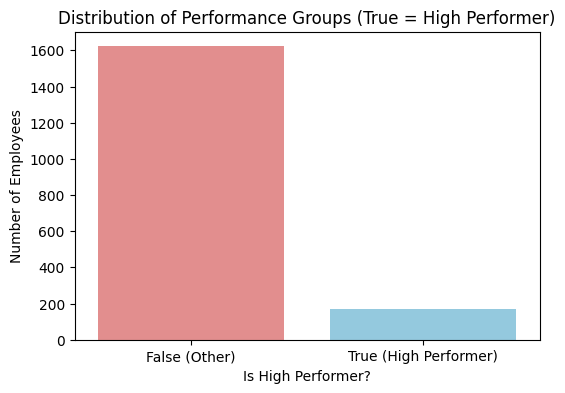


Target Variable Distribution:
is_high_performer
False    1622
True      168
Name: count, dtype: int64

Target Variable Proportions:
is_high_performer
False    0.906145
True     0.093855
Name: proportion, dtype: float64


In [64]:
plt.figure(figsize=(6, 4))

# Create countplot (bar chart of counts)
sns.countplot(data=df_main_EDA, x='is_high_performer', palette=['lightcoral', 'skyblue'])

plt.title('Distribution of Performance Groups (True = High Performer)')
plt.xlabel('Is High Performer?')
plt.ylabel('Number of Employees')
plt.xticks([0, 1], ['False (Other)', 'True (High Performer)']) # Add clearer labels
plt.show()

# Also print the exact numbers/proportions
print("\nTarget Variable Distribution:")
print(df_main_EDA['is_high_performer'].value_counts())
print("\nTarget Variable Proportions:")
print(df_main_EDA['is_high_performer'].value_counts(normalize=True))

The visualization and value counts clearly show a significant **class imbalance** in the target variable. High Performers (`is_high_performer = True`) constitute only **~9.4%** of the analyzed dataset, while the 'Other' group (`is_high_performer = False`) makes up the remaining **~90.6%**.

**Implication for Analysis:** This imbalance must be kept in mind when interpreting subsequent comparisons. Differences observed between the groups should ideally be substantial to be considered meaningful, as the smaller size of the High Performer group makes it more susceptible to random variation. Comparisons involving categorical features should focus on proportions within each group rather than absolute counts.

### Contextual Factors 

Identify *who* is more likely to achieve high performance based on background and structural factors.  

#### Years of Service in Month

--- Boxplot Comparison ---


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\356060715.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_main_EDA, x='is_high_performer', y='years_of_service_months', palette=['lightcoral', 'skyblue'])


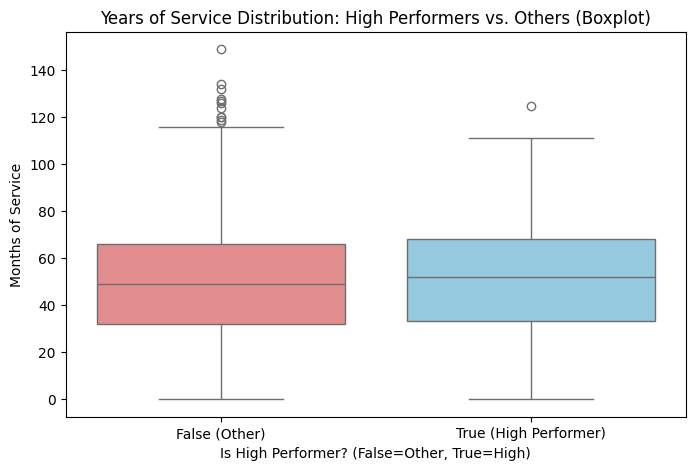


--- Histogram Comparison (Side-by-Side) ---


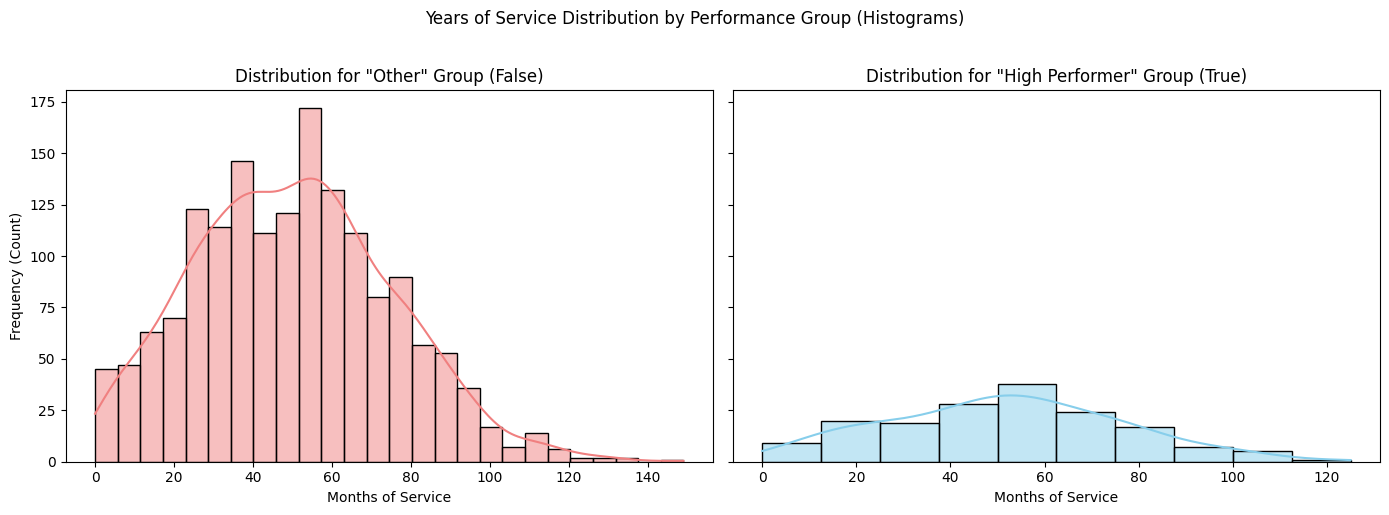


--- Years of Service Statistics by Performance Group ---
                    count       mean        std  min   25%   50%    75%    max
is_high_performer                                                             
False              1622.0  50.201603  25.110208  0.0  32.0  49.0  66.00  149.0
True                168.0  51.517857  24.960801  0.0  33.5  52.0  68.25  125.0


In [65]:
# Compare 'years_of_service_months'

# --- Canvas 1: Boxplot ---
print("--- Boxplot Comparison ---")
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_main_EDA, x='is_high_performer', y='years_of_service_months', palette=['lightcoral', 'skyblue'])
plt.title('Years of Service Distribution: High Performers vs. Others (Boxplot)')
plt.xlabel('Is High Performer? (False=Other, True=High)')
plt.ylabel('Months of Service')
plt.xticks([0, 1], ['False (Other)', 'True (High Performer)']) # Add clearer labels
plt.show()

# --- Canvas 2: Separate Histograms Side-by-Side ---
print("\n--- Histogram Comparison (Side-by-Side) ---")
# Create a figure with 1 row and 2 columns for the subplots
# sharey=True makes the y-axis scale the same for fair comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Histogram 1: 'False' (Other) Group - Plot on the left axes (axes[0])
sns.histplot(data=df_main_EDA[df_main_EDA['is_high_performer'] == False],
             x='years_of_service_months',
             kde=True,
             ax=axes[0], # Specify the left subplot
             color='lightcoral')
axes[0].set_title('Distribution for "Other" Group (False)')
axes[0].set_xlabel('Months of Service')
axes[0].set_ylabel('Frequency (Count)')

# Histogram 2: 'True' (High Performer) Group - Plot on the right axes (axes[1])
sns.histplot(data=df_main_EDA[df_main_EDA['is_high_performer'] == True],
             x='years_of_service_months',
             kde=True,
             ax=axes[1], # Specify the right subplot
             color='skyblue')
axes[1].set_title('Distribution for "High Performer" Group (True)')
axes[1].set_xlabel('Months of Service')
axes[1].set_ylabel('') # Hide redundant y-label on the right

# Add an overall title for the histogram figure
plt.suptitle('Years of Service Distribution by Performance Group (Histograms)', y=1.02)
plt.tight_layout() # Adjust subplot spacing
plt.show() # Show the figure containing both histograms


# --- Descriptive Statistics (remains the same) ---
print("\n--- Years of Service Statistics by Performance Group ---")
# Use describe() to see mean, median (50%), min, max, etc.
print(df_main_EDA.groupby('is_high_performer')['years_of_service_months'].describe())

The descriptive statistics show very **minimal difference** in the distribution of `years_of_service_months` between High Performers (`True`) and Others (`False`).

* **Central Tendency:** The mean (51.5 vs. 50.2 months) and median (52.0 vs. 49.0 months) are only slightly higher for High Performers, suggesting tenure is not drastically different on average.
* **Spread:** The standard deviations are nearly identical (~25 months), indicating a similar level of variation in tenure within both groups.
* **Quartiles:** The 25th and 75th percentiles are also closely aligned.

**Conclusion:** Based on these statistics, which align with the visual similarity observed in the boxplot and histograms, **`years_of_service_months` does not appear to be a strong differentiating factor** for high performance 

#### Education

In [ ]:
# Compare Performance Proportion by Education ---

# Load dimension table for names 
df_education = pd.read_sql(
    """
    SELECT
     education_id, 
     name as education_name 
    FROM dim_education

    """, engine)

# Merge grade names into df_main_EDA
df_analysis_education = df_main_EDA [['employee_id', 'education_id', 'is_high_performer','rating']].merge(df_education, on='education_id', how='left')


--- High Performer Proportion by Education ---
  education_name  is_high_performer
2             S2           0.117647
3            SMA           0.103865
1             S1           0.097130
0             D3           0.058190


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\301489739.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=education_performance, x='education_name', y='is_high_performer', palette='viridis')


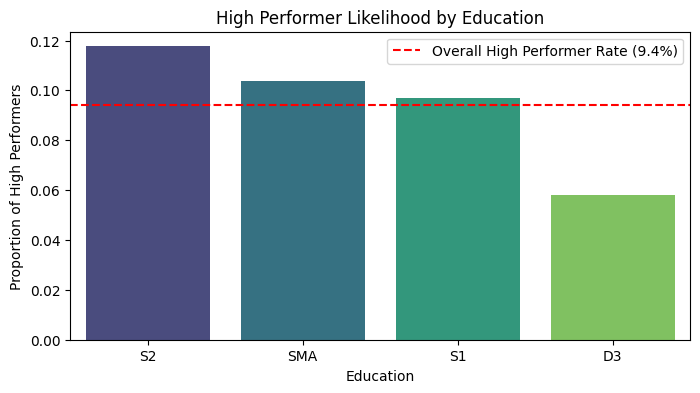

In [67]:
# Calculate proportion of high performers within each education
education_performance = df_analysis_education.groupby('education_name')['is_high_performer'].mean().reset_index()
# Sort by proportion to easily see the trend
education_performance = education_performance.sort_values('is_high_performer', ascending=False)

print("\n--- High Performer Proportion by Education ---")
print(education_performance)

# Visualize the proportion
plt.figure(figsize=(8,4))
sns.barplot(data=education_performance, x='education_name', y='is_high_performer', palette='viridis')

plt.axhline(0.094, color='red', linestyle='--', label='Overall High Performer Rate (9.4%)')
plt.legend()
plt.title('High Performer Likelihood by Education')
plt.xlabel('Education')
plt.ylabel('Proportion of High Performers')
plt.show()



As shown in the visualization above, the **overall high performer rate remains 9.4%** across all employees (indicated by the red dashed line)

- Employees with **higher educational attainment (S2)** tend to have slightly better performance outcomes.  
- Interestingly, **SMA graduates** perform nearly as well as S1, suggesting that **experience or role fit** may offset the lack of formal higher education.
- The difference between S1 and S2 is modest, implying that **education alone is not a strong determinant of high performance**, but may provide a small edge.


Education level shows a **minor positive relationship** with performance, with S2 holders having a marginally higher likelihood of achieving top ratings. However, high performers are distributed across all education levels, highlighting that **practical experience and behavioral competencies** may play a stronger role than formal education credentials.


#### Major 

In [ ]:
# Compare Performance Proportion by Major ---

# Load dimension table for names 
df_majors = pd.read_sql(
    """
    SELECT
     major_id, 
     name as major_name 
    FROM dim_majors

    """, engine)

# Merge grade names into df_main_EDA
df_analysis_majors = df_main_EDA [['employee_id', 'major_id', 'is_high_performer','rating']].merge(df_majors, on='major_id', how='left')


--- High Performer Proportion by Major ---
    major_name  is_high_performer
3  Engineering           0.121528
2    Economics           0.113433
5   Statistics           0.087413
0     Business           0.087108
1       Design           0.083624
4   Psychology           0.068404


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\657042758.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=major_performance, x='major_name', y='is_high_performer', palette='viridis')


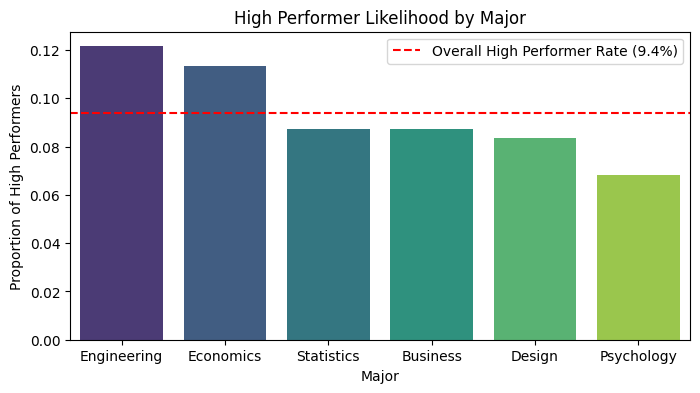

In [69]:
# Calculate proportion of high performers within each major
major_performance = df_analysis_majors.groupby('major_name')['is_high_performer'].mean().reset_index()
# Sort by proportion to easily see the trend
major_performance = major_performance.sort_values('is_high_performer', ascending=False)

print("\n--- High Performer Proportion by Major ---")
print(major_performance)

# Visualize the proportion
plt.figure(figsize=(8,4))
sns.barplot(data=major_performance, x='major_name', y='is_high_performer', palette='viridis')

plt.axhline(0.094, color='red', linestyle='--', label='Overall High Performer Rate (9.4%)')
plt.legend()
plt.title('High Performer Likelihood by Major')
plt.xlabel('Major')
plt.ylabel('Proportion of High Performers')
plt.show()


As shown in the visualization above, the **overall high performer rate is 9.4%** (red dashed line).  
Employees with **Engineering (12.2%)** and **Economics (11.3%)** backgrounds exceed this benchmark, while **Statistics**, **Business**, **Design**, and especially **Psychology (6.8%)** fall below it.

- **Engineering** and **Economics** majors show a higher likelihood of achieving top performance ratings, indicating that **analytical and problem-solving orientations** may be advantageous for success in this organization.  
- In contrast, **Psychology** and **Design** show lower proportions, which may reflect **role-type concentration** or **different performance evaluation criteria** rather than capability differences.  
- The overall variation between majors is **modest (~5 percentage points)**, suggesting that while educational background plays a role, it is **not the sole determinant of high performance**.

Majors emphasizing analytical or structured thinking (Engineering, Economics) appear slightly more associated with high performance. 

#### Job Grade 

In [ ]:
# Compare Performance Proportion by Job Grade ---

# Load dimension table for names 
df_grades = pd.read_sql(
    """
    SELECT
     grade_id, 
     name as grade_name 
    FROM dim_grades

    """, engine)

# Merge grade names into df_main_EDA
df_analysis_grade = df_main_EDA [['employee_id', 'grade_id', 'is_high_performer','rating']].merge(df_grades, on='grade_id', how='left')


--- High Performer Proportion by Job Grade ---
  grade_name  is_high_performer
1         IV           0.105960
2          V           0.088481
0        III           0.086882


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\103645302.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grade_performance, x='grade_name', y='is_high_performer', palette='viridis')


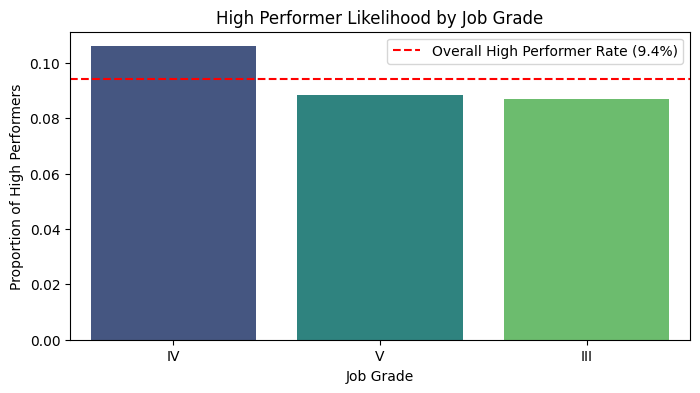

In [71]:
# Calculate proportion of high performers within each grade
grade_performance = df_analysis_grade.groupby('grade_name')['is_high_performer'].mean().reset_index()
# Sort by proportion to easily see the trend
grade_performance = grade_performance.sort_values('is_high_performer', ascending=False)

print("\n--- High Performer Proportion by Job Grade ---")
print(grade_performance)

# Visualize the proportion
plt.figure(figsize=(8,4))
sns.barplot(data=grade_performance, x='grade_name', y='is_high_performer', palette='viridis')

plt.axhline(0.094, color='red', linestyle='--', label='Overall High Performer Rate (9.4%)')
plt.legend()
plt.title('High Performer Likelihood by Job Grade')
plt.xlabel('Job Grade')
plt.ylabel('Proportion of High Performers')
plt.show()



As shown in the visualization above, the **overall high performer rate is 9.4%** across all employees (red dashed line).  
Grade IV stands slightly above this benchmark, with about **10.6%** of its members being high performers, while Grades III and V are slightly below.

- Employees in **Grade IV** appear marginally more likely to achieve top performance ratings.  
- However, the differences are small (less than 2%), suggesting that **grade level alone does not strongly determine performance outcomes**.
- This implies that success is not purely a function of seniority or level, but may instead be shaped by **behavioral, cognitive, or competency-related** factors explored in later sections.

  
**Job grade contributes a mild contextual effect, possibly reflecting differences in experience or scope of responsibility, but it is not a defining success driver.**


#### Position 

In [ ]:
# Compare Performance Proportion by Position ---

# Load dimension table for names 
df_position = pd.read_sql(
    """
    SELECT
     position_id, 
     name as position_name 
    FROM dim_positions

    """, engine)

# Merge grade names into df_main_EDA
df_analysis_position = df_main_EDA [['employee_id', 'position_id', 'is_high_performer','rating']].merge(df_position, on='position_id', how='left')


--- High Performer Proportion by Position ---
      position_name  is_high_performer
0   Brand Executive           0.087413
1      Data Analyst           0.093645
2   Finance Officer           0.103560
3              HRBP           0.090062
4  Sales Supervisor           0.130584
5    Supply Planner           0.056537


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\3282600972.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=postiion_performance, x='position_name', y='is_high_performer', palette='viridis')


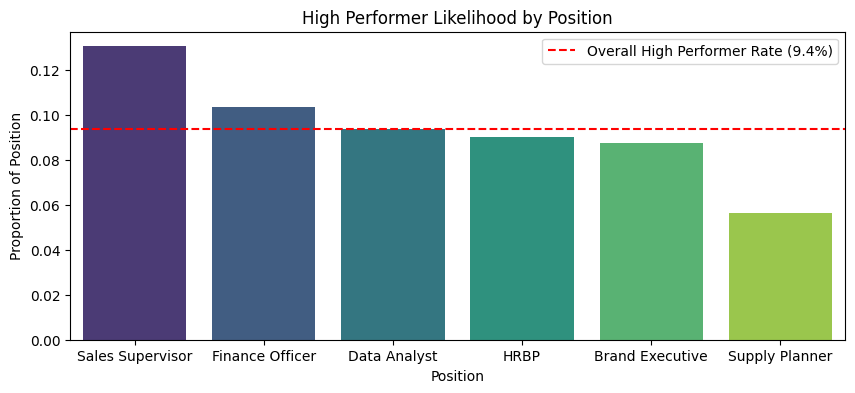

In [73]:
# Calculate proportion of high performers within each position
position_performance = df_analysis_position.groupby('position_name')['is_high_performer'].mean().reset_index()
# Sort by proportion to easily see the trend
postiion_performance = position_performance.sort_values('is_high_performer', ascending=False)

print("\n--- High Performer Proportion by Position ---")
print(position_performance)

# Visualize the proportion
plt.figure(figsize=(10,4))
sns.barplot(data=postiion_performance, x='position_name', y='is_high_performer', palette='viridis')

plt.axhline(0.094, color='red', linestyle='--', label='Overall High Performer Rate (9.4%)')
plt.legend()
plt.title('High Performer Likelihood by Position')
plt.xlabel('Position')
plt.ylabel('Proportion of Position')
plt.show()



As shown in the visualization above, the **overall high performer rate is 9.4%** across all employees (red dashed line).  

- The data suggests that **roles with direct business impact and measurable KPIs (e.g., Sales, Finance)** tend to have higher proportions of high performers.  
- Meanwhile, roles that are **process-oriented or support-heavy** (e.g., Supply Planning, HRBP) show fewer top ratings, potentially due to **subjective performance measures or less visibility of impact**.


**Job position appears to meaningfully influence high performance likelihood**, reflecting how the **nature of work and performance measurability** affect employee evaluations.  
This insight hints that **success in this organization is more strongly tied to output-driven roles** rather than support or operational ones.


#### Departments 

In [ ]:
# Compare Performance Proportion by Department ---

# Load dimension table for names 
df_department = pd.read_sql(
    """
    SELECT
     department_id, 
     name as department_name 
    FROM dim_departments

    """, engine)

# Merge grade names into df_main_EDA
df_analysis_department= df_main_EDA [['employee_id', 'department_id', 'is_high_performer','rating']].merge(df_department, on='department_id', how='left')


--- High Performer Proportion by Department---
  department_name  is_high_performer
2              IT           0.116719
4      Operations           0.108280
5             R&D           0.096886
3       Marketing           0.094276
0         Finance           0.086505
1              HR           0.056338


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\1172149651.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=department_performance, x='department_name', y='is_high_performer', palette='viridis')


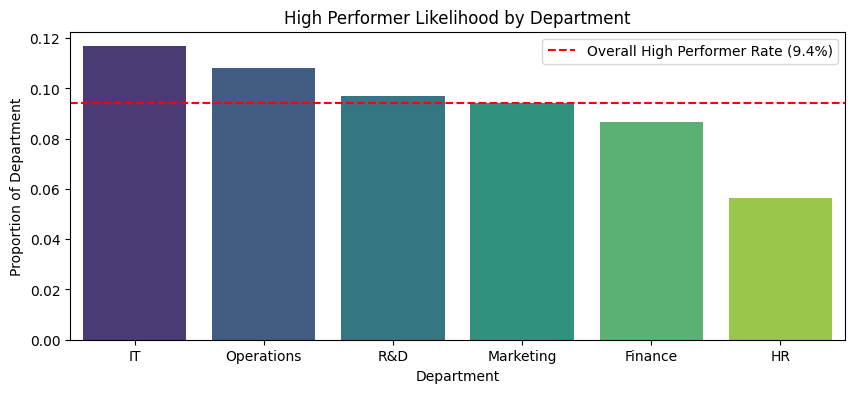

In [75]:
# Calculate proportion of high performers within each department
department_performance = df_analysis_department.groupby('department_name')['is_high_performer'].mean().reset_index()
# Sort by proportion to easily see the trend
department_performance = department_performance.sort_values('is_high_performer', ascending=False)

print("\n--- High Performer Proportion by Department---")
print(department_performance)

# Visualize the proportion
plt.figure(figsize=(10,4))
sns.barplot(data=department_performance, x='department_name', y='is_high_performer', palette='viridis')

plt.axhline(0.094, color='red', linestyle='--', label='Overall High Performer Rate (9.4%)')
plt.legend()
plt.title('High Performer Likelihood by Department')
plt.xlabel('Department')
plt.ylabel('Proportion of Department')
plt.show()


As shown in the visualization above, the **overall high performer rate is 9.4%** (red dashed line).  
Across departments, the differences are more noticeable than in education or job grade:

- The variation among departments indicates that **functional context strongly affects performance evaluation**.  
- Departments with **technical or operational focus (e.g., IT, Operations)** may have clearer performance criteria and metrics, leading to higher observed ratings.  
- Conversely, **support or people-focused departments (e.g., HR)** may face **subjective assessment or less quantifiable impact**, which lowers their representation among top performers.





#### Divisions 

In [ ]:
# Compare Performance Proportion by Division ---

# Load dimension table for names 
df_division = pd.read_sql(
    """
    SELECT
     division_id, 
     name as division_name 
    FROM dim_divisions

    """, engine)

# Merge grade names into df_main_EDA
df_analysis_division= df_main_EDA [['employee_id', 'division_id', 'is_high_performer','rating']].merge(df_division, on='division_id', how='left')


--- High Performer Proportion by Division---
       division_name  is_high_performer
4  Talent Management           0.100559
2        Product Dev           0.098039
3              Sales           0.092141
0  Digital Marketing           0.090909
1         Operations           0.087571


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\998776682.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=division_performance, x='division_name', y='is_high_performer', palette='viridis')


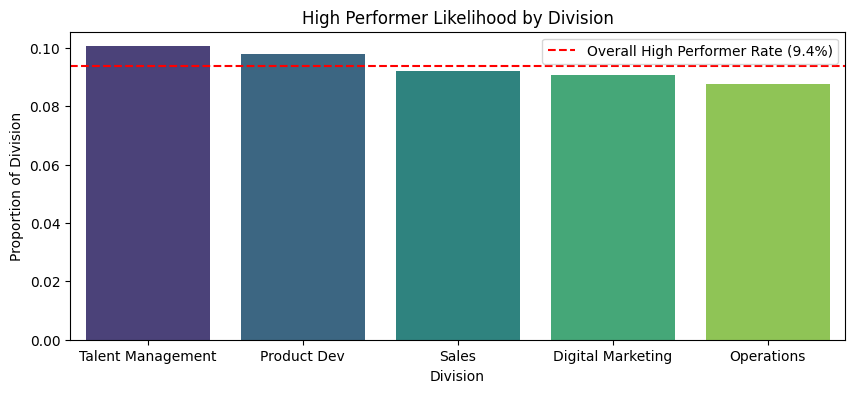

In [77]:
# Calculate proportion of high performers within each division
division_performance = df_analysis_division.groupby('division_name')['is_high_performer'].mean().reset_index()
# Sort by proportion to easily see the trend
division_performance = division_performance.sort_values('is_high_performer', ascending=False)

print("\n--- High Performer Proportion by Division---")
print(division_performance)

# Visualize the proportion
plt.figure(figsize=(10,4))
sns.barplot(data=division_performance, x='division_name', y='is_high_performer', palette='viridis')

plt.axhline(0.094, color='red', linestyle='--', label='Overall High Performer Rate (9.4%)')
plt.legend()
plt.title('High Performer Likelihood by Division')
plt.xlabel('Division')
plt.ylabel('Proportion of Division')
plt.show()


As visualized above, the **overall high performer rate remains 9.4%** across the organization (red dashed line).  
When comparing across divisions, the differences are relatively small  most divisions hover around this benchmark.

- The **Talent Management Division (10.1%)** and **Product Development Division (9.8%)** slightly exceed the company-wide average.  
- Meanwhile, **Operations (8.7%)** and **Digital Marketing (9.1%)** sit marginally below the benchmark.  
- The **Sales Division (9.2%)** aligns very closely with the overall rate, suggesting balanced performance distribution.

While minor variations exist, the overall pattern indicates **no significant division-level disparity in performance outcomes**.


**Division appears to have a limited contextual effect**, meaning that being in a particular division does not strongly predict performance outcomes.  




#### Directorate 

In [ ]:
# Compare Performance Proportion by Directorate ---

# Load dimension table for names 
df_directorate = pd.read_sql(
    """
    SELECT
     directorate_id, 
     name as directorate_name 
    FROM dim_directorates

    """, engine)

# Merge grade names into df_main_EDA
df_analysis_directorate= df_main_EDA [['employee_id', 'directorate_id', 'is_high_performer','rating']].merge(df_directorate, on='directorate_id', how='left')


--- High Performer Proportion by Directorate---
    directorate_name  is_high_performer
2         Technology           0.097946
1  HR & Corp Affairs           0.095638
0         Commercial           0.087344


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\1138338627.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=directorate_performance, x='directorate_name', y='is_high_performer', palette='viridis')


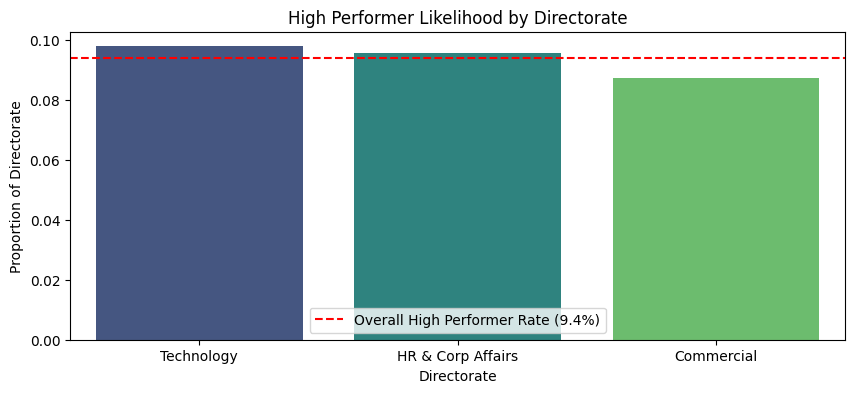

In [79]:
# Calculate proportion of high performers within each directorate
directorate_performance = df_analysis_directorate.groupby('directorate_name')['is_high_performer'].mean().reset_index()
# Sort by proportion to easily see the trend
directorate_performance = directorate_performance.sort_values('is_high_performer', ascending=False)

print("\n--- High Performer Proportion by Directorate---")
print(directorate_performance)

# Visualize the proportion
plt.figure(figsize=(10,4))
sns.barplot(data=directorate_performance, x='directorate_name', y='is_high_performer', palette='viridis')

plt.axhline(0.094, color='red', linestyle='--', label='Overall High Performer Rate (9.4%)')
plt.legend()
plt.title('High Performer Likelihood by Directorate')
plt.xlabel('Directorate')
plt.ylabel('Proportion of Directorate')
plt.show()


The visualization above compares the proportion of high performers across directorates, with the **overall benchmark of 9.4%** shown by the red dashed line.

- Employees within the **Technology Directorate (9.8%)** and **HR & Corporate Affairs Directorate (9.6%)** sit **slightly above the overall company average**.  
- The **Commercial Directorate (8.7%)**, meanwhile, falls slightly below the benchmark.

These differences are relatively **narrow (around ±1%)**, suggesting that **performance likelihood is fairly consistent across directorates**.  

 
The **Directorate factor has limited discriminative power** in explaining performance variation.  



#### Company 

In [ ]:
# Compare Performance Proportion by Company ---

# Load dimension table for names 
df_company = pd.read_sql(
    """
    SELECT
     company_id, 
     name as company_name 
    FROM dim_companies

    """, engine)

# Merge grade names into df_main_EDA
df_analysis_company= df_main_EDA [['employee_id', 'company_id', 'is_high_performer','rating']].merge(df_company, on='company_id', how='left')


--- High Performer Proportion by Company---
                     company_name  is_high_performer
3               PT VASKA Wellness           0.103376
2  PT Mandala Distribution Center           0.102679
0      PT Aurora Beauty Indonesia           0.095128
1          PT Lumo Cosmetics Asia           0.073227


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\640075973.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=company_performance , x='company_name', y='is_high_performer', palette='viridis')


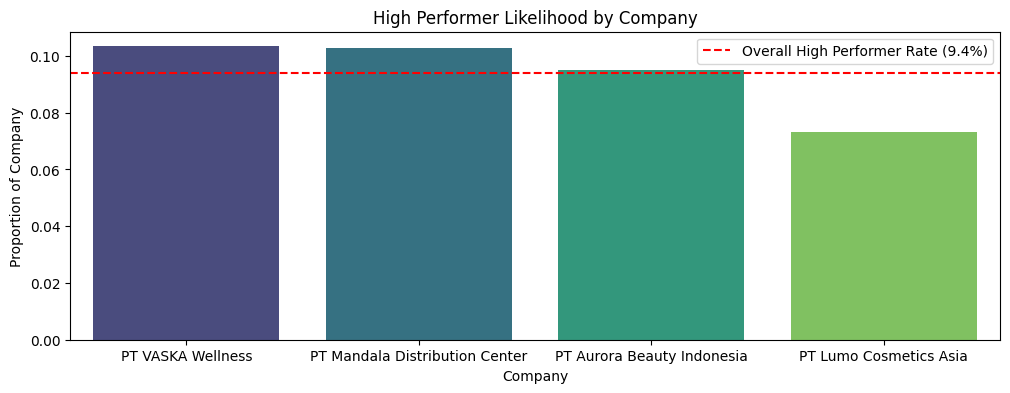

In [81]:
# Calculate proportion of high performers within each Company
company_performance = df_analysis_company.groupby('company_name')['is_high_performer'].mean().reset_index()
# Sort by proportion to easily see the trend
company_performance  = company_performance .sort_values('is_high_performer', ascending=False)

print("\n--- High Performer Proportion by Company---")
print(company_performance )

# Visualize the proportion
plt.figure(figsize=(12,4))
sns.barplot(data=company_performance , x='company_name', y='is_high_performer', palette='viridis')

plt.axhline(0.094, color='red', linestyle='--', label='Overall High Performer Rate (9.4%)')
plt.legend()
plt.title('High Performer Likelihood by Company')
plt.xlabel('Company')
plt.ylabel('Proportion of Company')
plt.show()



The chart above shows the proportion of high performers across the four companies, with the **overall benchmark rate of 9.4%** marked by the red dashed line.

- **PT VASKA Wellness (10.3%)** and **PT Mandala Distribution Center (10.3%)** are **slightly above the company-wide average**, indicating a marginally higher likelihood of producing high performers.  
- **PT Aurora Beauty Indonesia (9.5%)** aligns closely with the benchmark, suggesting a balanced performance distribution.  
- **PT Lumo Cosmetics Asia (7.3%)**, however, shows a noticeably lower proportion of high performers compared to the others.

The variation between companies (~3%) is **moderate**,

Overall, **company affiliation introduces only a mild contextual variation** in performance likelihood.  
This indicates that **organizational culture and systems may influence success slightly**, but **individual capabilities and behavioral or competency factors** remain the dominant drivers of top performance.


#### Areas

In [ ]:
# Compare Performance Proportion by Area ---

# Load dimension table for names 
df_area = pd.read_sql(
    """
    SELECT
     area_id, 
     name as area_name 
    FROM dim_areas

    """, engine)

# Merge grade names into df_main_EDA
df_analysis_area= df_main_EDA [['employee_id', 'area_id', 'is_high_performer','rating']].merge(df_area, on='area_id', how='left')


--- High Performer Proportion by Area---
      area_name  is_high_performer
3         Store           0.121896
1            HQ           0.105634
2         Plant           0.083141
0  Distribution           0.067623


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\2402103888.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=area_performance, x='area_name', y='is_high_performer', palette='viridis')


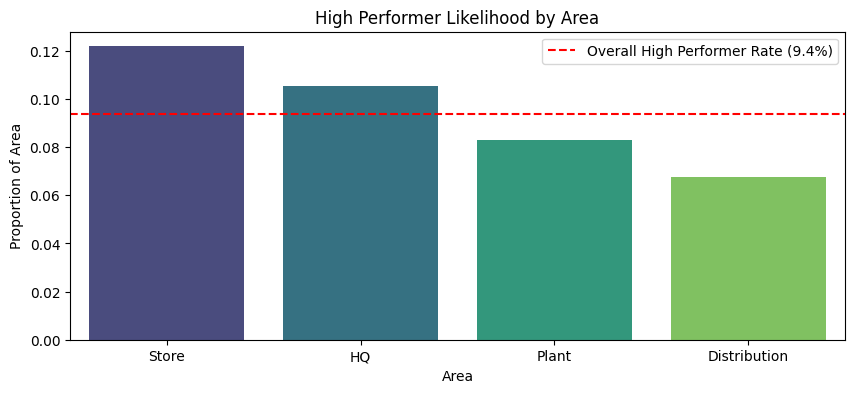

In [83]:
# Calculate proportion of high performers within each area
area_performance = df_analysis_area.groupby('area_name')['is_high_performer'].mean().reset_index()
# Sort by proportion to easily see the trend
area_performance = area_performance.sort_values('is_high_performer', ascending=False)

print("\n--- High Performer Proportion by Area---")
print(area_performance)

# Visualize the proportion
plt.figure(figsize=(10,4))
sns.barplot(data=area_performance, x='area_name', y='is_high_performer', palette='viridis')

plt.axhline(0.094, color='red', linestyle='--', label='Overall High Performer Rate (9.4%)')
plt.legend()
plt.title('High Performer Likelihood by Area')
plt.xlabel('Area')
plt.ylabel('Proportion of Area')
plt.show()


The visualization above compares the proportion of high performers across different working areas, with the **overall benchmark rate of 9.4%** represented by the red dashed line.

- Employees working in **Store areas (12.2%)** show the **highest likelihood** of being high performers.  
- **Headquarters (HQ)** also performs slightly above average at **10.6%**, suggesting relatively strong performance concentration.  
- Meanwhile, **Plant (8.3%)** and **Distribution (6.8%)** are **below the benchmark**, indicating fewer high performers in these environments.

This pattern suggests that **role context and operational nature** significantly affect performance outcomes.  
  
- The **Store** environment appears to foster higher engagement or clearer output-based evaluations, aligning with its performance-driven structure.  
- The lower rates in **Plant** and **Distribution** might reflect operational workload, limited growth opportunities, or lower exposure to performance-based initiatives.  
 
**Work area influences performance likelihood moderately**, where **Store and HQ employees** tend to perform better relative to operational areas.  
This highlights that **environmental and structural factors such as task visibility, performance culture, and feedback mechanisms may play a contextual role in driving success.**


#### Conclusion

Having thoroughly examined the contextual factors,  while elements like work area, department, and educational background show some correlation, they do not fully explain why certain employees achieve top performance ratings. The limited influence of these external factors strongly suggests that **intrinsic individual attributes are likely the primary drivers of success.**

Therefore, the next critical step in our investigation is to analyze the **Psychometric Profiles**. This involves exploring cognitive scores (`iq`, `gtq_total`, `pauli`, `faxtor`,`tiki`), personality/behavioral styles (`mbti`, `disc`), and work preferences (`papi_scores`) to identify specific internal traits that significantly differentiate High Performers from their peers.

### Psychometric profiles 

Having seen that external factors (context) have only a **moderate influence**,  investigate individual internal factors is conducted. The goal is to identify whether there are significant differences in cognitive abilities (such as IQ, GTQ) or behavioral/personality style preferences (such as MBTI, DISC, PAPI) between the High Performers and Other groups.

#### Descriptive and Distribution  Cognitive Comparison

C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\1080939711.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_analysis_cognitive = df_main_EDA[df_main['department_id'] != 4].copy()
C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\1080939711.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analysis_cognitive, x='is_high_performer', y='iq', palette=['lightcoral', 'skyblue'])


Analyzing cognitive scores using 1493 employees (excluding Dept 4).


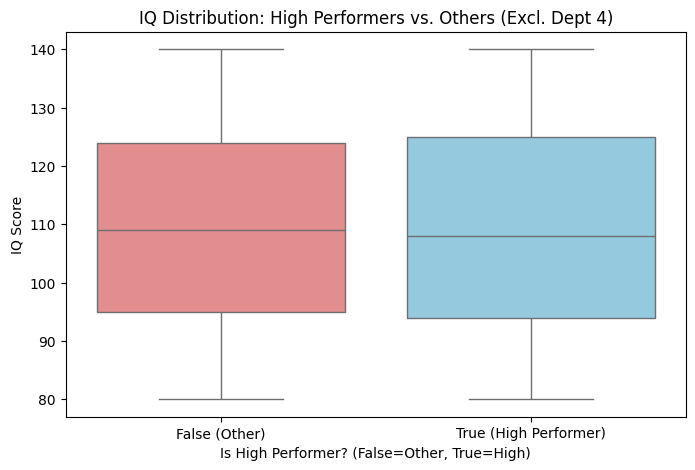


--- IQ Statistics by Performance Group (Excl. Dept 4) ---
                    count        mean        std   min   25%    50%    75%  \
is_high_performer                                                            
False              1353.0  109.507391  17.214255  80.0  95.0  109.0  124.0   
True                140.0  109.050000  17.866441  80.0  94.0  108.0  125.0   

                     max  
is_high_performer         
False              140.0  
True               140.0  


In [84]:
# Cognitive Score - IQ 

# --- IMPORTANT: Exclude Department 4 due to missing data ---
df_analysis_cognitive = df_main_EDA[df_main['department_id'] != 4].copy()
print(f"Analyzing cognitive scores using {len(df_analysis_cognitive)} employees (excluding Dept 4).")

#  Boxplot Comparison 
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_analysis_cognitive, x='is_high_performer', y='iq', palette=['lightcoral', 'skyblue'])
plt.title('IQ Distribution: High Performers vs. Others (Excl. Dept 4)')
plt.xlabel('Is High Performer? (False=Other, True=High)')
plt.ylabel('IQ Score')
plt.xticks([0, 1], ['False (Other)', 'True (High Performer)'])
plt.show()

# Descriptive Statistics
print("\n--- IQ Statistics by Performance Group (Excl. Dept 4) ---")
print(df_analysis_cognitive.groupby('is_high_performer')['iq'].describe())

In [85]:
# T-test for statistical significance
from scipy.stats import ttest_ind

group_true = df_analysis_cognitive[df_analysis_cognitive['is_high_performer'] == True]['iq']
group_false = df_analysis_cognitive[df_analysis_cognitive['is_high_performer'] == False]['iq']
t_stat, p_value = ttest_ind(group_true, group_false, equal_var=False) # Welch's t-test
print(f"\nWelch's T-test for IQ: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("The difference in mean IQ is statistically significant (p < 0.05).")
else:
    print("The difference in mean IQ is not statistically significant (p >= 0.05).")


Welch's T-test for IQ: p-value = 0.7727
The difference in mean IQ is not statistically significant (p >= 0.05).


* **Statistics:** The descriptive statistics show **almost identical** mean (109.1 vs. 109.5) and median (108.0 vs. 109.0) IQ scores for High Performers (`True`) and Others (`False`) when excluding Department 4. The spread (standard deviation) is also very similar.
* **Significance:** Welch's T-test yielded a **p-value of 0.7727**, which is far greater than the conventional threshold of 0.05. This indicates that the observed small difference in mean IQ is **not statistically significant**.
* **Visualization:** The boxplot visually confirms the substantial overlap in distributions between the two groups.

**Conclusion (IQ):** Based on this analysis (excluding Department 4), **IQ does not appear to be a significant differentiator** for high performance in this dataset.

*(Note: The exclusion of Department 4 due to missing data is a limitation for both IQ and GTQ analyses).*

Analyzing cognitive scores using 1493 employees (excluding Dept 4).


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\38527183.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_analysis_cognitive = df_main_EDA[df_main['department_id'] != 4].copy()
C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\38527183.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analysis_cognitive, x='is_high_performer', y='gtq', palette=['lightcoral', 'skyblue'])


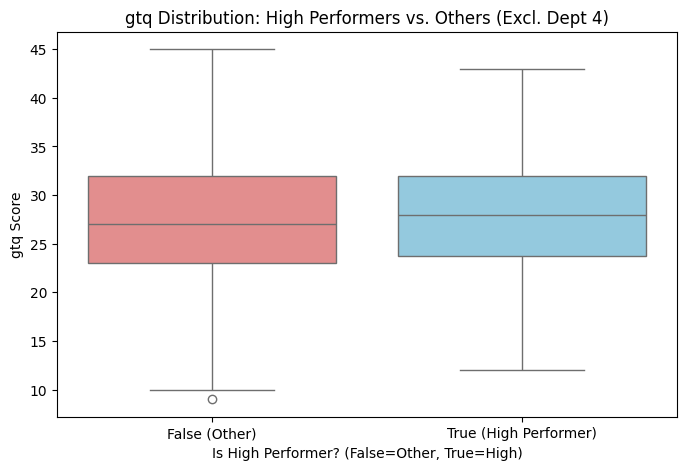


--- gtq Statistics by Performance Group (Excl. Dept 4) ---
                    count       mean       std   min    25%   50%   75%   max
is_high_performer                                                            
False              1353.0  27.352550  6.255816   9.0  23.00  27.0  32.0  45.0
True                140.0  28.221429  6.564640  12.0  23.75  28.0  32.0  43.0


In [86]:
# Cognitive Score - gtq

# --- IMPORTANT: Exclude Department 4 due to missing data ---
df_analysis_cognitive = df_main_EDA[df_main['department_id'] != 4].copy()
print(f"Analyzing cognitive scores using {len(df_analysis_cognitive)} employees (excluding Dept 4).")

#  Boxplot Comparison 
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_analysis_cognitive, x='is_high_performer', y='gtq', palette=['lightcoral', 'skyblue'])
plt.title('gtq Distribution: High Performers vs. Others (Excl. Dept 4)')
plt.xlabel('Is High Performer? (False=Other, True=High)')
plt.ylabel('gtq Score')
plt.xticks([0, 1], ['False (Other)', 'True (High Performer)'])
plt.show()

# Descriptive Statistics
print("\n--- gtq Statistics by Performance Group (Excl. Dept 4) ---")
print(df_analysis_cognitive.groupby('is_high_performer')['gtq'].describe())

In [87]:
# T-test for statistical significance
group_true = df_analysis_cognitive[df_analysis_cognitive['is_high_performer'] == True]['gtq']
group_false = df_analysis_cognitive[df_analysis_cognitive['is_high_performer'] == False]['gtq']
t_stat, p_value = ttest_ind(group_true, group_false, equal_var=False) # Welch's t-test
print(f"\nWelch's T-test for gtq: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("The difference in mean gtq is statistically significant (p < 0.05).")
else:
    print("The difference in mean gtq is not statistically significant (p >= 0.05).")


Welch's T-test for gtq: p-value = 0.1362
The difference in mean gtq is not statistically significant (p >= 0.05).


* **Statistics:** High Performers (`True`) show **slightly higher** mean (28.2 vs. 27.4) and median (28.0 vs. 27.0) `gtq_total` scores compared to Others (`False`), again excluding Department 4. However, the difference is small, less than one point on average. Standard deviations are similar.
* **Significance:** Welch's T-test resulted in a **p-value of 0.1362**, which is greater than 0.05. This suggests that the observed difference in mean `gtq_total`, while present, is **not statistically significant**.
* **Visualization:** The boxplot reflects this slight upward shift for the High Performer group, but with considerable overlap in the distributions.

**Conclusion (GTQ Total):** While there might be a very weak tendency for High Performers to have slightly higher GTQ scores, the difference is minor and **not statistically significant** in this dataset (excluding Department 4). Therefore, `gtq_total` also **does not appear to be a strong differentiating factor**.

*(Note: The exclusion of Department 4 due to missing data is a limitation for both IQ and GTQ analyses).*

C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\1361978815.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_main_EDA, x='is_high_performer', y='faxtor', palette=['lightcoral', 'skyblue'])


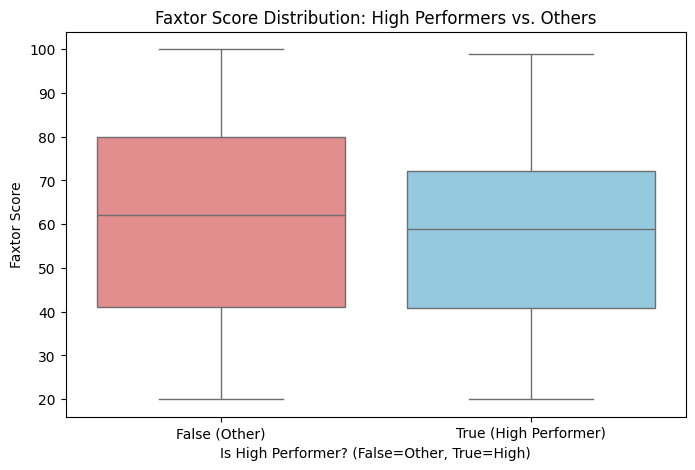


--- Faxtor Score Statistics by Performance Group ---
                    count       mean        std   min    25%   50%    75%  \
is_high_performer                                                           
False              1622.0  60.608508  22.949780  20.0  41.00  62.0  80.00   
True                168.0  58.023810  21.057365  20.0  40.75  59.0  72.25   

                     max  
is_high_performer         
False              100.0  
True                99.0  


In [88]:
# Cognitive Score - Faxtor

# --- Boxplot Comparison ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_main_EDA, x='is_high_performer', y='faxtor', palette=['lightcoral', 'skyblue'])
plt.title('Faxtor Score Distribution: High Performers vs. Others')
plt.xlabel('Is High Performer? (False=Other, True=High)')
plt.ylabel('Faxtor Score')
plt.xticks([0, 1], ['False (Other)', 'True (High Performer)'])
plt.show()

# --- Descriptive Statistics ---
print("\n--- Faxtor Score Statistics by Performance Group ---")
print(df_main_EDA.groupby('is_high_performer')['faxtor'].describe())

In [89]:
# T-test for statistical significance ---

group_true_faxtor = df_main_EDA[df_main_EDA['is_high_performer'] == True]['faxtor']
group_false_faxtor = df_main_EDA[df_main_EDA['is_high_performer'] == False]['faxtor']
# Check if both groups have data
if not group_true_faxtor.empty and not group_false_faxtor.empty:
     t_stat_faxtor, p_value_faxtor = ttest_ind(group_true_faxtor, group_false_faxtor, equal_var=False, nan_policy='omit') # Welch's t-test
     print(f"\nWelch's T-test for Faxtor Score: p-value = {p_value_faxtor:.4f}")
     if p_value_faxtor < 0.05:
         print("The difference in mean Faxtor Score is statistically significant (p < 0.05).")
     else:
         print("The difference in mean Faxtor Score is not statistically significant (p >= 0.05).")
else:
     print("\nCould not perform t-test for Faxtor Score (one or both groups might be empty).")


Welch's T-test for Faxtor Score: p-value = 0.1348
The difference in mean Faxtor Score is not statistically significant (p >= 0.05).


* **Statistics:** The descriptive statistics indicate that High Performers (`True`) have slightly **lower** mean (58.0 vs. 60.6) and median (59.0 vs. 62.0) `faxtor` scores compared to the 'Other' group (`False`). The standard deviations are similar.
* **Significance:** Welch's T-test yielded a **p-value of 0.1348** (greater than 0.05), confirming that the observed difference in mean `faxtor` scores is **not statistically significant**.
* **Visualization:** The boxplot visually supports this, showing considerable overlap between the two groups, with the median for High Performers appearing marginally lower.

**Conclusion (Faxtor):** Based on this analysis, **`faxtor` score does not appear to be a significant differentiator** for high performance in this dataset.

C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\991688673.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_main_EDA, x='is_high_performer', y='pauli', palette=['lightcoral', 'skyblue'])


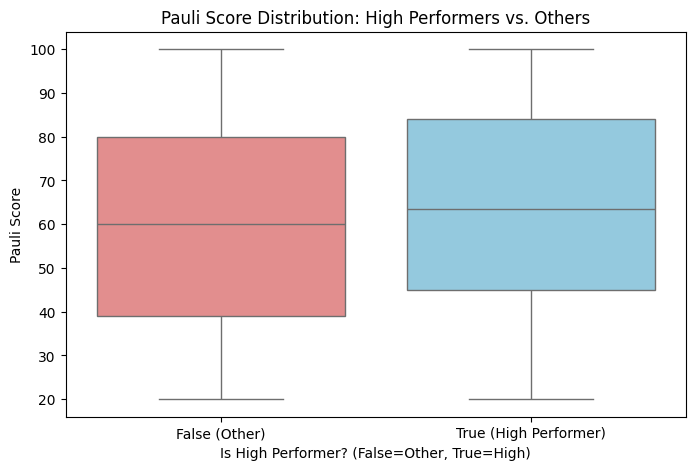


--- Pauli Score Statistics by Performance Group ---
                    count       mean        std   min   25%   50%   75%    max
is_high_performer                                                             
False              1622.0  59.799630  23.431787  20.0  39.0  60.0  80.0  100.0
True                168.0  63.357143  23.053514  20.0  45.0  63.5  84.0  100.0


In [90]:
# Cognitive Score - Pauli 

# --- Boxplot Comparison ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_main_EDA, x='is_high_performer', y='pauli', palette=['lightcoral', 'skyblue'])
plt.title('Pauli Score Distribution: High Performers vs. Others')
plt.xlabel('Is High Performer? (False=Other, True=High)')
plt.ylabel('Pauli Score')
plt.xticks([0, 1], ['False (Other)', 'True (High Performer)'])
plt.show()

# --- Descriptive Statistics ---
print("\n--- Pauli Score Statistics by Performance Group ---")
print(df_main_EDA.groupby('is_high_performer')['pauli'].describe())

In [91]:
#  T-test for statistical significance 
group_true_pauli = df_main_EDA[df_main_EDA['is_high_performer'] == True]['pauli']
group_false_pauli = df_main_EDA[df_main_EDA['is_high_performer'] == False]['pauli']
# Check if both groups have data before running t-test
if not group_true_pauli.empty and not group_false_pauli.empty:
    t_stat_pauli, p_value_pauli = ttest_ind(group_true_pauli, group_false_pauli, equal_var=False, nan_policy='omit') # Welch's t-test, ignore NaNs if any accidentally remain
    print(f"\nWelch's T-test for Pauli Score: p-value = {p_value_pauli:.4f}")
    if p_value_pauli < 0.05:
        print("The difference in mean Pauli Score is statistically significant (p < 0.05).")
    else:
        print("The difference in mean Pauli Score is not statistically significant (p >= 0.05).")
else:
    print("\nCould not perform t-test for Pauli Score (one or both groups might be empty).")


Welch's T-test for Pauli Score: p-value = 0.0587
The difference in mean Pauli Score is not statistically significant (p >= 0.05).


* **Statistics:** High Performers (`True`) show slightly **higher** mean (63.4 vs. 59.8) and median (63.5 vs. 60.0) `pauli` scores compared to the 'Other' group (`False`). The standard deviations are very similar.
* **Significance:** Welch's T-test resulted in a **p-value of 0.0587**. Although this value is close to the 0.05 threshold, it is still technically **not statistically significant**. This suggests the observed difference might be due to chance, although there is a weak trend.
* **Visualization:** The boxplot reflects this slight upward shift in the distribution for High Performers, but also shows substantial overlap with the 'Other' group.

**Conclusion (Pauli):** While there is a weak tendency for High Performers to score slightly higher on the Pauli task, the difference is **not statistically significant (p ≈ 0.06)**. Therefore, `pauli` score is considered **at best a very weak potential differentiator**, likely insufficient to be a major factor in the Success Formula based on this evidence alone.

C:\Users\Fakhri\AppData\Local\Temp\ipykernel_23920\4231919726.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_main_EDA, x='is_high_performer', y='tiki', palette=['lightcoral', 'skyblue'])


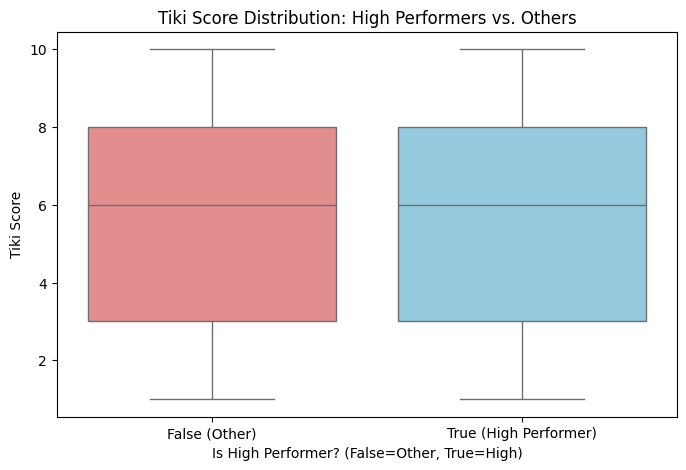


--- Tiki Score Statistics by Performance Group ---
                    count      mean       std  min  25%  50%  75%   max
is_high_performer                                                      
False              1622.0  5.494451  2.899026  1.0  3.0  6.0  8.0  10.0
True                168.0  5.434524  2.812802  1.0  3.0  6.0  8.0  10.0


In [235]:
# Cognitive Score - tiki

# --- Boxplot Comparison ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_main_EDA, x='is_high_performer', y='tiki', palette=['lightcoral', 'skyblue'])
plt.title('Tiki Score Distribution: High Performers vs. Others')
plt.xlabel('Is High Performer? (False=Other, True=High)')
plt.ylabel('Tiki Score')
plt.xticks([0, 1], ['False (Other)', 'True (High Performer)'])
plt.show()

# --- Descriptive Statistics ---
print("\n--- Tiki Score Statistics by Performance Group ---")
print(df_main_EDA.groupby('is_high_performer')['tiki'].describe())

In [237]:
#  T-test for statistical significance 
group_true_pauli = df_main_EDA[df_main_EDA['is_high_performer'] == True]['tiki']
group_false_pauli = df_main_EDA[df_main_EDA['is_high_performer'] == False]['tiki']
# Check if both groups have data before running t-test
if not group_true_pauli.empty and not group_false_pauli.empty:
    t_stat_pauli, p_value_pauli = ttest_ind(group_true_pauli, group_false_pauli, equal_var=False, nan_policy='omit') # Welch's t-test, ignore NaNs if any accidentally remain
    print(f"\nWelch's T-test for tiki Score: p-value = {p_value_pauli:.4f}")
    if p_value_pauli < 0.05:
        print("The difference in mean tiki Score is statistically significant (p < 0.05).")
    else:
        print("The difference in mean tiki Score is not statistically significant (p >= 0.05).")
else:
    print("\nCould not perform t-test for tiki Score (one or both groups might be empty).")


Welch's T-test for tiki Score: p-value = 0.7935
The difference in mean tiki Score is not statistically significant (p >= 0.05).


Calculating correlations for: ['iq', 'gtq', 'pauli', 'faxtor', 'tiki']

--- Correlation Matrix ---
              iq       gtq     pauli    faxtor      tiki
iq      1.000000  0.025686  0.008502 -0.054278  0.029211
gtq     0.025686  1.000000  0.036356 -0.023321 -0.009907
pauli   0.008502  0.036356  1.000000 -0.007824 -0.039349
faxtor -0.054278 -0.023321 -0.007824  1.000000 -0.015534
tiki    0.029211 -0.009907 -0.039349 -0.015534  1.000000


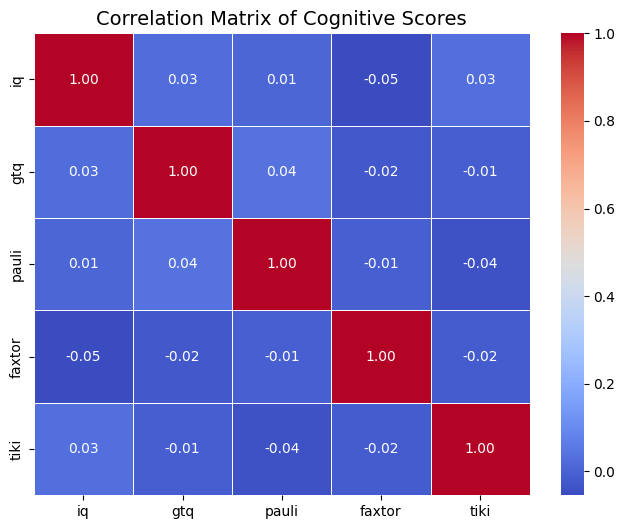

In [236]:
# Analysis: Correlation Between Cognitive Scores

# --- Select Cognitive Score Columns ---
cognitive_cols = ['iq', 'gtq', 'pauli', 'faxtor','tiki'] # Verify 'gtq_total' name

# Check if all columns exist before proceeding
available_cognitive_cols = [col for col in cognitive_cols if col in df_main_EDA.columns]
if len(available_cognitive_cols) < 2:
    print("Not enough cognitive columns available to calculate correlations.")
else:
    print(f"Calculating correlations for: {available_cognitive_cols}")

    # --- Calculate Correlation Matrix ---
    # .corr() automatically handles missing values (like those in Dept 4 for iq/gtq) by pairwise deletion by default
    correlation_matrix = df_main_EDA[available_cognitive_cols].corr()

    print("\n--- Correlation Matrix ---")
    print(correlation_matrix)

    # --- Visualize Heatmap ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix,
                annot=True,        # Show correlation values on the heatmap
                cmap='coolwarm',   # Color map (blue=negative, red=positive)
                fmt=".2f",         # Format numbers to 2 decimal places
                linewidths=.5)     # Add lines between cells
    plt.title('Correlation Matrix of Cognitive Scores', fontsize=14)
    plt.show()

* **Weak Correlations:** The correlation matrix and heatmap show **extremely weak linear relationships** between all pairs of cognitive scores (`iq`, `gtq`, `pauli`, `faxtor`,`tiki`). All correlation coefficients are very close to zero (ranging from -0.054 to +0.036).
* **Distinct Measures:** This indicates that, within this dataset, these four cognitive tests appear to be measuring largely **independent or distinct aspects** of cognitive function. There is no evidence of significant overlap or redundancy between them.

**Conclusion:** Given our earlier finding that none of these scores showed a significant difference between performance groups, this correlation analysis further reinforces that these specific cognitive measures, as a group, might not be the key drivers for high performance in this context.

##### Conclusion (Cognitive Scores)

 The analysis of core cognitive scores (IQ, GTQ Total, Pauli, Faxtor) did not reveal statistically significant differences between High Performers and Others. While minor trends were observed (e.g., slightly higher Pauli scores for high performers), cognitive ability, as measured by these tests, does not appear to be a primary differentiator in this context.

 Since basic cognitive ability doesn't seem to be the key driver, we now shift our focus within the Psychometric Profiles to **personality and behavioral styles**. The next step is to analyze **MBTI** and **DISC** types to see if specific personality preferences or behavioral tendencies are more prevalent among High Performers.


--- MBTI Proportion by Performance Group ---
is_high_performer     False     True 
mbti                                 
ENFP               0.147349  0.178571
ISFP               0.054254  0.089286
ISTP               0.056104  0.077381
ENTP               0.056720  0.077381
ESFJ               0.057337  0.065476
ISTJ               0.054871  0.059524
ENFJ               0.065968  0.059524
ENTJ               0.057953  0.053571
ESTP               0.048089  0.053571
ISFJ               0.054254  0.053571
ESTJ               0.054254  0.047619
INTJ               0.051171  0.041667
INFP               0.062269  0.041667
INTP               0.065968  0.041667
INFJ               0.054871  0.035714
ESFP               0.056720  0.023810
UNKNOWN            0.001850       NaN


<Figure size 1500x700 with 0 Axes>

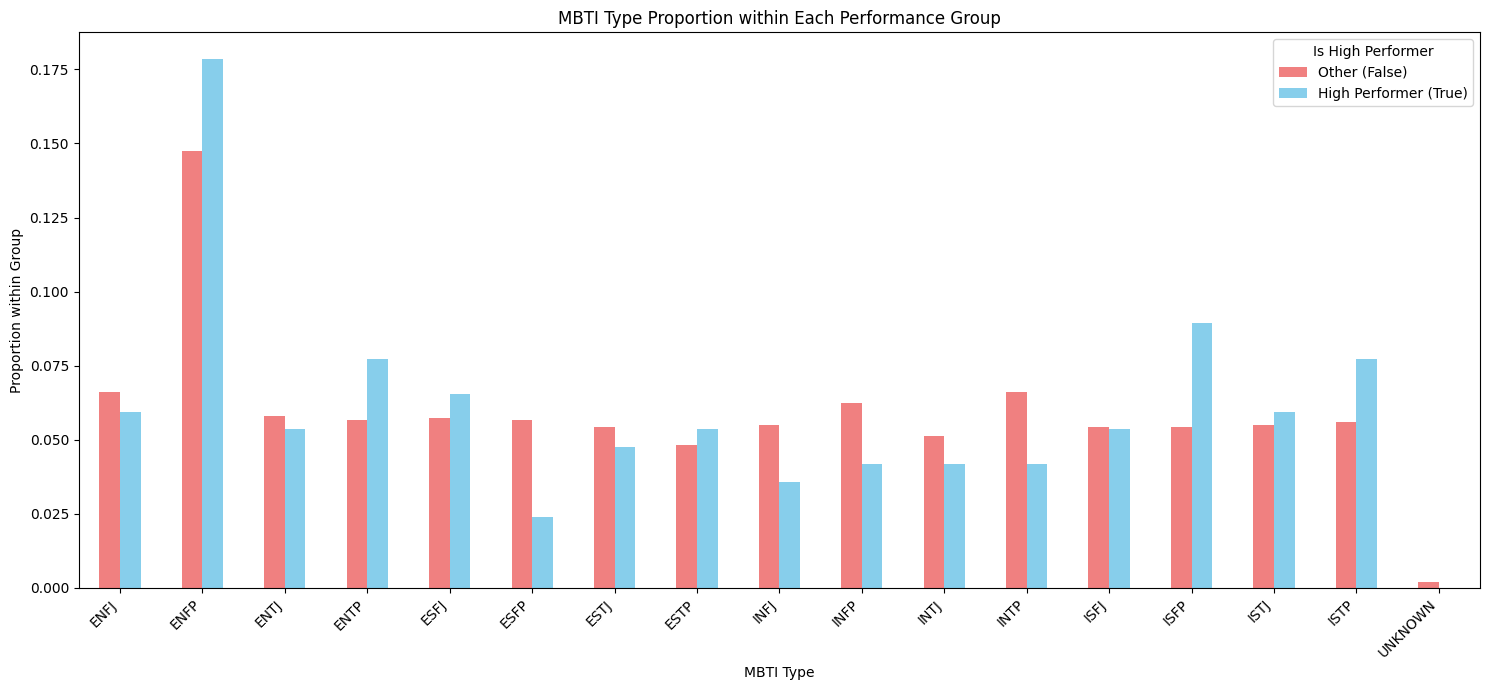


--- MBTI Types with Largest Proportion Difference (Absolute) ---
is_high_performer     False      True  difference
mbti                                             
ISFP               0.054254  0.089286    0.035032
ESFP               0.056720  0.023810    0.032911
ENFP               0.147349  0.178571    0.031222
INTP               0.065968  0.041667    0.024301
ISTP               0.056104  0.077381    0.021277


In [93]:
# --- 5.3 Analysis: Personality Style - MBTI ---

# --- Calculate Proportions ---
mbti_proportions = df_main_EDA.groupby('is_high_performer')['mbti'].value_counts(normalize=True).unstack()

print("\n--- MBTI Proportion by Performance Group ---")
# Transpose for easier plotting (Types on x-axis)
mbti_plot_data = mbti_proportions.T
print(mbti_plot_data.sort_values(by=True, ascending=False)) # Sort by High Performer proportion

# --- Visualize Proportions (Grouped Bar Chart with Custom Colors) ---
plt.figure(figsize=(15, 7))

# Define the custom colors in the order [False_color, True_color]
custom_palette = ['lightcoral', 'skyblue']

# Use the palette argument in sns.barplot or color in df.plot
# Option 1: Using Pandas plot directly (might be easier for this structure)
mbti_plot_data.plot(kind='bar', figsize=(15, 7), color=custom_palette) # Use 'color' for pandas plot

# Option 2: If using Seaborn barplot (requires melting the dataframe first, more complex setup)
# This example uses Pandas plot which is simpler here.

plt.title('MBTI Type Proportion within Each Performance Group')
plt.xlabel('MBTI Type')
plt.ylabel('Proportion within Group')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is High Performer', labels=['Other (False)', 'High Performer (True)']) # Ensure labels match color order
plt.tight_layout() # Adjust layout
plt.show()


# Calculate the absolute difference in proportions
mbti_plot_data['difference'] = (mbti_plot_data[True] - mbti_plot_data[False]).abs()
top_diff_mbti = mbti_plot_data.sort_values(by='difference', ascending=False).head(5) # Get top 5 differences

print("\n--- MBTI Types with Largest Proportion Difference (Absolute) ---")
# Display proportions for False, True, and the absolute difference
print(top_diff_mbti[[False, True, 'difference']])


* **Proportions:** The analysis of MBTI type proportions within each performance group reveals some differences, although no single type dramatically dominates the High Performer (`True`) group. `ENFP` is the most common type in both groups but is slightly more prevalent among High Performers (17.9% vs 14.7%).
* **Key Differences:** The types showing the largest *increase* in proportion among High Performers compared to Others are **`ISFP`** (+3.5%), **`ENFP`** (+3.1%), **`ISTP`** (+2.1%), and **`ENTP`** (+2.1%). Conversely, types like **`ESFP`** (-3.3%), **`INTP`** (-2.4%), **`INFP`** (-2.1%), and **`INFJ`** (-1.9%) are notably *less* prevalent among High Performers.
* **Visualization:** The grouped bar chart visually confirms these moderate shifts in distribution.

**Conclusion (MBTI):** While certain MBTI types (particularly `ISFP`, `ENFP`, `ISTP`, `ENTP`) appear slightly more often among High Performers, and others (like `ESFP`) appear less often, the **differences in proportions are relatively modest**. MBTI type seems to be a **minor influencing factor** rather than a strong differentiator for high performance in this dataset.


--- DISC Proportion by Performance Group ---
is_high_performer     False     True 
disc                                 
SI                 0.087546  0.107143
CD                 0.093095  0.095238
DC                 0.091862  0.095238
CI                 0.094945  0.089286
SD                 0.072750  0.089286
SC                 0.087546  0.089286
ID                 0.077065  0.083333
DI                 0.085697  0.083333
IS                 0.068434  0.083333
DS                 0.074599  0.071429
CS                 0.088163  0.065476
IC                 0.078298  0.047619


<Figure size 1500x700 with 0 Axes>

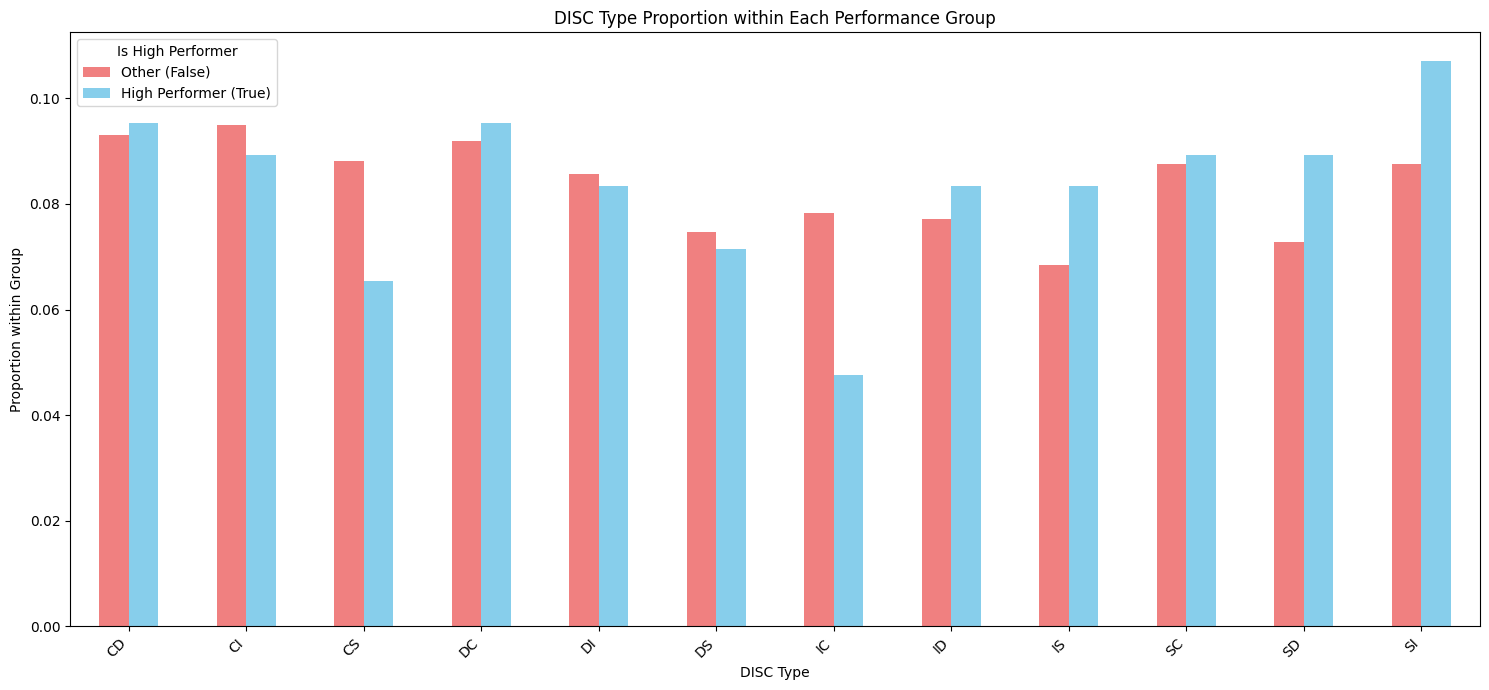


--- DISC Types with Largest Proportion Difference (Absolute) ---
is_high_performer     False      True  difference
disc                                             
IC                 0.078298  0.047619    0.030679
CS                 0.088163  0.065476    0.022687
SI                 0.087546  0.107143    0.019597
SD                 0.072750  0.089286    0.016536
IS                 0.068434  0.083333    0.014899


In [94]:
# Behavioral Style - DISC 

# --- Calculate Proportions ---
# Group by performance status, then count DISC types within each group and normalize
disc_proportions = df_main_EDA.groupby('is_high_performer')['disc'].value_counts(normalize=True).unstack()

print("\n--- DISC Proportion by Performance Group ---")
# Transpose for easier plotting (Types on x-axis)
disc_plot_data = disc_proportions.T
print(disc_plot_data.sort_values(by=True, ascending=False)) # Sort by High Performer proportion


# --- Visualize Proportions (Grouped Bar Chart with Custom Colors) ---
plt.figure(figsize=(15, 7))

# Define the custom colors in the order [False_color, True_color]
# Using the recommended 'skyblue' and 'lightcoral'
custom_palette_disc = ['lightcoral', 'skyblue']

# Use the palette argument in sns.barplot or color in df.plot
# Using Pandas plot directly as it's simpler for this pre-calculated structure
disc_plot_data.plot(kind='bar', figsize=(15, 7), color=custom_palette_disc)

plt.title('DISC Type Proportion within Each Performance Group')
plt.xlabel('DISC Type')
plt.ylabel('Proportion within Group')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is High Performer', labels=['Other (False)', 'High Performer (True)']) # Ensure labels match color order
plt.tight_layout() # Adjust layout
plt.show()

# Calculate the absolute difference in proportions
disc_plot_data['difference'] = (disc_plot_data[True] - disc_plot_data[False]).abs()
top_diff_disc = disc_plot_data.sort_values(by='difference', ascending=False).head(5) # Get top 5 differences

print("\n--- DISC Types with Largest Proportion Difference (Absolute) ---")
# Display proportions for False, True, and the absolute difference
print(top_diff_disc[[False, True, 'difference']])


* **Proportions:** The analysis of DISC type proportions within each performance group indicates moderate variations. No single DISC type overwhelmingly characterizes the High Performer (`True`) group.
* **Key Differences:** Types showing the largest increase in proportion among High Performers include **`SI`** (+2.0%), **`SD`** (+1.7%), and **`IS`** (+1.5%). Conversely, types notably less prevalent among High Performers are **`IC`** (-3.1%) and **`CS`** (-2.3%). Other types show smaller differences.
* **Visualization:** The grouped bar chart visually represents these shifts, confirming the absence of dramatic differences.

**Conclusion (DISC):** Similar to MBTI, DISC type appears to be a **minor influencing factor**. While there's a slight tendency for High Performers to exhibit more S-dominant combinations (`SI`, `SD`, `IS`) and fewer C-dominant ones (`IC`, `CS`), the **differences are modest**. DISC adds some nuance but is unlikely to be a primary driver compared to factors like competencies or potentially more significant behavioral traits.

#### PAPI Scores

In [95]:
# Merge PAPI scores with the main dataframe ---
df_analysis_papi = df_main_EDA[['employee_id', 'is_high_performer']].merge(df_papi_scores_cleaned,on='employee_id',how='inner')


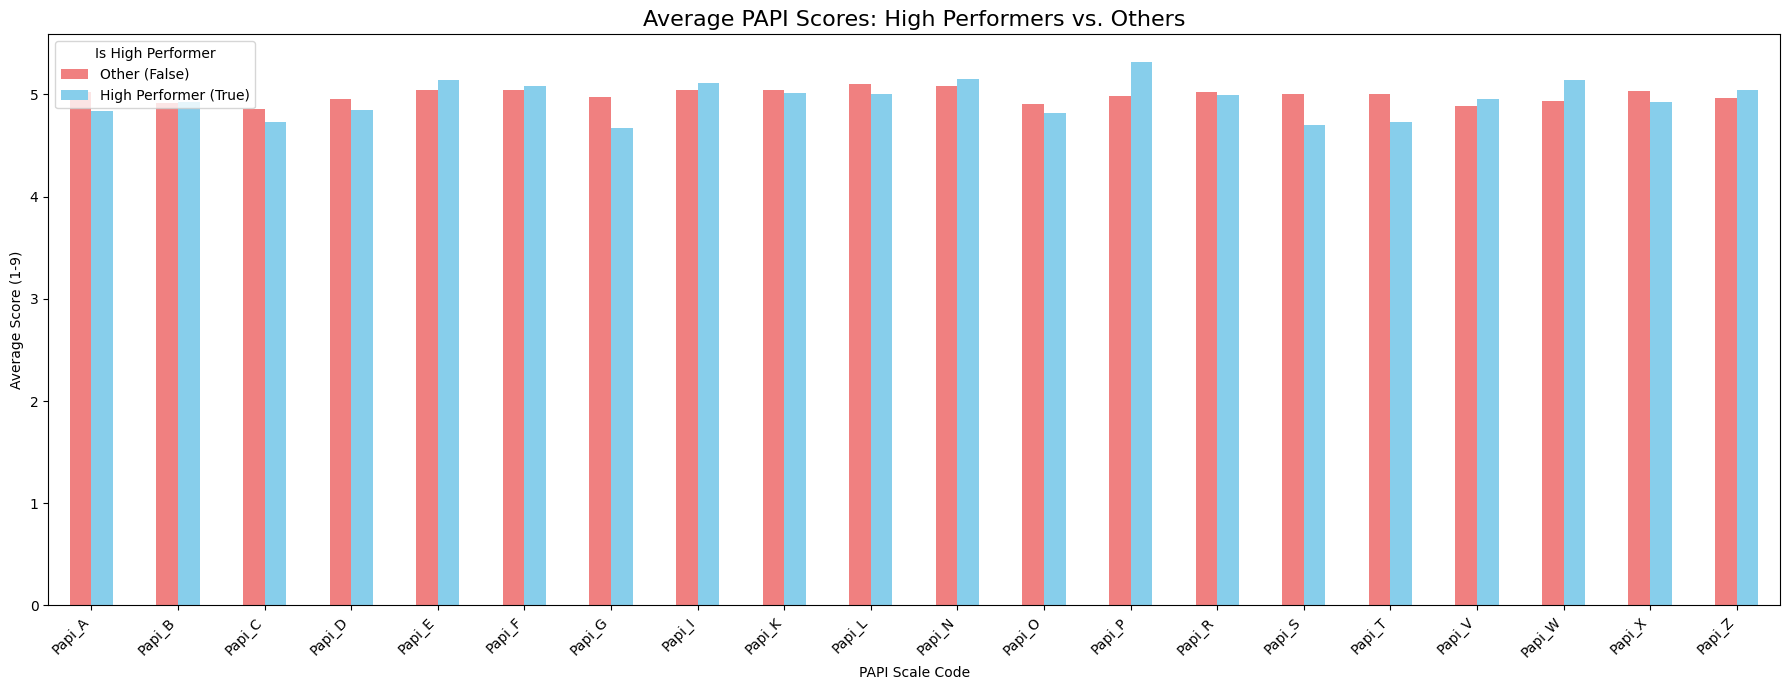


--- PAPI Scales with Largest Average Score Difference (Absolute) ---
is_high_performer     False      True  difference
scale_code                                       
Papi_P             4.985203  5.321429    0.336225
Papi_S             5.008631  4.702381    0.306250
Papi_G             4.973490  4.672619    0.300870
Papi_T             5.003083  4.726190    0.276892
Papi_W             4.937731  5.142857    0.205126


In [96]:
# --- Calculate Average Scores per Scale per Group ---
avg_papi_scores = df_analysis_papi.groupby(['scale_code', 'is_high_performer'])['score'].mean().unstack()

# --- Visualize Comparison (Grouped Bar Chart) ---
custom_palette_papi = ['lightcoral','skyblue'] # False, True
avg_papi_scores.plot(kind='bar', figsize=(18, 7), color=custom_palette_papi)
plt.title('Average PAPI Scores: High Performers vs. Others', fontsize=16)
plt.xlabel('PAPI Scale Code')
plt.ylabel('Average Score (1-9)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is High Performer', labels=['Other (False)', 'High Performer (True)'])
plt.tight_layout()
plt.show()

# --- (Optional) Identify Scales with Largest Differences ---
avg_papi_scores['difference'] = (avg_papi_scores[True] - avg_papi_scores[False]).abs()
top_diff_papi = avg_papi_scores.sort_values(by='difference', ascending=False).head(5)
print("\n--- PAPI Scales with Largest Average Score Difference (Absolute) ---")
print(top_diff_papi[[False, True, 'difference']])

In [97]:
# --- Prepare Data for Radar Chart ---

# 1. Get the scale codes (categories/labels for axes)
# Ensure avg_papi_scores index is 'scale_code'
if 'scale_code' in avg_papi_scores.columns:
     avg_papi_scores = avg_papi_scores.set_index('scale_code') # Set index if not already

labels = avg_papi_scores.index.values
num_vars = len(labels)

# 2. Get the average scores for each group
scores_false = avg_papi_scores[False].values # Scores for 'Other' group
scores_true = avg_papi_scores[True].values   # Scores for 'High Performer' group

# 3. Complete the loop for the radar chart
#    The first value needs to be repeated at the end to close the circle
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] # Repeat first angle

scores_false = np.concatenate((scores_false, [scores_false[0]])) # Repeat first score
scores_true = np.concatenate((scores_true, [scores_true[0]]))     # Repeat first score
labels_looped = np.append(labels, labels[0]) # Repeat first label for plotting tick

* **Small Differences:** The analysis reveals that the average score differences between High Performers (`True`) and Others (`False`) across all PAPI scales are generally **very small**. The largest absolute difference observed is only **0.34 points** (for `Papi_P`) on a 1-9 scale.
* **Top Differing Scales:** The scales with the slightly larger (though still small) differences are `Papi_P` (Need to Finish Task - HP slightly higher), `Papi_S` (Role of Hard Worker - HP slightly lower), `Papi_G` (Need to Work Hard - HP slightly lower), `Papi_T` (Need to Be Organised - HP slightly lower), and `Papi_W` (Need for Rules - HP slightly higher).
* **Visual Confirmation:** The grouped bar chart visually confirms this, showing that the average scores for both groups hover closely around the midpoint (5) for most scales.
* **Inverse Scales Caveat:** It's important to remember the brief's note about potential inverse scales (like Z/K). For such scales, a lower score might indicate a higher preference. However, even considering this, the magnitude of the differences remains small.

**Conclusion (PAPI Scores):** Based on these findings, PAPI scores appear to be **weak differentiators** for high performance in this dataset, the differences are too small to be considered major factors for the Success Formula.

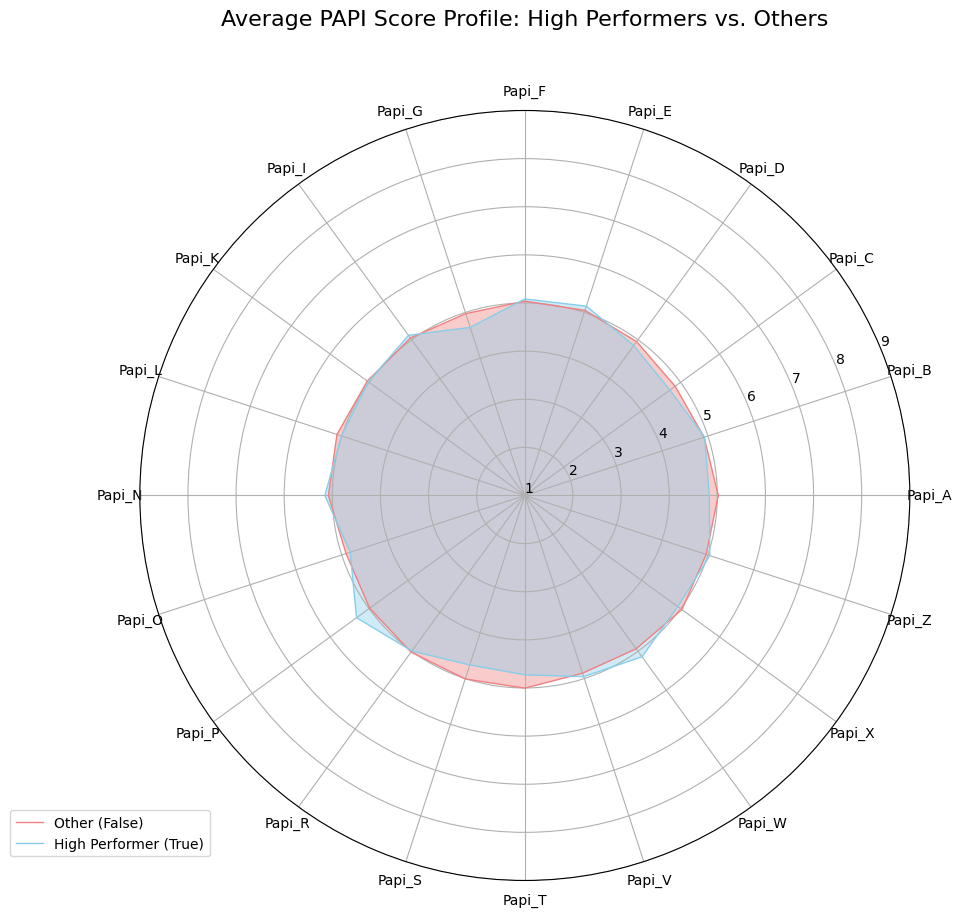

In [98]:
# --- Create Radar Chart ---

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot 'Other' group (False)
ax.plot(angles, scores_false, linewidth=1, linestyle='solid', label='Other (False)', color='lightcoral')
ax.fill(angles, scores_false, 'lightcoral', alpha=0.4)

# Plot 'High Performer' group (True)
ax.plot(angles, scores_true, linewidth=1, linestyle='solid', label='High Performer (True)', color='skyblue')
ax.fill(angles, scores_true, 'skyblue', alpha=0.4)

# --- Customize the Plot ---
# Set the y-axis limits (PAPI scores 1-9)
ax.set_yticks(np.arange(1, 10, 1)) # Ticks from 1 to 9
ax.set_ylim(1, 9)

# Set the category labels on the axes
ax.set_xticks(angles[:-1]) # Use angles without the repeated last one
ax.set_xticklabels(labels)

# Add title and legend
plt.title('Average PAPI Score Profile: High Performers vs. Others', size=16, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

# --- (Optional) Print stats again for reference ---
# print("\n--- Average PAPI Scores by Performance Group ---")
# print(avg_papi_scores)
# print("\n--- PAPI Scales with Largest Average Score Difference (Absolute) ---")
# print(top_diff_papi[[False, True, 'difference']])

* **Overall Similarity:** The radar chart visually confirms that the average PAPI score profiles for High Performers (`True`, skyblue) and Others (`False`, lightcoral) are **very similar**. The two shapes largely overlap.
* **Minor Differences:** While there are slight variations on certain scales (consistent with the previous finding of small differences for `Papi_P`, `S`, `G`, `T`, `W`), no scale shows a dramatic divergence between the two groups. Both groups generally hover around the mid-range scores for most scales.

 The radar chart provides a holistic view that reinforces the earlier conclusion: PAPI scores, based on these average profiles, exhibit **only minor differences** between High Performers and Others. Therefore, PAPI work style preferences appear to be **weak differentiators** for top performance in this dataset.

#### Psychometric Profiles Conclusion

**Conclusion (Psychometric Profiles - Cognitive & Personality):**
The analysis of psychometric profiles yielded mixed but ultimately weak results. Core cognitive scores (`iq`, `gtQ`, `pauli`, `faxtor`) showed **no statistically significant differences** between High Performers and Others. Similarly, while minor variations were observed in MBTI and DISC type distributions, these personality/behavioral styles also **did not emerge as strong differentiators**. The PAPI scores further confirmed this, showing **only minimal differences** in average work style preferences between the groups.

Since neither baseline cognitive abilities nor broad personality/work-style preferences appear to be the primary drivers of high performance in this context, we now turn to a more specific measure of **innate behavioral tendencies: CliftonStrengths**. The next area of exploration in Step 1 is to analyze the **Behavioral Data (`strengths`)**, focusing specifically on the **Top 5 dominant themes**. This analysis aims to identify if particular natural talents or behavioral patterns are significantly more prevalent among High Performers, potentially revealing the key behavioral drivers of success that previous psychometric measures did not capture.

### Behavioral Data (Strengths)

Identify *if* certain innate behavioral tendencies or talents (CliftonStrengths themes), particularly the **Top 5 most dominant ones**, are significantly more prevalent among High Performers compared to Others.

In [391]:
    # --- Merge Top 5 Strengths data with the main dataframe ---
# Ensure df_top5_analysis_ready is prepared (excluding employees with missing top 5)
df_analysis_strengths = df_main_EDA[['employee_id', 'is_high_performer']].merge(df_top5_analysis_strength,on='employee_id',how='inner' )# Use inner join
print(f"Merged Top 5 Strengths data ready for analysis with {df_analysis_strengths['employee_id'].nunique()} employees.")

Merged Top 5 Strengths data ready for analysis with 1176 employees.


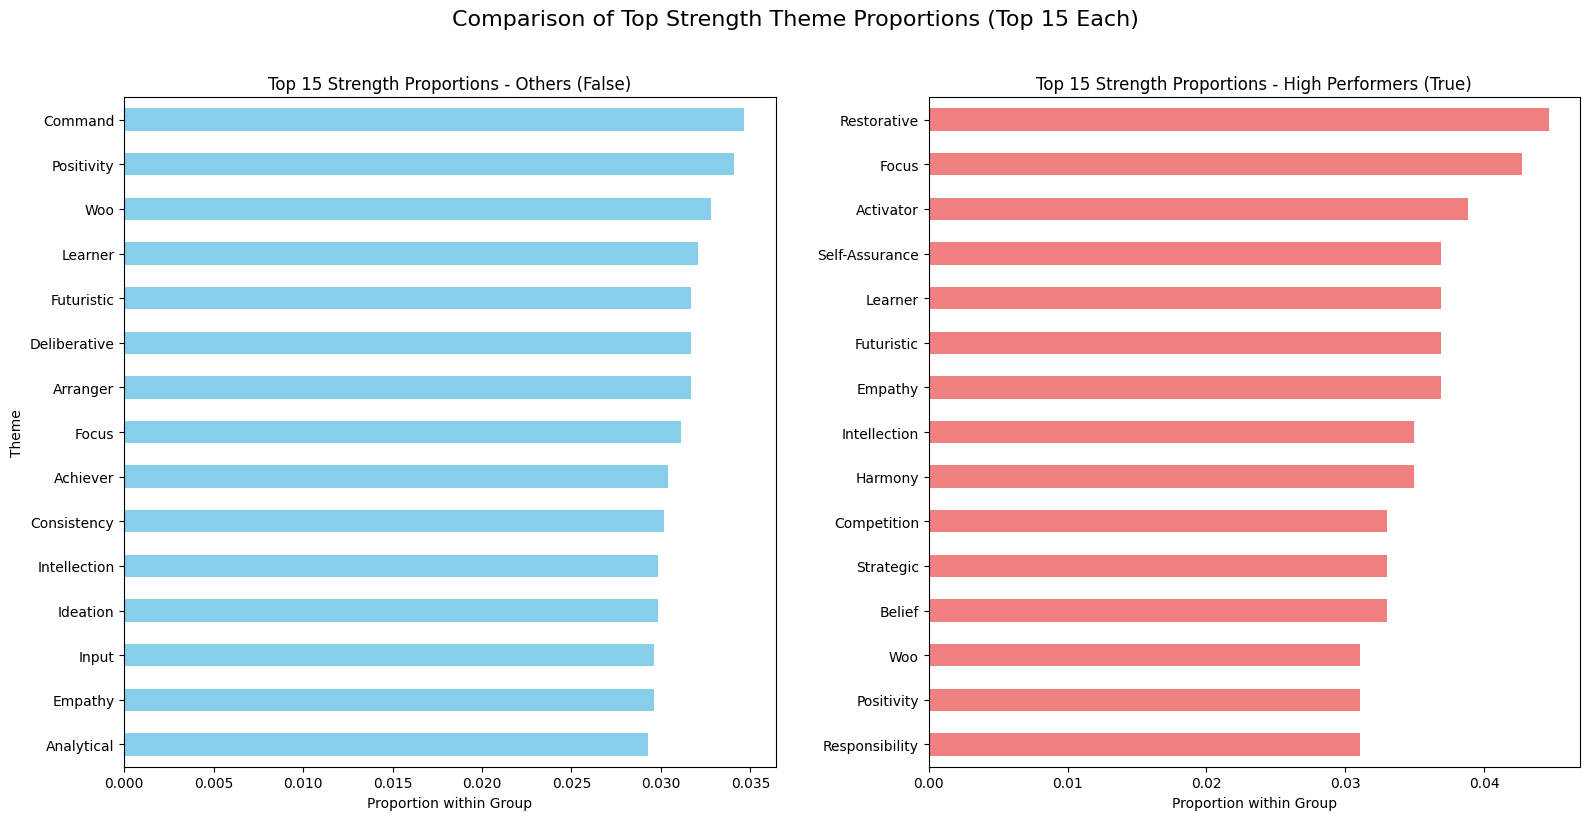


--- Top 5 Strengths More Prevalent in High Performers ---
                High_Performer_Prop  Other_Prop  Difference (HP - Other)
theme                                                                   
Restorative                0.044660    0.027586                 0.017074
Activator                  0.038835    0.026841                 0.011994
Focus                      0.042718    0.031128                 0.011591
Self-Assurance             0.036893    0.028518                 0.008375
Empathy                    0.036893    0.029637                 0.007257

--- Top 5 Strengths More Prevalent in Others ---
               High_Performer_Prop  Other_Prop  Difference (HP - Other)
theme                                                                  
Command                   0.015534    0.034669                -0.019135
Connectedness             0.017476    0.028705                -0.011229
Input                     0.019417    0.029637                -0.010219
Significance        

In [393]:
# --- Visualize Comparison (Side-by-Side Separate Bar Charts) ---

# Calculate proportions for High Performers
hp_strength_props = df_analysis_strengths[df_analysis_strengths['is_high_performer'] == True]['theme'].value_counts(normalize=True)

# Calculate proportions for Others
other_strength_props = df_analysis_strengths[df_analysis_strengths['is_high_performer'] == False]['theme'].value_counts(normalize=True)

# Combine into a DataFrame for easier comparison
strength_comparison = pd.DataFrame({'High_Performer_Prop': hp_strength_props, 'Other_Prop': other_strength_props}).fillna(0)

# Calculate difference and sort
strength_comparison['Difference (HP - Other)'] = strength_comparison['High_Performer_Prop'] - strength_comparison['Other_Prop']
strength_comparison = strength_comparison.sort_values(by='Difference (HP - Other)', ascending=False)

# Select top N themes based on difference or overall frequency for plotting
top_n = 15 # Number of themes to show on each chart (adjust as needed)
# Get themes most prevalent in High Performers
top_hp_themes = strength_comparison.sort_values(by='High_Performer_Prop', ascending=False).head(top_n).index
# Get themes most prevalent in Others
top_other_themes = strength_comparison.sort_values(by='Other_Prop', ascending=False).head(top_n).index

# --- Create the figure with two subplots (1 row, 2 columns) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False) # sharey=False allows independent sorting/scaling

# --- Plot 1: Others (False) ---
plot_data_others = strength_comparison['Other_Prop'].sort_values(ascending=True).tail(top_n) # Get top N for Others, sorted ascending for barh
plot_data_others.plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title(f'Top {top_n} Strength Proportions - Others (False)')
axes[0].set_xlabel('Proportion within Group')
axes[0].set_ylabel('Theme') # Add Y label only to the left plot

# --- Plot 2: High Performers (True) ---
plot_data_hp = strength_comparison['High_Performer_Prop'].sort_values(ascending=True).tail(top_n) # Get top N for High Performers, sorted
plot_data_hp.plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_title(f'Top {top_n} Strength Proportions - High Performers (True)')
axes[1].set_xlabel('Proportion within Group')
axes[1].set_ylabel('') # Remove Y label for the right plot

# --- Final Touches ---
plt.suptitle('Comparison of Top Strength Theme Proportions (Top 15 Each)', fontsize=16, y=1.02)
plt.tight_layout(w_pad=3.0) # Add padding between plots if needed
plt.show()

# --- Print differences again for reference ---
print("\n--- Top 5 Strengths More Prevalent in High Performers ---")
print(strength_comparison.sort_values(by='Difference (HP - Other)', ascending=False).head(5))

print("\n--- Top 5 Strengths More Prevalent in Others ---")
print(strength_comparison.sort_values(by='Difference (HP - Other)', ascending=True).head(5))

* **Themes More Common in High Performers:** `Restorative` (+1.7%), `Activator` (+1.2%), `Focus` (+1.2%), `Self-Assurance` (+0.8%), and `Empathy` (+0.7%) appeared slightly more often in the Top 5 of High Performers.
* **Themes More Common in Others:** `Command` (-1.9%), `Connectedness` (-1.1%), `Input` (-1.0%), `Significance` (-0.7%), and `Developer` (-0.5%) were slightly more prevalent in the Top 5 of the 'Other' group.
* **Visualization:** The side-by-side bar charts illustrate these minor shifts in frequency. Many themes appear with similar low proportions in both groups.

 Although slight tendencies exist (e.g., High Performers being marginally more likely to have `Restorative` or `Activator` in their Top 5), the **differences observed are minimal**. Based solely on the frequency within the Top 5, CliftonStrengths themes appear to be **weak differentiators** for high performance in this dataset. Like personality types, they might add some nuance but don't emerge as primary drivers compared to potentially stronger factors like specific competencies.

#### Conclusion

The analysis focused on comparing the frequency of themes within the Top 5 CliftonStrengths between High Performers and Others, excluding employees with incomplete Top 5 data. The results showed **only minimal differences** in the prevalence of specific themes between the two groups. While slight tendencies were observed (e.g., `Restorative` being marginally more common in High Performers), no theme emerged as a strong, significant differentiator based on Top 5 frequency alone.

Having explored contextual factors, psychometric profiles (cognitive, personality, work styles), and behavioral data (Strengths), we have found limited strong differentiators so far. This suggests that **developed skills and competencies** might be the most critical factor. Therefore, the final analytical step is to examine the **Competency Pillars** (`competencies_yearly`), comparing the average scores achieved by High Performers versus Others across the company's historical 10-pillar model to identify key skill-based drivers of success.

### Competency pillars

Identify specific competency pillars (from the company's historical model) where High Performers significantly score higher than Others.

In [102]:
# --- Merge Competency data with the main dataframe ---
# Ensure df_competencies is the cleaned and imputed version for year 2025
df_analysis_competencies = df_main_EDA[['employee_id', 'is_high_performer']].merge(df_competencies_cleaned, on='employee_id',how='inner' )
print(f"Merged Competency data ready for analysis with {df_analysis_competencies['employee_id'].nunique()} employees.")

Merged Competency data ready for analysis with 1790 employees.



--- Average Competency Scores by Performance Group ---
is_high_performer     False     True 
pillar_code                          
CEX                2.879778  4.410714
CSI                2.897657  4.470238
FTC                2.902589  4.428571
GDR                2.883477  4.375000
IDS                2.879778  4.434524
LIE                2.916769  4.440476
QDD                2.908755  4.601190
SEA                2.902589  4.529762
STO                2.884094  4.452381
VCU                2.912454  4.464286


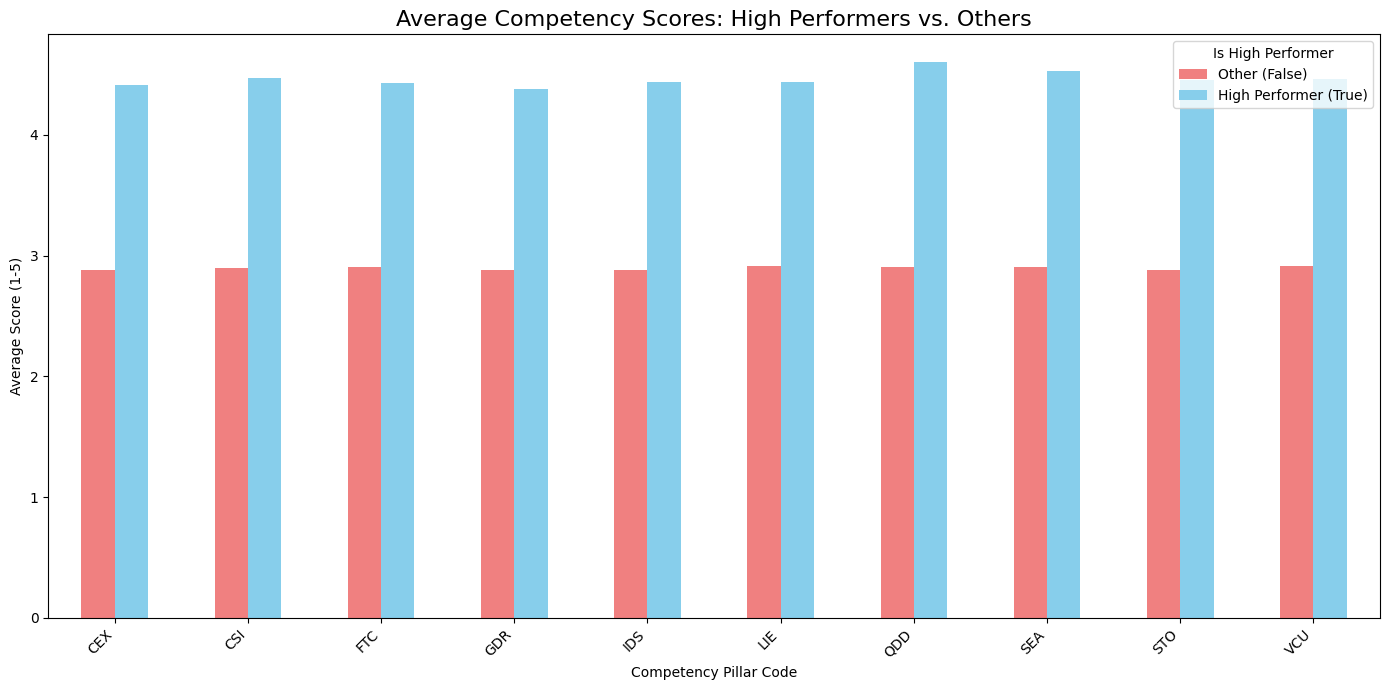


--- Competency Pillars with Largest Average Score Difference (Absolute) ---
is_high_performer     False      True  difference
pillar_code                                      
QDD                2.908755  4.601190    1.692436
SEA                2.902589  4.529762    1.627173
CSI                2.897657  4.470238    1.572581
STO                2.884094  4.452381    1.568287
IDS                2.879778  4.434524    1.554746
VCU                2.912454  4.464286    1.551832
CEX                2.879778  4.410714    1.530936
FTC                2.902589  4.428571    1.525982
LIE                2.916769  4.440476    1.523707
GDR                2.883477  4.375000    1.491523


In [103]:
# --- Calculate Average Scores per Pillar per Group ---
avg_competency_scores = df_analysis_competencies.groupby(['pillar_code', 'is_high_performer'])['score'].mean().unstack()

print("\n--- Average Competency Scores by Performance Group ---")
print(avg_competency_scores)

# --- Visualize Comparison (Grouped Bar Chart) ---
custom_palette_comp = ['lightcoral', 'skyblue'] # False (Other), True (High Performer) - Remember the color switch
avg_competency_scores.plot(kind='bar', figsize=(14, 7), color=custom_palette_comp)
plt.title('Average Competency Scores: High Performers vs. Others', fontsize=16)
plt.xlabel('Competency Pillar Code')
plt.ylabel('Average Score (1-5)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is High Performer', labels=['Other (False)', 'High Performer (True)'])
plt.tight_layout()
plt.show()

# --- (Optional but Recommended) Prepare Data for Radar Chart ---
# Transpose the data
radar_data = avg_competency_scores.T # Now index is True/False, columns are pillars
labels = radar_data.columns.values
num_vars = len(labels)

# Get scores
scores_false_comp = radar_data.loc[False].values
scores_true_comp = radar_data.loc[True].values

# Complete the loop
angles_comp = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles_comp += angles_comp[:1]
scores_false_comp = np.concatenate((scores_false_comp, [scores_false_comp[0]]))
scores_true_comp = np.concatenate((scores_true_comp, [scores_true_comp[0]]))
labels_looped_comp = np.append(labels, labels[0])


# --- (Optional) Identify Pillars with Largest Differences ---
avg_competency_scores['difference'] = (avg_competency_scores[True] - avg_competency_scores[False]).abs()
top_diff_comp = avg_competency_scores.sort_values(by='difference', ascending=False)

print("\n--- Competency Pillars with Largest Average Score Difference (Absolute) ---")
print(top_diff_comp[[False, True, 'difference']])

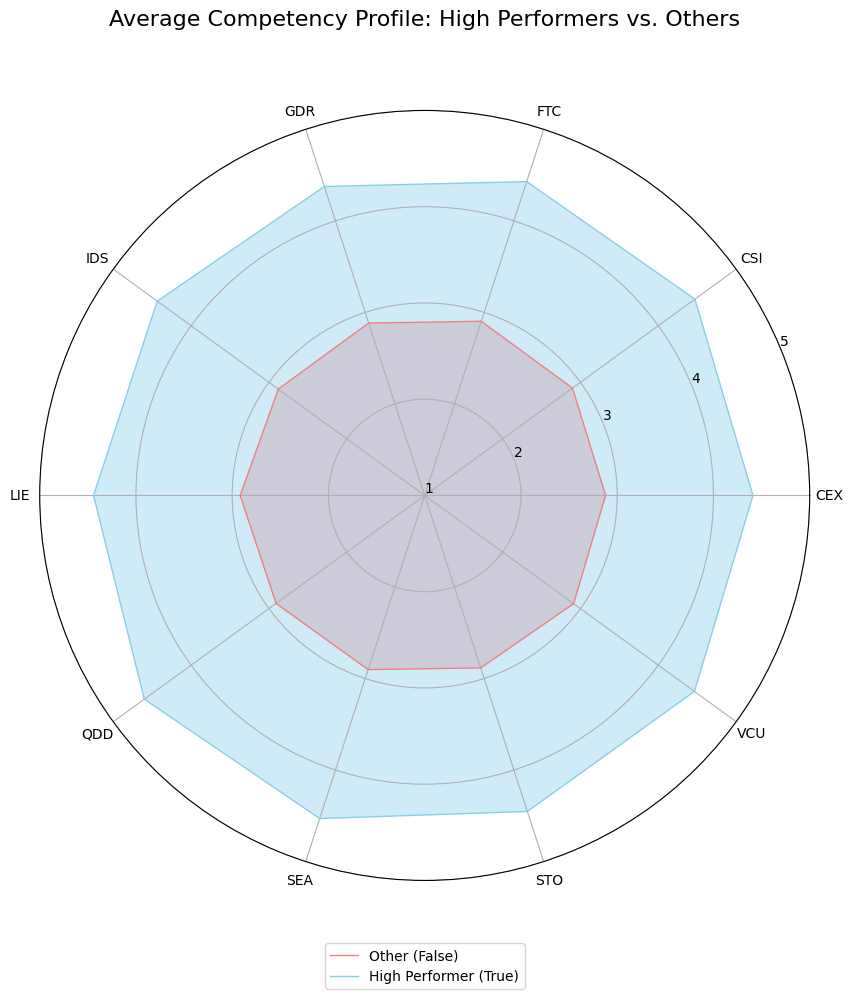

In [104]:

# --- Create Radar Chart ---
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

ax.plot(angles_comp, scores_false_comp, linewidth=1, linestyle='solid', label='Other (False)', color='lightcoral') # Corrected color
ax.fill(angles_comp, scores_false_comp, 'lightcoral', alpha=0.4) # Corrected color

ax.plot(angles_comp, scores_true_comp, linewidth=1, linestyle='solid', label='High Performer (True)', color='skyblue') # Corrected color
ax.fill(angles_comp, scores_true_comp, 'skyblue', alpha=0.4) # Corrected color

# --- Customize the Plot ---
# Set the y-axis limits (Competency scores 1-5)
ax.set_yticks(np.arange(1, 6, 1)) # Ticks from 1 to 5
ax.set_ylim(1, 5) # Set Y limit to match score range

# Set the category labels on the axes
ax.set_xticks(angles_comp[:-1]) # Use angles without the repeated last one
ax.set_xticklabels(labels)

# Add title and legend
plt.title('Average Competency Profile: High Performers vs. Others', size=16, y=1.1)
# Adjust legend position for better visibility
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15)) # Place legend below the chart

plt.show()


* **Magnitude:** The analysis of average competency scores reveals **substantial and consistent differences** between High Performers (`True`) and Others (`False`) across **all 10 pillars**. The average scores for High Performers are consistently around **1.5 to 1.7 points higher** (on a 1-5 scale) than for Others. This is a much larger gap compared to the minor differences seen in contextual, cognitive, personality, or PAPI scores.
* **Top Differentiators:** All pillars show strong differentiation. Based on the absolute difference, the pillars showing the largest gaps are **`QDD`** (Quality Delivery Discipline, diff: ~1.69), **`SEA`** (Social Empathy & Awareness, diff: ~1.63), **`CSI`** (Commercial Savvy & Impact, diff: ~1.57), **`STO`** (Synergy & Team Orientation, diff: ~1.57), and **`IDS`** (Insight & Decision Sharpness, diff: ~1.55).
* **Visualization:** Both the grouped bar chart and the radar chart vividly illustrate this significant gap. The profile for High Performers consistently sits well outside and above the profile for Others across every dimension.

 Competency scores, as measured by the company's historical 10-pillar model, are **by far the strongest differentiators** identified so far for high performance. Achieving high scores across **multiple, if not all, competency pillars** appears to be a critical factor for attaining a top performance rating. These competency scores will be the **most heavily weighted component** in the Success Formula.

## Synthesis for Success Formula

### 🧩 EDA Findings Summary & Implications for Success Formula

| **Analysis Area** | **Key Findings (Quantitative Summary)** | **Interpretation** | **Implication for Success Formula** |
| :---------------- | :-------------------------------------- | :----------------- | :---------------------------------- |
| **Contextual Factors** | - **Moderate influence** seen in: `Area` (Store +2.8%), `Department` (IT/Ops > HR), `Position` (Sales Sup +3.7%, Supply Plan -3.7%), `Major` (Eng +2.8%, Eco +1.9%, Psi -2.6%), and `Education` (S2 +2.4%, D3 -3.6%). <br>- **Low/No effect** for `Years of Service` (mean diff ~1–3 mo), `Grade` (IV +1.2% vs III/V), `Company` (~3% range), `Division` (~1.4%), and `Directorate` (~1.1%). | Contextual or structural attributes (like job level, company, or tenure) only slightly affect performance. Some role-related or academic backgrounds may support success, but not determine it. | 🟡 **Low–Medium Weight (10-20%)**. Functions as control context; minor contribution in “Background/Experience” factors within the success model. |
| **Psychometric – Cognitive (IQ, GTQ, Pauli, Faxtor)** | - No statistically significant difference (p > 0.05). <br>- HP mean ≈ Others across all tests (Pauli marginal at p ≈ 0.058). | Cognitive ability and attention measures are **not key differentiators** between High Performers and others. | 🔵 **Very Low Weight (0–5%)**. Excluded or minimally included. |
| **Psychometric – Personality (MBTI, DISC)** | - MBTI & DISC distributions nearly identical. <br>- Type differences very small (<4%). | Personality types do not explain why certain employees achieve high performance  they reflect style, not success potential. | 🔵 **Very Low Weight (0–5%)**. Personality acts as behavioral diversity indicator, not predictor. |
| **Psychometric – PAPI (Work Style Preferences)** | - Mean differences < 0.4 points (on 1–9 scale). <br>- Radar profiles almost identical. | Indicates that **work preferences are stable** across performance levels no strong behavioral divergence. | 🔵 **Very Low Weight (0–5%)**. Not predictive for performance. |
| **Behavioral Strengths (Clifton Themes)** | - Minimal differences in theme frequency (<2%). <br>- HP slightly higher in *Restorative, Activator, Focus, Self-Assurance, Empathy*. Others higher in *Command, Connectedness, Input*. | HPs are slightly more self-driven and outcome-focused, while others may emphasize connection or information-gathering. Still, gap is small. | 🟠 **Low Weight (5–10%)**. Indicates attitude/motivation orientation, but not dominant predictor. |
| **Competency Pillars (10 Dimensions)** | - **Clear separation:** HPs score **+1.5–1.7 points higher** across all pillars. <br>- Largest gaps: `QDD`, `SEA`, `CSI`, `STO`. | Core competencies consistently distinguish high performers; suggests that performance excellence is rooted in skill mastery and execution capability. | 🔴 **Very High Weight (65-75 %)**. Core driver of success; should be central to Success Formula and predictive modeling. |

---

###  Synthesis Insight
The exploratory analysis confirms that **intrinsic skill and behavioral competencies**  rather than background, personality, or work context are the **strongest determinants of high performance**.

Contextual and psychometric factors act primarily as **enablers or baseline conditions**, not differentiators.  
Hence, the **competency domain** forms the backbone of the *Success Formula*, supported modestly by behavioral drives and contextual experience.

---

###  Implication for Success Formula Construction


where:

| **Dimension** | **Weight (Initial Estimate)** | **Description** |
| :-- | :--: | :-- |
| **Competencies (10 pillars)** | **0.675** | Measured capabilities and behavioral execution. |
| **Behavioral Strengths / Motivation** | **0.05** | Reflects mindset, proactivity, and resilience. |
| **Contextual (Experience, Education)** | **0.175** | Provides baseline understanding of role/fit. |
| **Psychometric (Cognitive/Personality)** | **0.10** | Serves as supplementary non-critical attributes. |

---


**Talent Group Variable (TGV) – Talent Variable (TV) Mapping**

This mapping bridges the exploratory findings with the structure of the Success Formula.  
Each **Talent Group Variable (TGV)** represents a conceptual cluster of **Talent Variables (TVs)** derived from the dataset,  
reflecting different dimensions of what drives employee success.

| **Talent Group Variable (TGV) Name** | **Description** | **Talent Variables (TVs)** | **Source Dataset** | **EDA Insight Summary** | **Estimated Weight** |
| :-- | :-- | :-- | :-- | :-- | :--: |
| **Competency** | Adaptability & Stress Tolerance | SEA | `competencies_yearly` | HP +1.63 (strong differentiator) | 0.1125 |
|  | Cognitive Complexity & Problem-Solving | QDD | `competencies_yearly` | HP +1.69 (strong differentiator) | 0.1125 |
|  | Conscientiousness & Reliability | FTC | `competencies_yearly` | HP +1.52 (moderate differentiator) | 0.075 |
|  | Creativity & Innovation Orientation | IDS | `competencies_yearly` | HP +1.55 (strong differentiator) | 0.075 |
|  | Cultural & Values Urgency | VCU | `competencies_yearly` | HP +1.55 (strong differentiator) | 0.075 |
|  | Leadership & Influence | STO , LIE | `competencies_yearly` | HP +1.56 (strong differentiator) | 0.075 |
|  | Motivation & Drive | CSI | `competencies_yearly` | HP +1.57 (strong differentiator) | 0.075 |
|  | Social Orientation & Collaboration | CEX , GDR | `competencies_yearly` | HP +1.50 (moderate differentiator) | 0.075 |
| **Psychometric (Cognitive)** | Cognitive Ability | IQ , GTQ , Pauli , Faxtor, Tiki | `profiles_psych` | p > 0.05, minimal difference | 0.05 |
| **Psychometric (Personality)** | Work & Personality Style | MBTI , DISC , PAPI scales (P, S, G, T, W) | `profiles_psych`, `papi_scores` | Type distribution similar across groups | 0.05 |
| **Behavioral (Strengths)** | Behavioral Drive & Motivation | Top 5 Strengths (e.g., Restorative, Focus) | `strengths` | HP +1–2% higher in self-driven themes | 0.05 |
| **Contextual (Background)** | Experience & Role Fit | Education, Major, Grade, Years of Service, Position, Area, Tenure | `main` + joined HR data | Minor impact (<3% diff) | 0.175 |

---



## STEP 2 SQL

In [430]:
df_SQL_OUTPUT = pd.read_sql(
  
  """
---- PHASE 1: DATA CLEANING AND IMPUTATION------


--- STEP/CTE 1.A: Calculating Competency Medians ---
----Purpose: Calculate the median score per 'pillar_code' (only from the 2025 valid data)
----This is for imputation of missing/odd competency data.
with competency_medians as(
 SELECT 
    pillar_code, 
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY score) as median_score
    FROM competencies_yearly
    WHERE year = 2025 
    AND score IS NOT NULL 
    AND score NOT IN (0, 6, 99) 
    GROUP BY pillar_code
),

--- STEP/CTE 1.B: Clean and Impute Competency Scores ---
---Purpose: Create a clean 'competencies' table for 2025.
--- Use CTE 1.A to fill in missing/odd data.

competencies_cleaned_imputed as (
SELECT 
    c.employee_id,
    c.pillar_code,
    c.year,
    COALESCE(
        CASE 
        WHEN c.score IN (0, 6, 99) THEN NULL 
        ELSE c.score 
        END, 
        cm.median_score
    ) as score_imputed
FROM competencies_yearly as c
LEFT JOIN competency_medians as cm 
ON c.pillar_code = cm.pillar_code
WHERE c.year = 2025 
),

--- STEP/CTE 1.C: Calculating Median IQ per Department ---
--Purpose: Calculate the median IQ per department.
-- This is for imputation of missing 'iq' data in the 'profiles_psych' table.
---- According to the step 1 , the department 4 has no value in iq amd qtq

cognitive_medians as(
SELECT 
    e.department_id,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY p.iq) FILTER (WHERE e.department_id != 4) as median_iq,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY p.gtq) FILTER (WHERE e.department_id != 4) as median_gtq
FROM employees as e
LEFT JOIN profiles_psych as p 
ON e.employee_id = p.employee_id
WHERE p.iq IS NOT NULL OR p.gtq IS NOT NULL
GROUP BY e.department_id
),


--- STEP/CTE  1.D (Final Version): Clean, Join, and Impute All Main Data ---
---Purpose: Replicate  `df_main_cleaned` from the notebook.
---1. Cleans MBTI typos ('intftj' -> 'UNKNOWN', UPPERCASE)
---2. Dynamically calculates the MBTI Mode (NOT hardcoded 'ENFP')
---3. Imputes NULL MBTI with the calculated mode
---4. JOINS all dimension tables (dim_department, dim_position, etc.)
---5. Imputes IQ and GTQ with departmental medians
---6. Imputes DISC from disc_word 

-- STEP 1.D.1: Clean MBTI Typos
-- Purpose: Clean typos BEFORE calculating the mode.

mbti_cleaned_typos as(
SELECT
  employee_id,
  CASE 
    WHEN mbti = 'inftj' THEN 'UNKNOWN'
    ELSE UPPER(mbti)
    END as mbti_cleaned
FROM profiles_psych
),      

-- STEP 1.D.2: Calculate MBTI Mode
-- Purpose: Find the most common MBTI value (Mode) from the cleaned data.
mbti_mode as (
SELECT 
  MODE() WITHIN GROUP (ORDER BY mbti_cleaned) as mbti_mode_value
FROM mbti_cleaned_typos
WHERE mbti_cleaned is NOT NULL
),


-- STEP/CTE 1.D (Final): Join, Clean, and Impute
-- Purpose: The main cleaned data table, replicating df_main_cleaned.
  -- Impute Cognitive scores (from 1.C)
  -- Impute MBTI (from 1.D.1 and 1.D.2)
      -- 1. Get the cleaned mbti value
      -- 2. If it's NULL, fill it with the calculated mode
  -- Impute DISC 
      -- 1. Use 'disc' if it exists
      -- 2. If 'disc' is NULL, try to map it from 'disc_word'

main_cleaned_imputed as (
SELECT 
    e.employee_id, 
    e.fullname, 
    e.nip,
    com.name as company,
    ar.name as area,
    e.years_of_service_months as tenure_months, 
    d.name as department,
    p.name as position,
    dir.name as directorate,
    g.name as grade,
    ed.name as education_level,
    maj.name as major,
    CASE
            WHEN e.department_id = 4 THEN NULL
            ELSE COALESCE(p_psych.iq, cog_m.median_iq)
        END as iq_imputed,
        CASE
            WHEN e.department_id = 4 THEN NULL
            ELSE COALESCE(p_psych.gtq, cog_m.median_gtq) -- Assuming 'gtq' is total
        END as gtq_imputed,
    COALESCE(mbti_clean.mbti_cleaned, mbti_m.mbti_mode_value) as mbti_final,
    COALESCE(p_psych.disc, 
      CASE 
          WHEN p_psych.disc_word = 'Dominant-Influencer' THEN 'DI'
          WHEN p_psych.disc_word = 'Dominant-Steadiness' THEN 'DS'
          WHEN p_psych.disc_word = 'Dominant-Conscientious' THEN 'DC'
          WHEN p_psych.disc_word = 'Influencer-Dominant' THEN 'ID'
          WHEN p_psych.disc_word = 'Influencer-Steadiness' THEN 'IS'
          WHEN p_psych.disc_word = 'Influencer-Conscientious' THEN 'IC'
          WHEN p_psych.disc_word = 'Steadiness-Dominant' THEN 'SD'
          WHEN p_psych.disc_word = 'Steadiness-Influencer' THEN 'SI'
          WHEN p_psych.disc_word = 'Steadiness-Conscientious' THEN 'SC'
          WHEN p_psych.disc_word = 'Conscientious-Dominant' THEN 'CD'
          WHEN p_psych.disc_word = 'Conscientious-Influencer' THEN 'CI'
          WHEN p_psych.disc_word = 'Conscientious-Steadiness' THEN 'CS'
          ELSE NULL 
      END
    ) as disc,
    p_psych.disc_word,
    p_psych.pauli as pauli_score,
    p_psych.tiki as tiki_score,
    p_psych.faxtor as faxtor_score, 
    py.rating
  
FROM employees as e

LEFT JOIN dim_departments as d 
ON e.department_id = d.department_id

LEFT JOIN dim_positions as p 
ON e.position_id = p.position_id

LEFT JOIN dim_grades as g 
ON e.grade_id = g.grade_id

LEFT JOIN dim_education as ed 
ON e.education_id = ed.education_id

LEFT JOIN dim_majors as maj 
ON e.major_id = maj.major_id

LEFT JOIN dim_companies as com 
ON e.company_id = com.company_id

LEFT JOIN dim_areas as ar 
ON e.area_id = ar.area_id

LEFT JOIN dim_directorates as dir
ON e.directorate_id = dir.directorate_id

-- Join psychometric data
LEFT JOIN profiles_psych as p_psych 
ON e.employee_id = p_psych.employee_id

-- Join our cleaning helper CTEs
LEFT JOIN cognitive_medians as cog_m 
ON e.department_id = cog_m.department_id

LEFT JOIN mbti_cleaned_typos as  mbti_clean 
ON e.employee_id = mbti_clean.employee_id

CROSS JOIN mbti_mode as mbti_m   -- CROSS JOIN for mode (it's only 1 row)

-- Join performance_yearly data
LEFT JOIN performance_yearly as py
ON e.employee_id = py.employee_id

WHERE   
py.rating BETWEEN 1 AND 5 
AND
py.year = 2025
),

---STEP/CTE 1.E: Clean Strengths Data ---
----Purpose: Filter 'rank' 1-5 and clean empty 'themes'.

-- STEP 1.E.1 : Clean all string-like NULLs 
-- PurposeClears strings '', 'nan', 'None', etc. to NULL
strengths_string_cleaned as (   
SELECT
  employee_id,
  "rank",
  CASE 
      WHEN LOWER(TRIM(theme)) IN ('', 'nan', 'none') THEN NULL
      ELSE theme
  END as  theme
FROM strengths
WHERE "rank" BETWEEN 1 AND 5 
),

-- STEP 1.E.2 : Find "Good" Employees 
-- Count the number of VALID themes in the Top 5 for EACH employee
employee_top5_completeness as (
SELECT
    employee_id,
    COUNT(theme) as  top_5_valid_themes_count
FROM strengths_string_cleaned
GROUP BY employee_id
),

-- STEP 1.E.3 (Final CTE): Filter based on the completeness check
strengths_cleaned as (
  SELECT
    s.employee_id,
    s.theme,
    s."rank"
  FROM strengths_string_cleaned as s
  INNER JOIN  employee_top5_completeness as c 
  ON s.employee_id = c.employee_id
  WHERE  c.top_5_valid_themes_count = 5
  ),

--- STEP 1.F: Clean and Impute PAPI Scores 
---Objective : Fill in NULL PAPI scores with the median per PAPI scale.

-- STEP/CTE 1.F.1: Calculate PAPI Medians
-- Objective: Calculate median score PER PAPI scale (similar to competencies).
papi_medians as (
  SELECT
    scale_code,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY score) as median_score
  FROM papi_scores
  WHERE score IS NOT NULL
  GROUP BY scale_code
  ),

-- STEP/CTE 1.F.2: Clean and Impute PAPI Scores
-- Objective: Create a clean 'papi_scores' table with NULLs filled by their scale's median.
papi_cleaned_imputed as (
    SELECT
        ps.employee_id,
        ps.scale_code,
        COALESCE(ps.score, pm.median_score) as score_imputed
    FROM papi_scores as ps
    LEFT JOIN papi_medians as pm 
    ON ps.scale_code = pm.scale_code
    ),


    
-- PHASE 2: BENCHMARKING---

-- STEP/CTE 2.A: Select Target Vacancy (SIMULATED)
-- Objective: Manually define our benchmark employee IDs (rating=5 Sales Supervisors) simulating a manager's input.

target_vacancy as(
  SELECT 
    ARRAY['EMP100024', 'EMP100075', 'EMP100319']::text[] as selected_talent_ids 
),


-- STEP/CTE 2.B: Calculate the "Ideal" Benchmark Baseline
-- Objective: Translate  TGV Mapping into a 1-row ideal profile.
benchmark_baseline as(
  SELECT   

  -- 1. TGV: Competency (Type: Numeric -> Median)

      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY c.avg_sea) as baseline_sea,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY c.avg_qdd) as baseline_qdd,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY c.avg_ftc) as baseline_ftc,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY c.avg_ids) as baseline_ids,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY c.avg_vcu) as baseline_vcu,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY c.avg_sto_lie) as baseline_sto_lie,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY c.avg_csi) as baseline_csi,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY c.avg_cex_gdr) as baseline_cex_gdr,


  -- 2. TGV: Psychometric (Cognitive) (Type: Numeric -> Median)

      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY m.iq_imputed) as baseline_iq,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY m.gtq_imputed) as baseline_gtq,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY m.pauli_score) as baseline_pauli,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY m.faxtor_score) as baseline_faxtor,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY m.tiki_score) as baseline_tiki,

  -- 3. TGV: Psychometric (Personality) (Type: Categorical -> Mode)

      MODE() WITHIN GROUP (ORDER BY m.mbti_final) as baseline_mbti,
      MODE() WITHIN GROUP (ORDER BY m.disc) as baseline_disc,

     -- PAPI Baseline: (Numeric -> Median)
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY p.score_imputed) FILTER (WHERE p.scale_code = 'Papi_P') as baseline_papi_p,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY p.score_imputed) FILTER (WHERE p.scale_code = 'Papi_S') as baseline_papi_s,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY p.score_imputed) FILTER (WHERE p.scale_code = 'Papi_G') as baseline_papi_g,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY p.score_imputed) FILTER (WHERE p.scale_code = 'Papi_T') as baseline_papi_t,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY p.score_imputed) FILTER (WHERE p.scale_code = 'Papi_W') as baseline_papi_w,

 
  -- 4. TGV: Behavioral (Strengths) (Type: Categorical -> Mode)
  
      -- (Take mode from Rank 1, 2, 3, 4, 5)
      MODE() WITHIN GROUP (ORDER BY s1.theme) as baseline_strength_1,
      MODE() WITHIN GROUP (ORDER BY s2.theme) as baseline_strength_2,
      MODE() WITHIN GROUP (ORDER BY s3.theme) as baseline_strength_3,
      MODE() WITHIN GROUP (ORDER BY s4.theme) as baseline_strength_4,
      MODE() WITHIN GROUP (ORDER BY s5.theme) as baseline_strength_5,

 
  -- 5. TGV: Contextual (Background)
  
      -- Categorical -> Mode
      MODE() WITHIN GROUP (ORDER BY m.education_level) as baseline_education,
      MODE() WITHIN GROUP (ORDER BY m.major) as baseline_major,
      MODE() WITHIN GROUP (ORDER BY m.department) as baseline_department,
      MODE() WITHIN GROUP (ORDER BY m.position) as baseline_position,
      MODE() WITHIN GROUP (ORDER BY m.area) as baseline_area,

      -- Numeric -> Median
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY m.tenure_months) as baseline_tenure
  
  FROM 
    (SELECT unnest(ARRAY['EMP100024', 'EMP100075', 'EMP100319']::text[]) as employee_id FROM target_vacancy) as benchmark_ids  -- Benchmark Employees
  
  LEFT JOIN main_cleaned_imputed as m 
  ON benchmark_ids.employee_id = m.employee_id
  
  -- Join 5 times for 5 rank (Strengths)
  LEFT JOIN strengths_cleaned  as s1 
  ON benchmark_ids.employee_id = s1.employee_id AND s1."rank" = 1 
  LEFT JOIN strengths_cleaned  as s2 
  ON benchmark_ids.employee_id = s2.employee_id AND s2."rank" = 2 
  LEFT JOIN strengths_cleaned as s3 
  ON benchmark_ids.employee_id = s3.employee_id AND s3."rank" = 3 
  LEFT JOIN strengths_cleaned as s4 
  ON benchmark_ids.employee_id = s4.employee_id AND s4."rank" = 4 
  LEFT JOIN strengths_cleaned as s5 
  ON benchmark_ids.employee_id = s5.employee_id AND s5."rank" = 5 
      
  -- Join for PAPI Scores
  LEFT JOIN papi_cleaned_imputed as p 
  ON benchmark_ids.employee_id = p.employee_id
      
  LEFT JOIN
    (SELECT 
        employee_id,
        AVG(score_imputed) FILTER (WHERE pillar_code = 'SEA') as avg_sea,
        AVG(score_imputed) FILTER (WHERE pillar_code = 'QDD') as avg_qdd,
        AVG(score_imputed) FILTER (WHERE pillar_code = 'FTC') as avg_ftc,
        AVG(score_imputed) FILTER (WHERE pillar_code = 'IDS') as avg_ids,
        AVG(score_imputed) FILTER (WHERE pillar_code = 'VCU') as avg_vcu,
        AVG(score_imputed) FILTER (WHERE pillar_code IN ('STO', 'LIE')) as avg_sto_lie,
        AVG(score_imputed) FILTER (WHERE pillar_code = 'CSI') as avg_csi,
        AVG(score_imputed) FILTER (WHERE pillar_code IN ('CEX', 'GDR')) as avg_cex_gdr
      FROM competencies_cleaned_imputed
      GROUP BY employee_id
    ) as c 
    ON benchmark_ids.employee_id = c.employee_id
),


---- PHASE 3: UNPIVOT ALL EMPLOYEES----- 

-- STEP/CTE 3.A: Unpivot All Employees
  -- Purpose: Create a "long-format" table of ALL employees to match the TGV Mapping.
  -- All user_score values are CAST to TEXT to ensure consistent data types across UNION ALL blocks.
all_employees_unpivoted as (
        
-- 1. TGV: Competency (8 TV blocks from 10 pillars)
  SELECT 
      employee_id, 'Competency' as tgv_name, 'SEA' as tv_name,
      AVG(score_imputed)::text as user_score, 
      'numeric' as tv_type
  FROM competencies_cleaned_imputed WHERE pillar_code = 'SEA' GROUP BY employee_id
  
  UNION ALL
  SELECT 
      employee_id, 'Competency' as tgv_name, 'QDD' as tv_name,
      AVG(score_imputed)::text as user_score, 
      'numeric' as tv_type
  FROM competencies_cleaned_imputed WHERE pillar_code = 'QDD' GROUP BY employee_id
  
  UNION ALL
  SELECT 
      employee_id, 'Competency' as tgv_name, 'FTC' as tv_name, 
      AVG(score_imputed)::text as user_score, 
      'numeric' as tv_type
  FROM competencies_cleaned_imputed WHERE pillar_code = 'FTC' GROUP BY employee_id
  
  UNION ALL
  SELECT
      employee_id, 'Competency' as tgv_name, 'IDS' as tv_name,
      AVG(score_imputed)::text as user_score, 
      'numeric' as tv_type
  FROM competencies_cleaned_imputed WHERE pillar_code = 'IDS' GROUP BY employee_id
  
  UNION ALL
  SELECT
      employee_id, 'Competency' as tgv_name, 'VCU' as tv_name, 
      AVG(score_imputed)::text as user_score, 
      'numeric' as tv_type
  FROM competencies_cleaned_imputed WHERE pillar_code = 'VCU' GROUP BY employee_id
  
  UNION ALL
  SELECT 
      employee_id, 'Competency' as tgv_name, 'STO_LIE' as tv_name, 
      AVG(score_imputed)::text as user_score, 
      'numeric' as tv_type
  FROM competencies_cleaned_imputed WHERE pillar_code IN ('STO', 'LIE') GROUP BY employee_id
  
  UNION ALL
  SELECT 
      employee_id, 'Competency' as tgv_name, 'CSI' as tv_name, 
      AVG(score_imputed)::text as user_score, 
      'numeric' as tv_type
  FROM competencies_cleaned_imputed WHERE pillar_code = 'CSI' GROUP BY employee_id
  
  UNION ALL
  SELECT 
      employee_id, 'Competency' as tgv_name, 'CEX_GDR' as tv_name, 
      AVG(score_imputed)::text as user_score, 
      'numeric' as tv_type
  FROM competencies_cleaned_imputed WHERE pillar_code IN ('CEX', 'GDR') GROUP BY employee_id

  -- 2. TGV: Psychometric (Cognitive) (5 TV)
  UNION ALL
  SELECT 
      employee_id, 'Psychometric (Cognitive)' as tgv_name, 'IQ' as tv_name, 
      iq_imputed::text as user_score, 
      'numeric' as tv_type
  FROM main_cleaned_imputed

  UNION ALL
  SELECT 
      employee_id, 'Psychometric (Cognitive)' as tgv_name, 'GTQ' as tv_name, 
      gtq_imputed::text as user_score, 
      'numeric' as tv_type
  FROM main_cleaned_imputed

  UNION ALL
  SELECT 
      employee_id, 'Psychometric (Cognitive)' as tgv_name, 'Pauli' as tv_name, 
      pauli_score::text as user_score, 
      'numeric' as tv_type
  FROM main_cleaned_imputed

  UNION ALL
  SELECT
      employee_id, 'Psychometric (Cognitive)' as tgv_name, 'Faxtor' as tv_name, 
      faxtor_score::text as user_score, 
      'numeric' as tv_type
  FROM main_cleaned_imputed
  
  UNION ALL
  SELECT 
      employee_id, 'Psychometric (Cognitive)' as tgv_name, 'Tiki' as tv_name, 
      tiki_score::text as user_score, 
      'numeric' as tv_type
  FROM main_cleaned_imputed

  -- 3. TGV: Psychometric (Personality) (MBTI, DISC, 5 PAPI)
  UNION ALL
  SELECT 
      employee_id, 'Psychometric (Personality)' as tgv_name, 'MBTI' as tv_name, 
      mbti_final as user_score, 
      'categorical' as tv_type
  FROM main_cleaned_imputed

  UNION ALL
  SELECT 
      employee_id, 'Psychometric (Personality)' as tgv_name, 'DISC' as tv_name,
      disc as user_score, 
      'categorical' as tv_type
  FROM main_cleaned_imputed

  UNION ALL
  SELECT 
      employee_id, 'Psychometric (Personality)' as tgv_name, 'Papi_P' as tv_name, 
      score_imputed::text as user_score,
      'numeric' as tv_type
  FROM papi_cleaned_imputed WHERE scale_code = 'Papi_P'

  UNION ALL
  SELECT 
      employee_id, 'Psychometric (Personality)' as tgv_name, 'Papi_S' as tv_name, 
      score_imputed::text as user_score,
      'numeric' as tv_type
  FROM papi_cleaned_imputed WHERE scale_code = 'Papi_S'

  UNION ALL
  SELECT 
      employee_id, 'Psychometric (Personality)' as tgv_name, 'Papi_G' as tv_name, 
      score_imputed::text as user_score, 
      'numeric' as tv_type
  FROM papi_cleaned_imputed WHERE scale_code = 'Papi_G'

  UNION ALL
  SELECT 
      employee_id, 'Psychometric (Personality)' as tgv_name, 'Papi_T' as tv_name, 
      score_imputed::text as user_score, 
      'numeric' as tv_type
  FROM papi_cleaned_imputed WHERE scale_code = 'Papi_T'

  UNION ALL
  SELECT 
      employee_id, 'Psychometric (Personality)' as tgv_name, 'Papi_W' as tv_name, 
      score_imputed::text as user_score, 
      'numeric' as tv_type
  FROM papi_cleaned_imputed WHERE scale_code = 'Papi_W'


  -- 4. TGV: Behavioral (Strengths) (5 TV)
  UNION ALL
  SELECT 
      employee_id, 'Behavioral (Strengths)' as tgv_name, 'Strength_1' as tv_name, 
      theme as user_score, 
      'categorical' as tv_type
  FROM strengths_cleaned WHERE "rank" = 1

  UNION ALL
  SELECT 
      employee_id, 'Behavioral (Strengths)' as tgv_name, 'Strength_2' as tv_name, 
      theme as user_score, 
      'categorical' as tv_type
  FROM strengths_cleaned WHERE "rank" = 2

  UNION ALL
  SELECT 
      employee_id, 'Behavioral (Strengths)' as tgv_name, 'Strength_3' as tv_name, 
      theme as user_score, 
      'categorical' as tv_type
  FROM strengths_cleaned WHERE "rank" = 3

  UNION ALL
  SELECT 
      employee_id, 'Behavioral (Strengths)' as tgv_name, 'Strength_4' as tv_name, 
      theme as user_score, 
      'categorical' as tv_type
  FROM strengths_cleaned WHERE "rank" = 4

  UNION ALL
  SELECT 
      employee_id, 'Behavioral (Strengths)' as tgv_name, 'Strength_5' as tv_name, 
      theme as user_score, 
      'categorical' as tv_type
  FROM strengths_cleaned WHERE "rank" = 5

  -- 5. TGV: Contextual (Background) (6 TV)
  UNION ALL
  SELECT 
      employee_id, 'Contextual (Background)' as tgv_name, 'Education' as tv_name, 
      education_level as user_score,
      'categorical' as tv_type
  FROM main_cleaned_imputed

  UNION ALL
  SELECT 
      employee_id, 'Contextual (Background)' as tgv_name, 'Major' as tv_name, 
      major as user_score, 
      'categorical' as tv_type
  FROM main_cleaned_imputed

  UNION ALL
  SELECT 
      employee_id, 'Contextual (Background)' as tgv_name, 'Department' as tv_name, 
      department as user_score, 
      'categorical' as tv_type
  FROM main_cleaned_imputed

  UNION ALL
  SELECT 
      employee_id, 'Contextual (Background)' as tgv_name, 'Position' as tv_name, 
      position as user_score, 
      'categorical' as tv_type
  FROM main_cleaned_imputed


  UNION ALL
  SELECT 
      employee_id, 'Contextual (Background)' as tgv_name, 'Area' as tv_name, 
      area as user_score, 
      'categorical' as tv_type
  FROM main_cleaned_imputed

   UNION ALL
  SELECT 
      employee_id, 'Contextual (Background)' as tgv_name, 'Tenure' as tv_name, 
      tenure_months::text as user_score, 
      'numeric' as tv_type
  FROM main_cleaned_imputed

),


-- PHASE 4: CALCULATE MATCH SCORE
-- STEP/CTE 4.A: Unpivot the Benchmark Baseline
    -- Purpose: To unpivot the 1-row "wide" baseline into a "long-format" table.
    -- Numeric comparisons are later restored by re-casting user_score::numeric in the match calculation step.
benchmark_unpivoted (tgv_name, tv_name, baseline_score, tv_type) as (

SELECT 'Competency', 'SEA', baseline_sea::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Competency', 'QDD', baseline_qdd::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Competency', 'FTC', baseline_ftc::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Competency', 'IDS', baseline_ids::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Competency', 'VCU', baseline_vcu::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Competency', 'STO_LIE', baseline_sto_lie::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Competency', 'CSI', baseline_csi::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Competency', 'CEX_GDR', baseline_cex_gdr::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Cognitive)', 'IQ', baseline_iq::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Cognitive)', 'GTQ', baseline_gtq::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Cognitive)', 'Pauli', baseline_pauli::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Cognitive)', 'Faxtor', baseline_faxtor::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Cognitive)', 'Tiki', baseline_tiki::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Personality)', 'MBTI', baseline_mbti, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Personality)', 'DISC', baseline_disc, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Personality)', 'Papi_P', baseline_papi_p::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Personality)', 'Papi_S', baseline_papi_s::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Personality)', 'Papi_G', baseline_papi_g::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Personality)', 'Papi_T', baseline_papi_t::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Psychometric (Personality)', 'Papi_W', baseline_papi_w::text, 'numeric' FROM benchmark_baseline
UNION ALL
SELECT 'Behavioral (Strengths)', 'Strength_1', baseline_strength_1, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Behavioral (Strengths)', 'Strength_2', baseline_strength_2, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Behavioral (Strengths)', 'Strength_3', baseline_strength_3, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Behavioral (Strengths)', 'Strength_4', baseline_strength_4, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Behavioral (Strengths)', 'Strength_5', baseline_strength_5, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Contextual (Background)', 'Education', baseline_education, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Contextual (Background)', 'Major', baseline_major, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Contextual (Background)', 'Department', baseline_department, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Contextual (Background)', 'Position', baseline_position, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Contextual (Background)', 'Area', baseline_area, 'categorical' FROM benchmark_baseline
UNION ALL
SELECT 'Contextual (Background)', 'Tenure', baseline_tenure::text, 'numeric' FROM benchmark_baseline
),

-- STEP/CTE 4.B: Join User Scores with Baseline Scores
  -- Purpose: Combining Phase 3 and Phase 4.A
comparison_table as (
    SELECT
        u.employee_id,
        u.tgv_name, 
        u.tv_name,
        u.tv_type,
        u.user_score,
        b.baseline_score
    FROM all_employees_unpivoted as u
    LEFT JOIN benchmark_unpivoted as b 
    ON u.tgv_name = b.tgv_name AND u.tv_name = b.tv_name
),

-- STEP/CTE 4.C: Calculate Individual Match Scores
   -- Purpose: To calculate a 0 or 100 score for each variable.
individual_scores as (
    SELECT
        employee_id,
        tgv_name,
        tv_name,
        tv_type,
        user_score,
        baseline_score,
        CASE
        -- Categorical: exact match = 100, else 0
        WHEN tv_type = 'categorical' THEN
            CASE WHEN user_score = baseline_score THEN 100.0 ELSE 0.0 END

            -- Numeric: proporsional user / baseline, limit to 0..100
            WHEN tv_type = 'numeric' THEN
                CASE
                    WHEN user_score IS NULL OR baseline_score IS NULL THEN 0.0
                    ELSE
                        GREATEST(0.0,
                            LEAST(100.0,
                                ( user_score::numeric / NULLIF(baseline_score::numeric, 0) ) * 100.0))END
        ELSE 0.0
        END as match_score
    FROM comparison_table
),

-- PHASE 5: APPLY WEIGHTING (SUCCESS FORMULA)
 -- Purpose: Transform the TGV Mapping to  SQL.
weights_mapping (tv_name, weight) AS (
    VALUES
        -- 1. Competency (Total: 0.675) - According to the TGV Map
        ('SEA', 0.1125),
        ('QDD', 0.1125),
        ('FTC', 0.075),
        ('IDS', 0.075),
        ('VCU', 0.075),
        ('STO_LIE', 0.075),
        ('CSI', 0.075),
        ('CEX_GDR', 0.075),
        
        -- 2. Psychometric (Cognitive) (Total: 0.05 / 5 TV = 0.01 per TV)
        ('IQ', 0.01),
        ('GTQ', 0.01),
        ('Pauli', 0.01),
        ('Faxtor', 0.01),
        ('Tiki', 0.01),
        
        -- 3. Psychometric (Personality) (Total: 0.05 / 7 TV = 0.00714 per TV)
        ('MBTI', 0.00714),
        ('DISC', 0.00714),
        ('Papi_P', 0.00714),
        ('Papi_S', 0.00714),
        ('Papi_G', 0.00714),
        ('Papi_T', 0.00714),
        ('Papi_W', 0.00714),
        
        -- 4. Behavioral (Strengths) (Total: 0.05 / 5 TV = 0.01 per TV)
        ('Strength_1', 0.01),
        ('Strength_2', 0.01),
        ('Strength_3', 0.01),
        ('Strength_4', 0.01),
        ('Strength_5', 0.01),
        
        -- 5. Contextual (Background) (Total: 0.175 / 6 TV = 0.02917 per TV)
        ('Education', 0.02917),
        ('Major', 0.02917),
        ('Department', 0.02917),
        ('Position', 0.02917),
        ('Area', 0.02917),
        ('Tenure', 0.02917)

),

-- STEP/CTE 5.B: Calculate Weighted Scores
    -- Purpose: Multiply score 0/1 with the weight
weighted_scores AS (
    SELECT
        i.employee_id,
        i.tgv_name,
        i.tv_name,
        i.match_score,
        w.weight,
        (i.match_score * w.weight) as weighted_score
    FROM individual_scores as i
    JOIN weights_mapping as w 
    ON i.tv_name = w.tv_name
),


-- PHASE 6: CALCULATE AGGREGATED & DETAILED SCORES 
 -- STEP/CTE 6.A: Calculate final scores (1 row per employee )
aggregated_scores as (
    SELECT
        w.employee_id,
        -- Final Match Rate
        SUM(w.weighted_score) as final_match_rate,
            
        -- TGV Scores (Raw)
        SUM(w.weighted_score) FILTER (WHERE w.tgv_name = 'Competency') as competency_raw_score,
        SUM(w.weighted_score) FILTER (WHERE w.tgv_name = 'Psychometric (Cognitive)') as cognitive_raw_score,
        SUM(w.weighted_score) FILTER (WHERE w.tgv_name = 'Psychometric (Personality)') as personality_raw_score,
        SUM(w.weighted_score) FILTER (WHERE w.tgv_name = 'Behavioral (Strengths)') as strengths_raw_score,
        SUM(w.weighted_score) FILTER (WHERE w.tgv_name = 'Contextual (Background)') as contextual_raw_score
    FROM weighted_scores as w 
    GROUP BY w.employee_id
),

-- STEP/CTE 6.B: Join details and calculate TGV Ratio
    -- Purpose: Combine individual variable-level scores with employee-level aggregates.
    -- Adds a TGV-level ratio (normalized per category weight) to measure proportional alignment
detailed_scores_with_ratio as (
    SELECT
        c.employee_id,
        c.tgv_name,
        c.tv_name,
        c.user_score,
        c.baseline_score,
        i.match_score,
        a.final_match_rate,
        -- Calculate TGV Ratio here, using explicit weights
        CASE 
            WHEN c.tgv_name = 'Competency' THEN 
             COALESCE(a.competency_raw_score, 0)::numeric / NULLIF(0.675, 0)::numeric
            WHEN c.tgv_name = 'Psychometric (Cognitive)' THEN 
            COALESCE(a.cognitive_raw_score, 0)::numeric / NULLIF(0.05, 0)::numeric
            WHEN c.tgv_name = 'Psychometric (Personality)' THEN 
            COALESCE(a.personality_raw_score, 0)::numeric / NULLIF(0.05, 0)::numeric
            WHEN c.tgv_name = 'Behavioral (Strengths)' THEN 
             COALESCE(a.strengths_raw_score, 0)::numeric / NULLIF(0.05, 0)::numeric
            WHEN c.tgv_name = 'Contextual (Background)' THEN 
             COALESCE(a.contextual_raw_score, 0)::numeric / NULLIF(0.175, 0)::numeric
            ELSE 0 -- Fallback if tgv_name is unexpected
        END as tgv_match_ratio -- Calculate ratio (0 to 1) first
        
    FROM comparison_table as c
    LEFT JOIN individual_scores as i 
    ON c.employee_id = i.employee_id AND c.tv_name = i.tv_name
    LEFT JOIN aggregated_scores as a
    ON c.employee_id = a.employee_id
    )

-- FINAL SELECT: 
    
SELECT
    m.employee_id,
    m.directorate,
    m.position as role,
    m.grade,
    
    -- TGV/TV Info
    dsr.tgv_name, 
    dsr.tv_name, 
    dsr.baseline_score,
    dsr.user_score,
    
    -- Match Scores
    dsr.match_score  as tv_match_rate,
    ROUND(dsr.tgv_match_ratio,2) as tgv_match_rate,
    ROUND (dsr.final_match_rate,2) as final_match_rate,
    CASE WHEN m.employee_id = ANY(selected_talent_ids) THEN TRUE ELSE FALSE END AS is_benchmark
    
FROM detailed_scores_with_ratio as dsr 
    
LEFT JOIN  main_cleaned_imputed as m 
ON dsr.employee_id = m.employee_id
    
--WHERE dsr.employee_id NOT IN (SELECT unnest(selected_talent_ids) FROM target_vacancy)
CROSS JOIN target_vacancy as tv
    
ORDER BY  dsr.final_match_rate DESC,           
tv_match_rate DESC
    

LIMIT 310
  """

  , engine)
print("\n---  Info ---")
display(df_SQL_OUTPUT.info(), df_SQL_OUTPUT.head())

OperationalError: (psycopg2.OperationalError) connection to server at "aws-1-ap-southeast-1.pooler.supabase.com" (3.1.167.181), port 5432 failed: FATAL:  MaxClientsInSessionMode: max clients reached - in Session mode max clients are limited to pool_size

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [427]:
df_SQL_OUTPUT['tv_name'].unique()

array(['Strength_4', 'IQ', 'Department', 'Papi_P', 'Papi_W', 'Strength_5',
       'Faxtor', 'CEX_GDR', 'QDD', 'SEA', 'GTQ', 'Strength_1', 'FTC',
       'Position', 'Education', 'Strength_3', 'CSI', 'Major',
       'Strength_2', 'MBTI', 'Tiki', 'Tenure', 'Pauli', 'STO_LIE',
       'Papi_G', 'VCU', 'IDS', 'Papi_T', 'Papi_S', 'DISC', 'Area'],
      dtype=object)

In [342]:
# Benchmark table
df_emp_benchmark= pd.read_sql(
  
  """
    SELECT 
        p.name as position_name,
        COUNT(e.employee_id) as total_high_performers,
        ARRAY_AGG(e.employee_id) as employee_ids
    FROM employees as e
    INNER JOIN performance_yearly py ON e.employee_id = py.employee_id
    INNER JOIN dim_positions p ON e.position_id = p.position_id
    WHERE py.rating = 5 AND py.year = 2025
    GROUP BY  p.name
    HAVING COUNT(e.employee_id) > 1 
    ORDER BY total_high_performers DESC


  """
  , engine)
print("\n--- Benchmark Info ---")
pd.set_option('display.max_colwidth', None)
display(df_emp_benchmark.info(), df_emp_benchmark.head())


--- Benchmark Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   position_name          6 non-null      object
 1   total_high_performers  6 non-null      int64 
 2   employee_ids           6 non-null      object
dtypes: int64(1), object(2)
memory usage: 276.0+ bytes


None

,position_name,total_high_performers,employee_ids
0,Sales Supervisor,38,"[EMP100024, EMP100075, EMP100319, EMP100333, EMP100360, EMP100379, EMP100428, EMP100462, EMP100465, EMP100519, EMP100536, EMP100591, EMP100639, EMP100645, EMP100713, EMP100723, EMP100803, EMP100881, EMP100924, EMP100926, EMP100962, EMP101055, EMP101091, EMP101103, EMP101148, EMP101203, EMP101320, EMP101379, EMP101396, EMP101439, EMP101508, EMP101536, EMP101547, EMP101551, EMP101570, EMP101700, EMP101828, EMP101891]"
1,Finance Officer,32,"[EMP100011, EMP100041, EMP100059, EMP100060, EMP100186, EMP100550, EMP100663, EMP100727, EMP100758, EMP100761, EMP101009, EMP101098, EMP101159, EMP101167, EMP101234, EMP101248, EMP101293, EMP101343, EMP101347, EMP101350, EMP101525, EMP101550, EMP101578, EMP101587, EMP101603, EMP101764, EMP101781, EMP101787, EMP101792, EMP101878, EMP101986, DUP9801]"
2,HRBP,29,"[EMP100010, EMP100026, EMP100039, EMP100050, EMP100052, EMP100054, EMP100114, EMP100326, EMP100418, EMP100460, EMP100475, EMP100554, EMP100571, EMP100615, EMP100637, EMP100739, EMP100909, EMP100963, EMP100964, EMP101225, EMP101446, EMP101460, EMP101613, EMP101675, EMP101718, EMP101771, EMP101802, EMP101809, EMP101931]"
3,Data Analyst,28,"[EMP100012, EMP100103, EMP100313, EMP100512, EMP100524, EMP100548, EMP100650, EMP100750, EMP100785, EMP100972, EMP100988, EMP101007, EMP101123, EMP101250, EMP101286, EMP101367, EMP101428, EMP101495, EMP101559, EMP101573, EMP101591, EMP101605, EMP101712, EMP101817, EMP101862, EMP101970, EMP101973, EMP101974]"
4,Brand Executive,25,"[EMP100231, EMP100273, EMP100331, EMP100362, EMP100401, EMP100426, EMP100605, EMP100649, EMP100830, EMP100836, EMP100958, EMP100987, EMP101082, EMP101226, EMP101267, EMP101451, EMP101484, EMP101590, EMP101599, EMP101684, EMP101686, EMP101853, EMP101890, EMP101963, DUP1942]"


In [380]:
df_papi_scores_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40200 entries, 0 to 40199
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   employee_id       40200 non-null  object 
 1   scale_code        40200 non-null  object 
 2   score             40200 non-null  float64
 3   score_is_imputed  40200 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.2+ MB


In [421]:
df_SQL_OUTPUT['employee_id'].unique()

array(['EMP100075', 'EMP100319', 'EMP101700', 'EMP100024', 'EMP101802',
       'EMP101963', 'EMP101551', 'EMP101009', 'EMP101226', 'EMP100649',
       'EMP100924'], dtype=object)